##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Transfer learning and fine-tuning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/guide/keras/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/snapshot-keras/site/en/guide/keras/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/keras-team/keras-io/blob/master/guides/transfer_learning.py"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/guide/keras/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

## Introduction

**Transfer learning** consists of taking features learned on one problem, and
leveraging them on a new, similar problem. For instance, features from a model that has
learned to identify racoons may be useful to kick-start a model meant to identify
 tanukis.

Transfer learning is usually done for tasks where your dataset has too little data to
 train a full-scale model from scratch.

The most common incarnation of transfer learning in the context of deep learning is the
 following workflow:

1. Take layers from a previously trained model.
2. Freeze them, so as to avoid destroying any of the information they contain during
 future training rounds.
3. Add some new, trainable layers on top of the frozen layers. They will learn to turn
 the old features into predictions on a  new dataset.
4. Train the new layers on your dataset.

A last, optional step, is **fine-tuning**, which consists of unfreezing the entire
model you obtained above (or part of it), and re-training it on the new data with a
very low learning rate. This can potentially achieve meaningful improvements, by
 incrementally adapting the pretrained features to the new data.

First, we will go over the Keras `trainable` API in detail, which underlies most
 transfer learning & fine-tuning workflows.

Then, we'll demonstrate the typical workflow by taking a model pretrained on the
ImageNet dataset, and retraining it on the Kaggle "cats vs dogs" classification
 dataset.

This is adapted from
[Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python)
 and the 2016 blog post
["building powerful image classification models using very little
 data"](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).

**전이 학습**은 한 가지 문제에 대해 학습한 feature을 가져와서 비슷한 새로운 문제에 활용하는 것으로 구성됩니다. 예를 들어, 라쿤를 식별하는 방법을 배운 모델의 기능은 너구리를 식별하는 모델을 시작하는 데 유용할 수 있습니다.

전이 학습은 일반적으로 전체 모델을 처음부터 훈련하기에는 데이터세트에 데이터가 너무 적은 작업에 대해 수행됩니다.

딥 러닝의 맥락에서 전이 학습의 가장 일반적인 구현은 다음 워크플로와 같습니다.

1. 이전에 훈련된 모델에서 레이어를 가져옵니다.
2. 추후 훈련 라운드 중에 포함된 정보가 손상되지 않도록 freeze(parameter값을 update하지않겠다)합니다.
3. 고정된 레이어 위에 훈련할 수 있는 새 레이어를 추가합니다. 해당 레이어는 기존 기능을 새로운 데이터세트에 대한 예측으로 전환하는 방법을 배웁니다.
4. 데이터세트에서 새로운 레이어를 훈련합니다.

마지막으로 선택적인 단계는 **fine-tuning**입니다. 이 단계는 위에서 얻은 전체 모델(또는 모델의 일부)을 동결 해제하고 학습률이 매우 낮은 새로운 데이터에 대해 재훈련하는 과정으로 구성됩니다. 이는 사전 훈련된 특성을 새로운 데이터에 점진적으로 적용함으로써 의미 있는 개선을 달성할 수 있습니다.

먼저, Keras의 `trainable` API에 대해 자세히 살펴보겠습니다. 이 API는 대부분의 전이 학습 및 fine-tuning 워크플로의 기초가 됩니다.

그런 다음 ImageNet 데이터세트에서 사전 훈련된 모델을 사용하여 Kaggle "cats vs dogs" 분류 데이터세트에서 재훈련함으로써 일반적인 워크플로를 시연합니다.

이것은 [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python)과 2016 블로그 게시물 ["building powerful image classification models using very little data"](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)로부터 조정되었습니다.

## Freezing layers: understanding the `trainable` attribute

Layers & models have three weight attributes:

- `weights` is the list of all weights variables of the layer.
- `trainable_weights` is the list of those that are meant to be updated (via gradient
 descent) to minimize the loss during training.
- `non_trainable_weights` is the list of those that aren't meant to be trained.
 Typically they are updated by the model during the forward pass.

**Example: the `Dense` layer has 2 trainable weights (kernel & bias)**

In [3]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))
print(layer.weights)    # weight안에 변수 2개(kernel, bias)

weights: 2
trainable_weights: 2
non_trainable_weights: 0
[<tf.Variable 'kernel:0' shape=(4, 3) dtype=float32, numpy=
array([[ 0.43382967, -0.18913215,  0.31695652],
       [ 0.4839784 ,  0.44364297, -0.14094073],
       [ 0.14331627,  0.12279534,  0.66710126],
       [ 0.73243177, -0.70403254,  0.87944686]], dtype=float32)>, <tf.Variable 'bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]


In general, all weights are trainable weights. The only built-in layer that has
non-trainable weights is the `BatchNormalization` layer. It uses non-trainable weights
 to keep track of the mean and variance of its inputs during training.
To learn how to use non-trainable weights in your own custom layers, see the
[guide to writing new layers from scratch](https://keras.io/guides/making_new_layers_and_models_via_subclassing/).

**Example: the `BatchNormalization` layer has 2 trainable weights and 2 non-trainable
 weights**

일반적으로 모든 가중치는 훈련이 가능합니다. 훈련할 수 없는 가중치가 있는 유일한 내장 레이어는 `BatchNormalization` 레이어입니다. 훈련할 수 없는 가중치를 사용하여 훈련 중 입력의 평균 및 분산을 추적합니다. 훈련할 수 없는 가중치를 사용자 정의 레이어에서 사용하는 방법을 배우려면 [새 레이어를 처음부터 작성하는 방법](https://keras.io/guides/making_new_layers_and_models_via_subclassing/)을 참조하세요.

**예제: `BatchNormalization` 레이어에는 2개의 훈련 가능한 가중치와 2개의 훈련할 수 없는 가중치가 있습니다**

In [ ]:
layer = keras.layers.BatchNormalization()
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 4
trainable_weights: 2
non_trainable_weights: 2


Layers & models also feature a boolean attribute `trainable`. Its value can be changed.
Setting `layer.trainable` to `False` moves all the layer's weights from trainable to
non-trainable.  This is called "freezing" the layer: the state of a frozen layer won't
be updated during training (either when training with `fit()` or when training with
 any custom loop that relies on `trainable_weights` to apply gradient updates).

**Example: setting `trainable` to `False`**

In [ ]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights
layer.trainable = False  # Freeze the layer

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 0
non_trainable_weights: 2


When a trainable weight becomes non-trainable, its value is no longer updated during
 training.

In [7]:
# Make a model with 2 layers
layer1 = keras.layers.Dense(3, activation="relu")
layer2 = keras.layers.Dense(3, activation="sigmoid")
model = keras.Sequential([keras.Input(shape=(3,)), layer1, layer2])

# Freeze the first layer
layer1.trainable = False

# Keep a copy of the weights of layer1 for later reference
initial_layer1_weights_values = layer1.get_weights()
initial_layer2_weights_values = layer2.get_weights()

# Train the model
model.compile(optimizer="adam", loss="mse")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

1/1 [==============================] - 0s 321ms/step - loss: 0.1036


In [8]:
# Check that the weights of layer1 have not changed during training
final_layer1_weights_values = layer1.get_weights()

# kernel weight of layer1
np.testing.assert_allclose(
    initial_layer1_weights_values[0], final_layer1_weights_values[0]
)

# bias weight of layer1
np.testing.assert_allclose(
    initial_layer1_weights_values[1], final_layer1_weights_values[1]
)


In [10]:
# final_layer2_weights_values = layer2.get_weights()

# # kernel weight of layer1
# np.testing.assert_allclose(
#     initial_layer2_weights_values[0], final_layer2_weights_values[0]
# )

In [11]:
# # bias weight of layer1
# np.testing.assert_allclose(
#     initial_layer2_weights_values[1], final_layer2_weights_values[1]
# ) ## 예외 발생

AssertionError: ignored

Do not confuse the `layer.trainable` attribute with the argument `training` in
`layer.__call__()` (which controls whether the layer should run its forward pass in
 inference mode or training mode). For more information, see the
[Keras FAQ](
  https://keras.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute).

## Recursive setting of the `trainable` attribute

If you set `trainable = False` on a model or on any layer that has sublayers,
all children layers become non-trainable as well.

**Example:**

In [14]:
inner_model = keras.Sequential(
    [
        keras.Input(shape=(3,)),
        keras.layers.Dense(3, activation="relu"),
        keras.layers.Dense(3, activation="relu"),
    ]
)

print(inner_model.layers[0].trainable)      # 초기값 : True
print(inner_model.layers[1].trainable)

model = keras.Sequential(
    [keras.Input(shape=(3,)), inner_model, keras.layers.Dense(3, activation="sigmoid"),]
)

model.trainable = False  # Freeze the outer model

True
True


In [13]:
print(inner_model.layers[0].trainable)
print(inner_model.layers[1].trainable)

False
False


In [15]:
assert inner_model.trainable == False  # All layers in `model` are now frozen
assert inner_model.layers[0].trainable == False  # `trainable` is propagated recursively

## The typical transfer-learning workflow

This leads us to how a typical transfer learning workflow can be implemented in Keras:

1. Instantiate a base model and load pre-trained weights into it.
2. Freeze all layers in the base model by setting `trainable = False`.
3. Create a new model on top of the output of one (or several) layers from the base
 model.
4. Train your new model on your new dataset.

Note that an alternative, more lightweight workflow could also be:

1. Instantiate a base model and load pre-trained weights into it.
2. Run your new dataset through it and record the output of one (or several) layers
 from the base model. This is called **feature extraction**.
3. Use that output as input data for a new, smaller model.

A key advantage of that second workflow is that you only run the base model once on
 your data, rather than once per epoch of training. So it's a lot faster & cheaper.

 이 두 번째 워크플로의 주요 장점은 훈련 epoch마다 한 번이 아니라 한 번의 데이터로 기본 모델을 실행한다는 것입니다. 따라서 훨씬 빠르고 저렴합니다.

An issue with that second workflow, though, is that it doesn't allow you to dynamically
modify the input data of your new model during training, which is required when doing
data augmentation, for instance. Transfer learning is typically used for tasks when
your new dataset has too little data to train a full-scale model from scratch, and in
such scenarios data augmentation is very important. So in what follows, we will focus
 on the first workflow.

그러나 두 번째 워크플로의 문제점은 훈련 중에 새 모델의 입력 데이터를 동적으로 수정할 수 없다는 것입니다. 예를 들어 데이터 증강을 수행할 때 필요합니다. 전이 학습은 일반적으로 새 데이터세트에 데이터가 너무 작아서 전체 규모의 모델을 처음부터 훈련할 수 없는 작업에 사용되며, 이러한 시나리오에서는 데이터 증강이 매우 중요합니다. 따라서 다음 내용에서는 첫 번째 워크플로에 중점을 둘 것입니다.

Here's what the first workflow looks like in Keras:

First, instantiate a base model with pre-trained weights.

```python
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.
```

Then, freeze the base model.

```python
base_model.trainable = False
```

Create a new model on top.

```python
inputs = keras.Input(shape=(150, 150, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
```

Train the model on new data.

```python
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
model.fit(new_dataset, epochs=20, callbacks=..., validation_data=...)
```

> base model:top layer를 제외한 모델

## Fine-tuning

Once your model has converged on the new data, you can try to unfreeze all or part of
 the base model and retrain the whole model end-to-end with a very low learning rate.

This is an optional last step that can potentially give you incremental improvements.
 It could also potentially lead to quick overfitting -- keep that in mind.

It is critical to only do this step *after* the model with frozen layers has been
trained to convergence. If you mix randomly-initialized trainable layers with
trainable layers that hold pre-trained features, the randomly-initialized layers will
cause very large gradient updates during training, which will destroy your pre-trained
 features.

It's also critical to use a very low learning rate at this stage, because
you are training a much larger model than in the first round of training, on a dataset
 that is typically very small.
As a result, you are at risk of overfitting very quickly if you apply large weight
 updates. Here, you only want to readapt the pretrained weights in an incremental way.

This is how to implement fine-tuning of the whole base model:

```python
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

# Train end-to-end. Be careful to stop before you overfit!
model.fit(new_dataset, epochs=10, callbacks=..., validation_data=...)
```

**Important note about `compile()` and `trainable`**

Calling `compile()` on a model is meant to "freeze" the behavior of that model. This
 implies that the `trainable`
attribute values at the time the model is compiled should be preserved throughout the
 lifetime of that model,
until `compile` is called again. Hence, if you change any `trainable` value, make sure
 to call `compile()` again on your
model for your changes to be taken into account.

**Important notes about `BatchNormalization` layer**

Many image models contain `BatchNormalization` layers. That layer is a special case on
 every imaginable count. Here are a few things to keep in mind.

- `BatchNormalization` contains 2 non-trainable weights that get updated during
training. These are the variables tracking the mean and variance of the inputs.
- When you set `bn_layer.trainable = False`, the `BatchNormalization` layer will
run in inference mode, and will not update its mean & variance statistics. This is not
the case for other layers in general, as
[weight trainability & inference/training modes are two orthogonal concepts](
  https://keras.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute).
But the two are tied in the case of the `BatchNormalization` layer.
> `bn_layer.trainable = False`를 설정하면 `BatchNormalization` 레이어가 추론 모드에서 실행되며 평균 및 분산 통계가 업데이트되지 않습니다. [가중치 훈련 및 추론/훈련 모드가 직교 개념](https://keras.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute)이므로 일반적으로 다른 레이어의 경우에는 해당하지 않습니다. 그러나 `BatchNormalization` 레이어의 경우 두 가지가 묶여 있습니다.
- When you unfreeze a model that contains `BatchNormalization` layers in order to do
fine-tuning, you should keep the `BatchNormalization` layers in inference mode by
 passing `training=False` when calling the base model.
Otherwise the updates applied to the non-trainable weights will suddenly destroy
what the model has learned.
> 미세 조정을 위해 `BatchNormalization` 레이어를 포함하는 모델을 동결 해제하면 기본 모델을 호출할 때 `training=False`를 전달하여 `BatchNormalization` 레이어를 추론 모드로 유지해야 합니다. 그렇지 않으면 훈련 불가능한 가중치에 적용된 업데이트로 인해 모델이 학습한 내용이 갑작스럽게 파괴됩니다.

You'll see this pattern in action in the end-to-end example at the end of this guide.


## Transfer learning & fine-tuning with a custom training loop

If instead of `fit()`, you are using your own low-level training loop, the workflow
stays essentially the same. You should be careful to only take into account the list
 `model.trainable_weights` when applying gradient updates:

```python
# Create base model
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False)
# Freeze base model
base_model.trainable = False

# Create new model on top.
inputs = keras.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam()

# Iterate over the batches of a dataset.
for inputs, targets in new_dataset:
    # Open a GradientTape.
    with tf.GradientTape() as tape:
        # Forward pass.
        predictions = model(inputs)
        # Compute the loss value for this batch.
        loss_value = loss_fn(targets, predictions)

    # Get gradients of loss wrt the *trainable* weights.
    gradients = tape.gradient(loss_value, model.trainable_weights)
    # Update the weights of the model.
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
```

Likewise for fine-tuning.

## An end-to-end example: fine-tuning an image classification model on a cats vs. dogs dataset

To solidify these concepts, let's walk you through a concrete end-to-end transfer
learning & fine-tuning example. We will load the Xception model, pre-trained on
 ImageNet, and use it on the Kaggle "cats vs. dogs" classification dataset.

### Getting the data

First, let's fetch the cats vs. dogs dataset using TFDS. If you have your own dataset,
you'll probably want to use the utility
`tf.keras.preprocessing.image_dataset_from_directory` to generate similar labeled
 dataset objects from a set of images on disk filed into class-specific folders.

Transfer learning is most useful when working with very small datasets. To keep our
dataset small, we will use 40% of the original training data (25,000 images) for
 training, 10% for validation, and 10% for testing.

먼저 TFDS를 사용해 고양이 vs 개 데이터세트를 가져옵니다. 자체 데이터세트가 있다면 유틸리티 `tf.keras.preprocessing.image_dataset_from_directory`를 사용하여 클래스별 폴더에 보관된 디스크의 이미지 세트에서 유사한 레이블이 지정된 데이터세트 객체를 생성할 수 있습니다.

전이 학습은 매우 작은 데이터로 작업할 때 가장 유용합니다. 데이터세트를 작게 유지하기 위해 원래 훈련 데이터(25,000개 이미지)의 40%를 훈련에, 10%를 유효성 검사에, 10%를 테스트에 사용합니다.

In [17]:
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Dataset cats_vs_dogs downloaded and prepared to ~/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


These are the first 9 images in the training dataset -- as you can see, they're all
 different sizes.

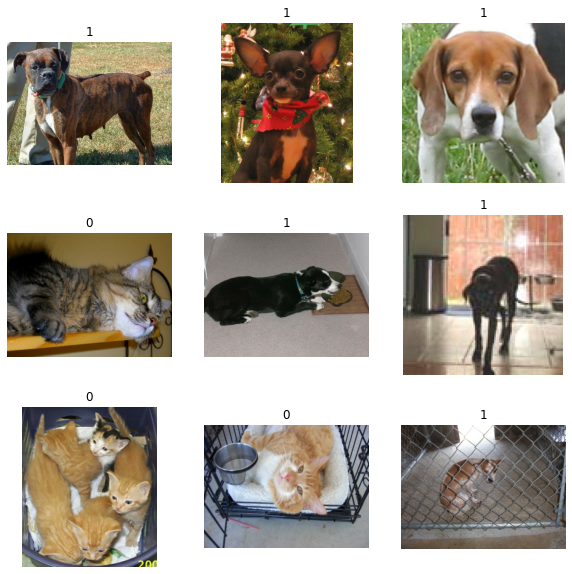

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

We can also see that label 1 is "dog" and label 0 is "cat".

### Standardizing the data

Our raw images have a variety of sizes. In addition, each pixel consists of 3 integer
values between 0 and 255 (RGB level values). This isn't a great fit for feeding a
 neural network. We need to do 2 things:

- Standardize to a fixed image size. We pick 150x150.
- Normalize pixel values between -1 and 1. We'll do this using a `Normalization` layer as
 part of the model itself.

In general, it's a good practice to develop models that take raw data as input, as
opposed to models that take already-preprocessed data. The reason being that, if your
model expects preprocessed data, any time you export your model to use it elsewhere
(in a web browser, in a mobile app), you'll need to reimplement the exact same
preprocessing pipeline. This gets very tricky very quickly. So we should do the least
 possible amount of preprocessing before hitting the model.

Here, we'll do image resizing in the data pipeline (because a deep neural network can
only process contiguous batches of data), and we'll do the input value scaling as part
 of the model, when we create it.

Let's resize images to 150x150:

In [19]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

Besides, let's batch the data and use caching & prefetching to optimize loading speed.

In [22]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

### Using random data augmentation

When you don't have a large image dataset, it's a good practice to artificially
 introduce sample diversity by applying random yet realistic transformations to
the training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
 overfitting.

In [23]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

Let's visualize what the first image of the first batch looks like after various random
 transformations:

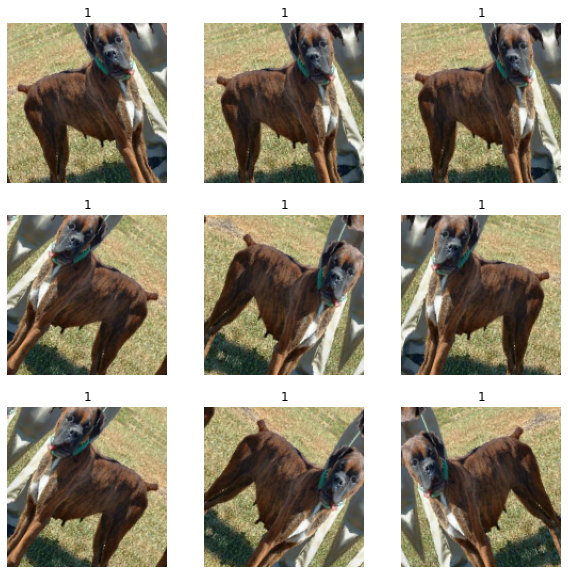

In [24]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

## Build a model

Now let's built a model that follows the blueprint we've explained earlier.

Note that:

- We add a `Rescaling` layer to scale input values (initially in the `[0, 255]`
 range) to the `[-1, 1]` range.
- We add a `Dropout` layer before the classification layer, for regularization.
- We make sure to pass `training=False` when calling the base model, so that
it runs in inference mode, so that batchnorm statistics don't get updated
even after we unfreeze the base model for fine-tuning.

In [25]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1) 
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_7 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0      

## Train the top layer

In [26]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [ ]:
epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
291/291 [==============================] - 976s 3s/step - loss: 0.1742 - binary_accuracy: 0.9229 - val_loss: 0.0807 - val_binary_accuracy: 0.9699
Epoch 2/20
291/291 [==============================] - 985s 3s/step - loss: 0.1197 - binary_accuracy: 0.9499 - val_loss: 0.0740 - val_binary_accuracy: 0.9708
Epoch 3/20
291/291 [==============================] - 981s 3s/step - loss: 0.1105 - binary_accuracy: 0.9538 - val_loss: 0.0711 - val_binary_accuracy: 0.9729
Epoch 4/20
220/291 [=====================>........] - ETA: 3:13 - loss: 0.1169 - binary_accuracy: 0.9500

## Do a round of fine-tuning of the entire model

Finally, let's unfreeze the base model and train the entire model end-to-end with a low
 learning rate.

Importantly, although the base model becomes trainable, it is still running in
inference mode since we passed `training=False` when calling it when we built the
model. This means that the batch normalization layers inside won't update their batch
statistics. If they did, they would wreck havoc on the representations learned by the
 model so far.

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
############################################
# x= base_model.trainable = False
############################################

base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 2049  

  1/291 [..............................] - ETA: 24:32 - loss: 0.1668 - binary_accuracy: 0.9375

  2/291 [..............................] - ETA: 35s - loss: 0.1314 - binary_accuracy: 0.9375  

  3/291 [..............................] - ETA: 35s - loss: 0.0916 - binary_accuracy: 0.9583

  4/291 [..............................] - ETA: 35s - loss: 0.0910 - binary_accuracy: 0.9531

  5/291 [..............................] - ETA: 35s - loss: 0.0791 - binary_accuracy: 0.9625

  6/291 [..............................] - ETA: 34s - loss: 0.0756 - binary_accuracy: 0.9635

  7/291 [..............................] - ETA: 34s - loss: 0.0900 - binary_accuracy: 0.9598

  8/291 [..............................] - ETA: 34s - loss: 0.0855 - binary_accuracy: 0.9609

  9/291 [..............................] - ETA: 34s - loss: 0.1013 - binary_accuracy: 0.9583

 10/291 [>.............................] - ETA: 34s - loss: 0.1161 - binary_accuracy: 0.9531

 11/291 [>.............................] - ETA: 34s - loss: 0.1195 - binary_accuracy: 0.9517

 12/291 [>.............................] - ETA: 34s - loss: 0.1177 - binary_accuracy: 0.9505

 13/291 [>.............................] - ETA: 34s - loss: 0.1147 - binary_accuracy: 0.9519

 14/291 [>.............................] - ETA: 33s - loss: 0.1153 - binary_accuracy: 0.9509

 15/291 [>.............................] - ETA: 33s - loss: 0.1253 - binary_accuracy: 0.9500

 16/291 [>.............................] - ETA: 33s - loss: 0.1187 - binary_accuracy: 0.9531

 17/291 [>.............................] - ETA: 33s - loss: 0.1123 - binary_accuracy: 0.9559

 18/291 [>.............................] - ETA: 33s - loss: 0.1091 - binary_accuracy: 0.9566

 19/291 [>.............................] - ETA: 33s - loss: 0.1038 - binary_accuracy: 0.9589

 20/291 [=>............................] - ETA: 33s - loss: 0.0998 - binary_accuracy: 0.9609

 21/291 [=>............................] - ETA: 33s - loss: 0.1078 - binary_accuracy: 0.9613

 22/291 [=>............................] - ETA: 32s - loss: 0.1065 - binary_accuracy: 0.9616

 23/291 [=>............................] - ETA: 32s - loss: 0.1125 - binary_accuracy: 0.9606

 24/291 [=>............................] - ETA: 32s - loss: 0.1087 - binary_accuracy: 0.9622

 25/291 [=>............................] - ETA: 32s - loss: 0.1062 - binary_accuracy: 0.9625

 26/291 [=>............................] - ETA: 32s - loss: 0.1030 - binary_accuracy: 0.9639

 27/291 [=>............................] - ETA: 32s - loss: 0.1063 - binary_accuracy: 0.9618

 28/291 [=>............................] - ETA: 32s - loss: 0.1059 - binary_accuracy: 0.9621

 29/291 [=>............................] - ETA: 32s - loss: 0.1059 - binary_accuracy: 0.9612

 30/291 [==>...........................] - ETA: 32s - loss: 0.1052 - binary_accuracy: 0.9615

 31/291 [==>...........................] - ETA: 31s - loss: 0.1076 - binary_accuracy: 0.9607

 32/291 [==>...........................] - ETA: 31s - loss: 0.1053 - binary_accuracy: 0.9609

 33/291 [==>...........................] - ETA: 31s - loss: 0.1035 - binary_accuracy: 0.9621

 34/291 [==>...........................] - ETA: 31s - loss: 0.1017 - binary_accuracy: 0.9632

 35/291 [==>...........................] - ETA: 31s - loss: 0.1030 - binary_accuracy: 0.9625

 36/291 [==>...........................] - ETA: 31s - loss: 0.1013 - binary_accuracy: 0.9635

 37/291 [==>...........................] - ETA: 31s - loss: 0.1018 - binary_accuracy: 0.9628

 38/291 [==>...........................] - ETA: 31s - loss: 0.1000 - binary_accuracy: 0.9638

 39/291 [===>..........................] - ETA: 30s - loss: 0.0989 - binary_accuracy: 0.9639

 40/291 [===>..........................] - ETA: 30s - loss: 0.0980 - binary_accuracy: 0.9641

 41/291 [===>..........................] - ETA: 30s - loss: 0.0989 - binary_accuracy: 0.9642

 42/291 [===>..........................] - ETA: 30s - loss: 0.0973 - binary_accuracy: 0.9650

 43/291 [===>..........................] - ETA: 30s - loss: 0.0976 - binary_accuracy: 0.9644

 44/291 [===>..........................] - ETA: 30s - loss: 0.0990 - binary_accuracy: 0.9645

 45/291 [===>..........................] - ETA: 30s - loss: 0.0991 - binary_accuracy: 0.9632

 46/291 [===>..........................] - ETA: 30s - loss: 0.0988 - binary_accuracy: 0.9626

 47/291 [===>..........................] - ETA: 29s - loss: 0.1000 - binary_accuracy: 0.9621

 48/291 [===>..........................] - ETA: 29s - loss: 0.0987 - binary_accuracy: 0.9629

 49/291 [====>.........................] - ETA: 29s - loss: 0.0969 - binary_accuracy: 0.9636

 50/291 [====>.........................] - ETA: 29s - loss: 0.0968 - binary_accuracy: 0.9638

 51/291 [====>.........................] - ETA: 29s - loss: 0.0961 - binary_accuracy: 0.9638

 52/291 [====>.........................] - ETA: 29s - loss: 0.0945 - binary_accuracy: 0.9645

 53/291 [====>.........................] - ETA: 29s - loss: 0.0931 - binary_accuracy: 0.9652

 54/291 [====>.........................] - ETA: 29s - loss: 0.0938 - binary_accuracy: 0.9647

 55/291 [====>.........................] - ETA: 28s - loss: 0.0927 - binary_accuracy: 0.9653

 56/291 [====>.........................] - ETA: 28s - loss: 0.0917 - binary_accuracy: 0.9660

 57/291 [====>.........................] - ETA: 28s - loss: 0.0920 - binary_accuracy: 0.9655

 58/291 [====>.........................] - ETA: 28s - loss: 0.0909 - binary_accuracy: 0.9655

 59/291 [=====>........................] - ETA: 28s - loss: 0.0897 - binary_accuracy: 0.9661

 60/291 [=====>........................] - ETA: 28s - loss: 0.0899 - binary_accuracy: 0.9651

 61/291 [=====>........................] - ETA: 28s - loss: 0.0889 - binary_accuracy: 0.9657

 62/291 [=====>........................] - ETA: 28s - loss: 0.0889 - binary_accuracy: 0.9657

 63/291 [=====>........................] - ETA: 27s - loss: 0.0879 - binary_accuracy: 0.9663

 64/291 [=====>........................] - ETA: 27s - loss: 0.0868 - binary_accuracy: 0.9668

 65/291 [=====>........................] - ETA: 27s - loss: 0.0865 - binary_accuracy: 0.9663

 66/291 [=====>........................] - ETA: 27s - loss: 0.0873 - binary_accuracy: 0.9654

 67/291 [=====>........................] - ETA: 27s - loss: 0.0883 - binary_accuracy: 0.9650

 68/291 [======>.......................] - ETA: 27s - loss: 0.0873 - binary_accuracy: 0.9655

 69/291 [======>.......................] - ETA: 27s - loss: 0.0864 - binary_accuracy: 0.9660

 70/291 [======>.......................] - ETA: 27s - loss: 0.0858 - binary_accuracy: 0.9665

 71/291 [======>.......................] - ETA: 26s - loss: 0.0853 - binary_accuracy: 0.9665

 72/291 [======>.......................] - ETA: 26s - loss: 0.0848 - binary_accuracy: 0.9670

 73/291 [======>.......................] - ETA: 26s - loss: 0.0847 - binary_accuracy: 0.9666

 74/291 [======>.......................] - ETA: 26s - loss: 0.0878 - binary_accuracy: 0.9654

 75/291 [======>.......................] - ETA: 26s - loss: 0.0871 - binary_accuracy: 0.9654

 76/291 [======>.......................] - ETA: 26s - loss: 0.0872 - binary_accuracy: 0.9650

 77/291 [======>.......................] - ETA: 26s - loss: 0.0874 - binary_accuracy: 0.9647

 78/291 [=======>......................] - ETA: 26s - loss: 0.0865 - binary_accuracy: 0.9651

 79/291 [=======>......................] - ETA: 25s - loss: 0.0862 - binary_accuracy: 0.9652

 80/291 [=======>......................] - ETA: 25s - loss: 0.0860 - binary_accuracy: 0.9652

 81/291 [=======>......................] - ETA: 25s - loss: 0.0856 - binary_accuracy: 0.9653

 82/291 [=======>......................] - ETA: 25s - loss: 0.0849 - binary_accuracy: 0.9657

 83/291 [=======>......................] - ETA: 25s - loss: 0.0841 - binary_accuracy: 0.9661

 84/291 [=======>......................] - ETA: 25s - loss: 0.0835 - binary_accuracy: 0.9661

 85/291 [=======>......................] - ETA: 25s - loss: 0.0833 - binary_accuracy: 0.9662

 86/291 [=======>......................] - ETA: 25s - loss: 0.0827 - binary_accuracy: 0.9666

 87/291 [=======>......................] - ETA: 25s - loss: 0.0833 - binary_accuracy: 0.9662

 88/291 [========>.....................] - ETA: 24s - loss: 0.0827 - binary_accuracy: 0.9663

 89/291 [========>.....................] - ETA: 24s - loss: 0.0829 - binary_accuracy: 0.9663

 90/291 [========>.....................] - ETA: 24s - loss: 0.0821 - binary_accuracy: 0.9667

 91/291 [========>.....................] - ETA: 24s - loss: 0.0827 - binary_accuracy: 0.9663

 92/291 [========>.....................] - ETA: 24s - loss: 0.0819 - binary_accuracy: 0.9667

 93/291 [========>.....................] - ETA: 24s - loss: 0.0813 - binary_accuracy: 0.9671

 94/291 [========>.....................] - ETA: 24s - loss: 0.0807 - binary_accuracy: 0.9674

 95/291 [========>.....................] - ETA: 24s - loss: 0.0819 - binary_accuracy: 0.9668

 96/291 [========>.....................] - ETA: 23s - loss: 0.0820 - binary_accuracy: 0.9665

 97/291 [=========>....................] - ETA: 23s - loss: 0.0819 - binary_accuracy: 0.9665

 98/291 [=========>....................] - ETA: 23s - loss: 0.0812 - binary_accuracy: 0.9668

 99/291 [=========>....................] - ETA: 23s - loss: 0.0810 - binary_accuracy: 0.9669

100/291 [=========>....................] - ETA: 23s - loss: 0.0820 - binary_accuracy: 0.9663

101/291 [=========>....................] - ETA: 23s - loss: 0.0836 - binary_accuracy: 0.9660

102/291 [=========>....................] - ETA: 23s - loss: 0.0833 - binary_accuracy: 0.9660

103/291 [=========>....................] - ETA: 23s - loss: 0.0826 - binary_accuracy: 0.9663

104/291 [=========>....................] - ETA: 22s - loss: 0.0820 - binary_accuracy: 0.9666

105/291 [=========>....................] - ETA: 22s - loss: 0.0844 - binary_accuracy: 0.9667

106/291 [=========>....................] - ETA: 22s - loss: 0.0842 - binary_accuracy: 0.9667

107/291 [==========>...................] - ETA: 22s - loss: 0.0837 - binary_accuracy: 0.9670

108/291 [==========>...................] - ETA: 22s - loss: 0.0831 - binary_accuracy: 0.9673

109/291 [==========>...................] - ETA: 22s - loss: 0.0824 - binary_accuracy: 0.9676

110/291 [==========>...................] - ETA: 22s - loss: 0.0823 - binary_accuracy: 0.9676

111/291 [==========>...................] - ETA: 22s - loss: 0.0820 - binary_accuracy: 0.9679

112/291 [==========>...................] - ETA: 21s - loss: 0.0839 - binary_accuracy: 0.9674

113/291 [==========>...................] - ETA: 21s - loss: 0.0832 - binary_accuracy: 0.9676

114/291 [==========>...................] - ETA: 21s - loss: 0.0829 - binary_accuracy: 0.9677

115/291 [==========>...................] - ETA: 21s - loss: 0.0830 - binary_accuracy: 0.9677

116/291 [==========>...................] - ETA: 21s - loss: 0.0833 - binary_accuracy: 0.9669

117/291 [===========>..................] - ETA: 21s - loss: 0.0827 - binary_accuracy: 0.9671

118/291 [===========>..................] - ETA: 21s - loss: 0.0835 - binary_accuracy: 0.9672

119/291 [===========>..................] - ETA: 21s - loss: 0.0841 - binary_accuracy: 0.9672

120/291 [===========>..................] - ETA: 20s - loss: 0.0846 - binary_accuracy: 0.9669

121/291 [===========>..................] - ETA: 20s - loss: 0.0840 - binary_accuracy: 0.9672

122/291 [===========>..................] - ETA: 20s - loss: 0.0835 - binary_accuracy: 0.9675

123/291 [===========>..................] - ETA: 20s - loss: 0.0848 - binary_accuracy: 0.9670

124/291 [===========>..................] - ETA: 20s - loss: 0.0843 - binary_accuracy: 0.9672

125/291 [===========>..................] - ETA: 20s - loss: 0.0865 - binary_accuracy: 0.9665

126/291 [===========>..................] - ETA: 20s - loss: 0.0861 - binary_accuracy: 0.9668

127/291 [============>.................] - ETA: 20s - loss: 0.0859 - binary_accuracy: 0.9668

128/291 [============>.................] - ETA: 19s - loss: 0.0866 - binary_accuracy: 0.9668

129/291 [============>.................] - ETA: 19s - loss: 0.0863 - binary_accuracy: 0.9668

130/291 [============>.................] - ETA: 19s - loss: 0.0861 - binary_accuracy: 0.9668

131/291 [============>.................] - ETA: 19s - loss: 0.0856 - binary_accuracy: 0.9671

132/291 [============>.................] - ETA: 19s - loss: 0.0853 - binary_accuracy: 0.9671

133/291 [============>.................] - ETA: 19s - loss: 0.0854 - binary_accuracy: 0.9671

134/291 [============>.................] - ETA: 19s - loss: 0.0849 - binary_accuracy: 0.9674

135/291 [============>.................] - ETA: 19s - loss: 0.0845 - binary_accuracy: 0.9676

136/291 [=============>................] - ETA: 19s - loss: 0.0847 - binary_accuracy: 0.9674

137/291 [=============>................] - ETA: 18s - loss: 0.0847 - binary_accuracy: 0.9674

138/291 [=============>................] - ETA: 18s - loss: 0.0858 - binary_accuracy: 0.9672

139/291 [=============>................] - ETA: 18s - loss: 0.0858 - binary_accuracy: 0.9670

140/291 [=============>................] - ETA: 18s - loss: 0.0856 - binary_accuracy: 0.9670

141/291 [=============>................] - ETA: 18s - loss: 0.0855 - binary_accuracy: 0.9668

142/291 [=============>................] - ETA: 18s - loss: 0.0858 - binary_accuracy: 0.9665

143/291 [=============>................] - ETA: 18s - loss: 0.0853 - binary_accuracy: 0.9668

144/291 [=============>................] - ETA: 18s - loss: 0.0850 - binary_accuracy: 0.9668

145/291 [=============>................] - ETA: 17s - loss: 0.0847 - binary_accuracy: 0.9670

146/291 [==============>...............] - ETA: 17s - loss: 0.0848 - binary_accuracy: 0.9670

147/291 [==============>...............] - ETA: 17s - loss: 0.0842 - binary_accuracy: 0.9673

148/291 [==============>...............] - ETA: 17s - loss: 0.0843 - binary_accuracy: 0.9673

149/291 [==============>...............] - ETA: 17s - loss: 0.0844 - binary_accuracy: 0.9671

150/291 [==============>...............] - ETA: 17s - loss: 0.0840 - binary_accuracy: 0.9673

151/291 [==============>...............] - ETA: 17s - loss: 0.0838 - binary_accuracy: 0.9673

152/291 [==============>...............] - ETA: 17s - loss: 0.0842 - binary_accuracy: 0.9671

153/291 [==============>...............] - ETA: 16s - loss: 0.0837 - binary_accuracy: 0.9673

154/291 [==============>...............] - ETA: 16s - loss: 0.0837 - binary_accuracy: 0.9673

155/291 [==============>...............] - ETA: 16s - loss: 0.0834 - binary_accuracy: 0.9675

156/291 [===============>..............] - ETA: 16s - loss: 0.0843 - binary_accuracy: 0.9673

157/291 [===============>..............] - ETA: 16s - loss: 0.0851 - binary_accuracy: 0.9674

158/291 [===============>..............] - ETA: 16s - loss: 0.0851 - binary_accuracy: 0.9670

159/291 [===============>..............] - ETA: 16s - loss: 0.0851 - binary_accuracy: 0.9668

160/291 [===============>..............] - ETA: 16s - loss: 0.0872 - binary_accuracy: 0.9662

161/291 [===============>..............] - ETA: 15s - loss: 0.0875 - binary_accuracy: 0.9662

162/291 [===============>..............] - ETA: 15s - loss: 0.0871 - binary_accuracy: 0.9664

163/291 [===============>..............] - ETA: 15s - loss: 0.0867 - binary_accuracy: 0.9666

164/291 [===============>..............] - ETA: 15s - loss: 0.0866 - binary_accuracy: 0.9667

165/291 [================>.............] - ETA: 15s - loss: 0.0865 - binary_accuracy: 0.9667

166/291 [================>.............] - ETA: 15s - loss: 0.0862 - binary_accuracy: 0.9669

167/291 [================>.............] - ETA: 15s - loss: 0.0858 - binary_accuracy: 0.9669

168/291 [================>.............] - ETA: 15s - loss: 0.0859 - binary_accuracy: 0.9669

169/291 [================>.............] - ETA: 14s - loss: 0.0862 - binary_accuracy: 0.9669

170/291 [================>.............] - ETA: 14s - loss: 0.0858 - binary_accuracy: 0.9671

171/291 [================>.............] - ETA: 14s - loss: 0.0854 - binary_accuracy: 0.9673

172/291 [================>.............] - ETA: 14s - loss: 0.0852 - binary_accuracy: 0.9673

173/291 [================>.............] - ETA: 14s - loss: 0.0847 - binary_accuracy: 0.9675

174/291 [================>.............] - ETA: 14s - loss: 0.0849 - binary_accuracy: 0.9675

175/291 [=================>............] - ETA: 14s - loss: 0.0851 - binary_accuracy: 0.9675

176/291 [=================>............] - ETA: 14s - loss: 0.0860 - binary_accuracy: 0.9672

177/291 [=================>............] - ETA: 13s - loss: 0.0857 - binary_accuracy: 0.9673

178/291 [=================>............] - ETA: 13s - loss: 0.0855 - binary_accuracy: 0.9673

179/291 [=================>............] - ETA: 13s - loss: 0.0854 - binary_accuracy: 0.9674

180/291 [=================>............] - ETA: 13s - loss: 0.0852 - binary_accuracy: 0.9674

181/291 [=================>............] - ETA: 13s - loss: 0.0858 - binary_accuracy: 0.9672

182/291 [=================>............] - ETA: 13s - loss: 0.0859 - binary_accuracy: 0.9670

183/291 [=================>............] - ETA: 13s - loss: 0.0856 - binary_accuracy: 0.9672

184/291 [=================>............] - ETA: 13s - loss: 0.0851 - binary_accuracy: 0.9674

185/291 [==================>...........] - ETA: 12s - loss: 0.0850 - binary_accuracy: 0.9674

186/291 [==================>...........] - ETA: 12s - loss: 0.0855 - binary_accuracy: 0.9672

187/291 [==================>...........] - ETA: 12s - loss: 0.0856 - binary_accuracy: 0.9672

188/291 [==================>...........] - ETA: 12s - loss: 0.0859 - binary_accuracy: 0.9668

189/291 [==================>...........] - ETA: 12s - loss: 0.0863 - binary_accuracy: 0.9668

190/291 [==================>...........] - ETA: 12s - loss: 0.0860 - binary_accuracy: 0.9669

191/291 [==================>...........] - ETA: 12s - loss: 0.0865 - binary_accuracy: 0.9668

192/291 [==================>...........] - ETA: 12s - loss: 0.0863 - binary_accuracy: 0.9668

193/291 [==================>...........] - ETA: 12s - loss: 0.0865 - binary_accuracy: 0.9668

194/291 [===================>..........] - ETA: 11s - loss: 0.0865 - binary_accuracy: 0.9668

195/291 [===================>..........] - ETA: 11s - loss: 0.0863 - binary_accuracy: 0.9670

196/291 [===================>..........] - ETA: 11s - loss: 0.0862 - binary_accuracy: 0.9670

197/291 [===================>..........] - ETA: 11s - loss: 0.0860 - binary_accuracy: 0.9670

198/291 [===================>..........] - ETA: 11s - loss: 0.0859 - binary_accuracy: 0.9672

199/291 [===================>..........] - ETA: 11s - loss: 0.0858 - binary_accuracy: 0.9672

200/291 [===================>..........] - ETA: 11s - loss: 0.0854 - binary_accuracy: 0.9673

201/291 [===================>..........] - ETA: 11s - loss: 0.0855 - binary_accuracy: 0.9672

202/291 [===================>..........] - ETA: 10s - loss: 0.0856 - binary_accuracy: 0.9670

203/291 [===================>..........] - ETA: 10s - loss: 0.0857 - binary_accuracy: 0.9671

204/291 [====================>.........] - ETA: 10s - loss: 0.0855 - binary_accuracy: 0.9671

205/291 [====================>.........] - ETA: 10s - loss: 0.0859 - binary_accuracy: 0.9669

206/291 [====================>.........] - ETA: 10s - loss: 0.0859 - binary_accuracy: 0.9668

207/291 [====================>.........] - ETA: 10s - loss: 0.0858 - binary_accuracy: 0.9668

208/291 [====================>.........] - ETA: 10s - loss: 0.0855 - binary_accuracy: 0.9669

209/291 [====================>.........] - ETA: 10s - loss: 0.0862 - binary_accuracy: 0.9667

210/291 [====================>.........] - ETA: 9s - loss: 0.0868 - binary_accuracy: 0.9665 

211/291 [====================>.........] - ETA: 9s - loss: 0.0867 - binary_accuracy: 0.9665

212/291 [====================>.........] - ETA: 9s - loss: 0.0866 - binary_accuracy: 0.9665

213/291 [====================>.........] - ETA: 9s - loss: 0.0864 - binary_accuracy: 0.9665

214/291 [=====================>........] - ETA: 9s - loss: 0.0863 - binary_accuracy: 0.9666

215/291 [=====================>........] - ETA: 9s - loss: 0.0860 - binary_accuracy: 0.9667

216/291 [=====================>........] - ETA: 9s - loss: 0.0858 - binary_accuracy: 0.9667

217/291 [=====================>........] - ETA: 9s - loss: 0.0867 - binary_accuracy: 0.9667

218/291 [=====================>........] - ETA: 8s - loss: 0.0868 - binary_accuracy: 0.9666

219/291 [=====================>........] - ETA: 8s - loss: 0.0865 - binary_accuracy: 0.9668

220/291 [=====================>........] - ETA: 8s - loss: 0.0863 - binary_accuracy: 0.9669

221/291 [=====================>........] - ETA: 8s - loss: 0.0860 - binary_accuracy: 0.9671

222/291 [=====================>........] - ETA: 8s - loss: 0.0858 - binary_accuracy: 0.9671

223/291 [=====================>........] - ETA: 8s - loss: 0.0858 - binary_accuracy: 0.9671

224/291 [======================>.......] - ETA: 8s - loss: 0.0854 - binary_accuracy: 0.9672

225/291 [======================>.......] - ETA: 8s - loss: 0.0859 - binary_accuracy: 0.9669

226/291 [======================>.......] - ETA: 7s - loss: 0.0856 - binary_accuracy: 0.9671

227/291 [======================>.......] - ETA: 7s - loss: 0.0853 - binary_accuracy: 0.9672

228/291 [======================>.......] - ETA: 7s - loss: 0.0853 - binary_accuracy: 0.9671

229/291 [======================>.......] - ETA: 7s - loss: 0.0850 - binary_accuracy: 0.9672

230/291 [======================>.......] - ETA: 7s - loss: 0.0847 - binary_accuracy: 0.9674

231/291 [======================>.......] - ETA: 7s - loss: 0.0845 - binary_accuracy: 0.9674

232/291 [======================>.......] - ETA: 7s - loss: 0.0844 - binary_accuracy: 0.9674

233/291 [=======================>......] - ETA: 7s - loss: 0.0844 - binary_accuracy: 0.9674

234/291 [=======================>......] - ETA: 6s - loss: 0.0841 - binary_accuracy: 0.9675

235/291 [=======================>......] - ETA: 6s - loss: 0.0838 - binary_accuracy: 0.9677

236/291 [=======================>......] - ETA: 6s - loss: 0.0836 - binary_accuracy: 0.9678

237/291 [=======================>......] - ETA: 6s - loss: 0.0835 - binary_accuracy: 0.9678

238/291 [=======================>......] - ETA: 6s - loss: 0.0839 - binary_accuracy: 0.9677

239/291 [=======================>......] - ETA: 6s - loss: 0.0836 - binary_accuracy: 0.9678

240/291 [=======================>......] - ETA: 6s - loss: 0.0838 - binary_accuracy: 0.9677

241/291 [=======================>......] - ETA: 6s - loss: 0.0835 - binary_accuracy: 0.9678

242/291 [=======================>......] - ETA: 6s - loss: 0.0832 - binary_accuracy: 0.9680

243/291 [========================>.....] - ETA: 5s - loss: 0.0834 - binary_accuracy: 0.9680

244/291 [========================>.....] - ETA: 5s - loss: 0.0832 - binary_accuracy: 0.9680

245/291 [========================>.....] - ETA: 5s - loss: 0.0830 - binary_accuracy: 0.9681

246/291 [========================>.....] - ETA: 5s - loss: 0.0829 - binary_accuracy: 0.9681

247/291 [========================>.....] - ETA: 5s - loss: 0.0829 - binary_accuracy: 0.9680

248/291 [========================>.....] - ETA: 5s - loss: 0.0831 - binary_accuracy: 0.9679

249/291 [========================>.....] - ETA: 5s - loss: 0.0829 - binary_accuracy: 0.9680

250/291 [========================>.....] - ETA: 5s - loss: 0.0828 - binary_accuracy: 0.9680

251/291 [========================>.....] - ETA: 4s - loss: 0.0828 - binary_accuracy: 0.9679

252/291 [========================>.....] - ETA: 4s - loss: 0.0825 - binary_accuracy: 0.9679

253/291 [=========================>....] - ETA: 4s - loss: 0.0824 - binary_accuracy: 0.9679

254/291 [=========================>....] - ETA: 4s - loss: 0.0830 - binary_accuracy: 0.9678

255/291 [=========================>....] - ETA: 4s - loss: 0.0829 - binary_accuracy: 0.9678

256/291 [=========================>....] - ETA: 4s - loss: 0.0827 - binary_accuracy: 0.9679

257/291 [=========================>....] - ETA: 4s - loss: 0.0825 - binary_accuracy: 0.9680

258/291 [=========================>....] - ETA: 4s - loss: 0.0822 - binary_accuracy: 0.9681

259/291 [=========================>....] - ETA: 3s - loss: 0.0821 - binary_accuracy: 0.9681

260/291 [=========================>....] - ETA: 3s - loss: 0.0820 - binary_accuracy: 0.9683

261/291 [=========================>....] - ETA: 3s - loss: 0.0819 - binary_accuracy: 0.9683

262/291 [==========================>...] - ETA: 3s - loss: 0.0819 - binary_accuracy: 0.9684

263/291 [==========================>...] - ETA: 3s - loss: 0.0819 - binary_accuracy: 0.9684

264/291 [==========================>...] - ETA: 3s - loss: 0.0816 - binary_accuracy: 0.9685

265/291 [==========================>...] - ETA: 3s - loss: 0.0814 - binary_accuracy: 0.9686

266/291 [==========================>...] - ETA: 3s - loss: 0.0819 - binary_accuracy: 0.9685

267/291 [==========================>...] - ETA: 2s - loss: 0.0821 - binary_accuracy: 0.9684

268/291 [==========================>...] - ETA: 2s - loss: 0.0822 - binary_accuracy: 0.9684

269/291 [==========================>...] - ETA: 2s - loss: 0.0821 - binary_accuracy: 0.9684

270/291 [==========================>...] - ETA: 2s - loss: 0.0819 - binary_accuracy: 0.9685

271/291 [==========================>...] - ETA: 2s - loss: 0.0816 - binary_accuracy: 0.9686

272/291 [===========================>..] - ETA: 2s - loss: 0.0814 - binary_accuracy: 0.9688

273/291 [===========================>..] - ETA: 2s - loss: 0.0813 - binary_accuracy: 0.9688

274/291 [===========================>..] - ETA: 2s - loss: 0.0813 - binary_accuracy: 0.9686

275/291 [===========================>..] - ETA: 1s - loss: 0.0811 - binary_accuracy: 0.9688

276/291 [===========================>..] - ETA: 1s - loss: 0.0809 - binary_accuracy: 0.9689

277/291 [===========================>..] - ETA: 1s - loss: 0.0806 - binary_accuracy: 0.9690

278/291 [===========================>..] - ETA: 1s - loss: 0.0804 - binary_accuracy: 0.9691

279/291 [===========================>..] - ETA: 1s - loss: 0.0802 - binary_accuracy: 0.9692

280/291 [===========================>..] - ETA: 1s - loss: 0.0803 - binary_accuracy: 0.9691

281/291 [===========================>..] - ETA: 1s - loss: 0.0804 - binary_accuracy: 0.9689

282/291 [============================>.] - ETA: 1s - loss: 0.0807 - binary_accuracy: 0.9689

283/291 [============================>.] - ETA: 0s - loss: 0.0806 - binary_accuracy: 0.9690

284/291 [============================>.] - ETA: 0s - loss: 0.0803 - binary_accuracy: 0.9691

285/291 [============================>.] - ETA: 0s - loss: 0.0802 - binary_accuracy: 0.9692

286/291 [============================>.] - ETA: 0s - loss: 0.0808 - binary_accuracy: 0.9690

287/291 [============================>.] - ETA: 0s - loss: 0.0806 - binary_accuracy: 0.9691

288/291 [============================>.] - ETA: 0s - loss: 0.0805 - binary_accuracy: 0.9691

289/291 [============================>.] - ETA: 0s - loss: 0.0803 - binary_accuracy: 0.9692

290/291 [============================>.] - ETA: 0s - loss: 0.0802 - binary_accuracy: 0.9692

291/291 [==============================] - ETA: 0s - loss: 0.0802 - binary_accuracy: 0.9692

291/291 [==============================] - 43s 131ms/step - loss: 0.0802 - binary_accuracy: 0.9692 - val_loss: 0.0580 - val_binary_accuracy: 0.9764


Epoch 2/10
  1/291 [..............................] - ETA: 36s - loss: 0.0801 - binary_accuracy: 0.9375

  2/291 [..............................] - ETA: 35s - loss: 0.0469 - binary_accuracy: 0.9688

  3/291 [..............................] - ETA: 35s - loss: 0.0402 - binary_accuracy: 0.9792

  4/291 [..............................] - ETA: 35s - loss: 0.0328 - binary_accuracy: 0.9844

  5/291 [..............................] - ETA: 35s - loss: 0.0292 - binary_accuracy: 0.9875

  6/291 [..............................] - ETA: 35s - loss: 0.0434 - binary_accuracy: 0.9844

  7/291 [..............................] - ETA: 34s - loss: 0.0398 - binary_accuracy: 0.9866

  8/291 [..............................] - ETA: 34s - loss: 0.0425 - binary_accuracy: 0.9844

  9/291 [..............................] - ETA: 35s - loss: 0.0785 - binary_accuracy: 0.9722

 10/291 [>.............................] - ETA: 35s - loss: 0.0800 - binary_accuracy: 0.9719

 11/291 [>.............................] - ETA: 34s - loss: 0.0743 - binary_accuracy: 0.9744

 12/291 [>.............................] - ETA: 34s - loss: 0.0728 - binary_accuracy: 0.9740

 13/291 [>.............................] - ETA: 34s - loss: 0.0688 - binary_accuracy: 0.9736

 14/291 [>.............................] - ETA: 34s - loss: 0.0653 - binary_accuracy: 0.9754

 15/291 [>.............................] - ETA: 34s - loss: 0.0645 - binary_accuracy: 0.9750

 16/291 [>.............................] - ETA: 34s - loss: 0.0611 - binary_accuracy: 0.9766

 17/291 [>.............................] - ETA: 33s - loss: 0.0578 - binary_accuracy: 0.9779

 18/291 [>.............................] - ETA: 33s - loss: 0.0597 - binary_accuracy: 0.9740

 19/291 [>.............................] - ETA: 33s - loss: 0.0575 - binary_accuracy: 0.9753

 20/291 [=>............................] - ETA: 33s - loss: 0.0556 - binary_accuracy: 0.9766

 21/291 [=>............................] - ETA: 33s - loss: 0.0621 - binary_accuracy: 0.9747

 22/291 [=>............................] - ETA: 33s - loss: 0.0600 - binary_accuracy: 0.9759

 23/291 [=>............................] - ETA: 33s - loss: 0.0586 - binary_accuracy: 0.9755

 24/291 [=>............................] - ETA: 32s - loss: 0.0564 - binary_accuracy: 0.9766

 25/291 [=>............................] - ETA: 32s - loss: 0.0546 - binary_accuracy: 0.9775

 26/291 [=>............................] - ETA: 32s - loss: 0.0568 - binary_accuracy: 0.9772

 27/291 [=>............................] - ETA: 32s - loss: 0.0607 - binary_accuracy: 0.9745

 28/291 [=>............................] - ETA: 32s - loss: 0.0605 - binary_accuracy: 0.9743

 29/291 [=>............................] - ETA: 32s - loss: 0.0620 - binary_accuracy: 0.9731

 30/291 [==>...........................] - ETA: 32s - loss: 0.0621 - binary_accuracy: 0.9719

 31/291 [==>...........................] - ETA: 32s - loss: 0.0605 - binary_accuracy: 0.9728

 32/291 [==>...........................] - ETA: 31s - loss: 0.0603 - binary_accuracy: 0.9727

 33/291 [==>...........................] - ETA: 31s - loss: 0.0606 - binary_accuracy: 0.9725

 34/291 [==>...........................] - ETA: 31s - loss: 0.0597 - binary_accuracy: 0.9733

 35/291 [==>...........................] - ETA: 31s - loss: 0.0596 - binary_accuracy: 0.9732

 36/291 [==>...........................] - ETA: 31s - loss: 0.0592 - binary_accuracy: 0.9740

 37/291 [==>...........................] - ETA: 31s - loss: 0.0580 - binary_accuracy: 0.9747

 38/291 [==>...........................] - ETA: 31s - loss: 0.0575 - binary_accuracy: 0.9753

 39/291 [===>..........................] - ETA: 31s - loss: 0.0571 - binary_accuracy: 0.9752

 40/291 [===>..........................] - ETA: 30s - loss: 0.0561 - binary_accuracy: 0.9758

 41/291 [===>..........................] - ETA: 30s - loss: 0.0566 - binary_accuracy: 0.9748

 42/291 [===>..........................] - ETA: 30s - loss: 0.0559 - binary_accuracy: 0.9754

 43/291 [===>..........................] - ETA: 30s - loss: 0.0560 - binary_accuracy: 0.9753

 44/291 [===>..........................] - ETA: 30s - loss: 0.0550 - binary_accuracy: 0.9759

 45/291 [===>..........................] - ETA: 30s - loss: 0.0547 - binary_accuracy: 0.9764

 46/291 [===>..........................] - ETA: 30s - loss: 0.0540 - binary_accuracy: 0.9769

 47/291 [===>..........................] - ETA: 30s - loss: 0.0533 - binary_accuracy: 0.9774

 48/291 [===>..........................] - ETA: 29s - loss: 0.0523 - binary_accuracy: 0.9779

 49/291 [====>.........................] - ETA: 29s - loss: 0.0520 - binary_accuracy: 0.9783

 50/291 [====>.........................] - ETA: 29s - loss: 0.0515 - binary_accuracy: 0.9787

 51/291 [====>.........................] - ETA: 29s - loss: 0.0512 - binary_accuracy: 0.9792

 52/291 [====>.........................] - ETA: 29s - loss: 0.0508 - binary_accuracy: 0.9790

 53/291 [====>.........................] - ETA: 29s - loss: 0.0501 - binary_accuracy: 0.9794

 54/291 [====>.........................] - ETA: 29s - loss: 0.0497 - binary_accuracy: 0.9797

 55/291 [====>.........................] - ETA: 29s - loss: 0.0489 - binary_accuracy: 0.9801

 56/291 [====>.........................] - ETA: 28s - loss: 0.0482 - binary_accuracy: 0.9805

 57/291 [====>.........................] - ETA: 28s - loss: 0.0489 - binary_accuracy: 0.9803

 58/291 [====>.........................] - ETA: 28s - loss: 0.0484 - binary_accuracy: 0.9806

 59/291 [=====>........................] - ETA: 28s - loss: 0.0477 - binary_accuracy: 0.9809

 60/291 [=====>........................] - ETA: 28s - loss: 0.0516 - binary_accuracy: 0.9802

 61/291 [=====>........................] - ETA: 28s - loss: 0.0516 - binary_accuracy: 0.9800

 62/291 [=====>........................] - ETA: 28s - loss: 0.0522 - binary_accuracy: 0.9793

 63/291 [=====>........................] - ETA: 28s - loss: 0.0516 - binary_accuracy: 0.9797

 64/291 [=====>........................] - ETA: 27s - loss: 0.0510 - binary_accuracy: 0.9800

 65/291 [=====>........................] - ETA: 27s - loss: 0.0503 - binary_accuracy: 0.9803

 66/291 [=====>........................] - ETA: 27s - loss: 0.0502 - binary_accuracy: 0.9801

 67/291 [=====>........................] - ETA: 27s - loss: 0.0509 - binary_accuracy: 0.9795

 68/291 [======>.......................] - ETA: 27s - loss: 0.0503 - binary_accuracy: 0.9798

 69/291 [======>.......................] - ETA: 27s - loss: 0.0497 - binary_accuracy: 0.9801

 70/291 [======>.......................] - ETA: 27s - loss: 0.0495 - binary_accuracy: 0.9804

 71/291 [======>.......................] - ETA: 27s - loss: 0.0492 - binary_accuracy: 0.9802

 72/291 [======>.......................] - ETA: 26s - loss: 0.0491 - binary_accuracy: 0.9800

 73/291 [======>.......................] - ETA: 26s - loss: 0.0490 - binary_accuracy: 0.9803

 74/291 [======>.......................] - ETA: 26s - loss: 0.0499 - binary_accuracy: 0.9802

 75/291 [======>.......................] - ETA: 26s - loss: 0.0494 - binary_accuracy: 0.9804

 76/291 [======>.......................] - ETA: 26s - loss: 0.0508 - binary_accuracy: 0.9799

 77/291 [======>.......................] - ETA: 26s - loss: 0.0509 - binary_accuracy: 0.9797

 78/291 [=======>......................] - ETA: 26s - loss: 0.0512 - binary_accuracy: 0.9796

 79/291 [=======>......................] - ETA: 26s - loss: 0.0506 - binary_accuracy: 0.9798

 80/291 [=======>......................] - ETA: 25s - loss: 0.0502 - binary_accuracy: 0.9801

 81/291 [=======>......................] - ETA: 25s - loss: 0.0498 - binary_accuracy: 0.9803

 82/291 [=======>......................] - ETA: 25s - loss: 0.0494 - binary_accuracy: 0.9806

 83/291 [=======>......................] - ETA: 25s - loss: 0.0489 - binary_accuracy: 0.9808

 84/291 [=======>......................] - ETA: 25s - loss: 0.0485 - binary_accuracy: 0.9810

 85/291 [=======>......................] - ETA: 25s - loss: 0.0485 - binary_accuracy: 0.9809

 86/291 [=======>......................] - ETA: 25s - loss: 0.0485 - binary_accuracy: 0.9811

 87/291 [=======>......................] - ETA: 25s - loss: 0.0480 - binary_accuracy: 0.9813

 88/291 [========>.....................] - ETA: 24s - loss: 0.0480 - binary_accuracy: 0.9815

 89/291 [========>.....................] - ETA: 24s - loss: 0.0493 - binary_accuracy: 0.9810

 90/291 [========>.....................] - ETA: 24s - loss: 0.0494 - binary_accuracy: 0.9806

 91/291 [========>.....................] - ETA: 24s - loss: 0.0490 - binary_accuracy: 0.9808

 92/291 [========>.....................] - ETA: 24s - loss: 0.0501 - binary_accuracy: 0.9803

 93/291 [========>.....................] - ETA: 24s - loss: 0.0501 - binary_accuracy: 0.9798

 94/291 [========>.....................] - ETA: 24s - loss: 0.0498 - binary_accuracy: 0.9797

 95/291 [========>.....................] - ETA: 24s - loss: 0.0507 - binary_accuracy: 0.9786

 96/291 [========>.....................] - ETA: 23s - loss: 0.0506 - binary_accuracy: 0.9785

 97/291 [=========>....................] - ETA: 23s - loss: 0.0511 - binary_accuracy: 0.9781

 98/291 [=========>....................] - ETA: 23s - loss: 0.0517 - binary_accuracy: 0.9780

 99/291 [=========>....................] - ETA: 23s - loss: 0.0518 - binary_accuracy: 0.9779

100/291 [=========>....................] - ETA: 23s - loss: 0.0515 - binary_accuracy: 0.9781

101/291 [=========>....................] - ETA: 23s - loss: 0.0520 - binary_accuracy: 0.9780

102/291 [=========>....................] - ETA: 23s - loss: 0.0516 - binary_accuracy: 0.9782

103/291 [=========>....................] - ETA: 23s - loss: 0.0515 - binary_accuracy: 0.9785

104/291 [=========>....................] - ETA: 22s - loss: 0.0515 - binary_accuracy: 0.9784

105/291 [=========>....................] - ETA: 22s - loss: 0.0535 - binary_accuracy: 0.9783

106/291 [=========>....................] - ETA: 22s - loss: 0.0535 - binary_accuracy: 0.9782

107/291 [==========>...................] - ETA: 22s - loss: 0.0530 - binary_accuracy: 0.9784

108/291 [==========>...................] - ETA: 22s - loss: 0.0529 - binary_accuracy: 0.9783

109/291 [==========>...................] - ETA: 22s - loss: 0.0524 - binary_accuracy: 0.9785

110/291 [==========>...................] - ETA: 22s - loss: 0.0539 - binary_accuracy: 0.9784

111/291 [==========>...................] - ETA: 22s - loss: 0.0539 - binary_accuracy: 0.9783

112/291 [==========>...................] - ETA: 21s - loss: 0.0535 - binary_accuracy: 0.9785

113/291 [==========>...................] - ETA: 21s - loss: 0.0532 - binary_accuracy: 0.9787

114/291 [==========>...................] - ETA: 21s - loss: 0.0528 - binary_accuracy: 0.9789

115/291 [==========>...................] - ETA: 21s - loss: 0.0529 - binary_accuracy: 0.9788

116/291 [==========>...................] - ETA: 21s - loss: 0.0537 - binary_accuracy: 0.9784

117/291 [===========>..................] - ETA: 21s - loss: 0.0535 - binary_accuracy: 0.9784

118/291 [===========>..................] - ETA: 21s - loss: 0.0531 - binary_accuracy: 0.9785

119/291 [===========>..................] - ETA: 21s - loss: 0.0528 - binary_accuracy: 0.9787

120/291 [===========>..................] - ETA: 20s - loss: 0.0524 - binary_accuracy: 0.9789

121/291 [===========>..................] - ETA: 20s - loss: 0.0520 - binary_accuracy: 0.9791

122/291 [===========>..................] - ETA: 20s - loss: 0.0521 - binary_accuracy: 0.9790

123/291 [===========>..................] - ETA: 20s - loss: 0.0531 - binary_accuracy: 0.9789

124/291 [===========>..................] - ETA: 20s - loss: 0.0532 - binary_accuracy: 0.9788

125/291 [===========>..................] - ETA: 20s - loss: 0.0540 - binary_accuracy: 0.9785

126/291 [===========>..................] - ETA: 20s - loss: 0.0536 - binary_accuracy: 0.9787

127/291 [============>.................] - ETA: 20s - loss: 0.0536 - binary_accuracy: 0.9788

128/291 [============>.................] - ETA: 19s - loss: 0.0534 - binary_accuracy: 0.9790

129/291 [============>.................] - ETA: 19s - loss: 0.0531 - binary_accuracy: 0.9792

130/291 [============>.................] - ETA: 19s - loss: 0.0538 - binary_accuracy: 0.9791

131/291 [============>.................] - ETA: 19s - loss: 0.0535 - binary_accuracy: 0.9792

132/291 [============>.................] - ETA: 19s - loss: 0.0533 - binary_accuracy: 0.9794

133/291 [============>.................] - ETA: 19s - loss: 0.0537 - binary_accuracy: 0.9793

134/291 [============>.................] - ETA: 19s - loss: 0.0537 - binary_accuracy: 0.9792

135/291 [============>.................] - ETA: 19s - loss: 0.0533 - binary_accuracy: 0.9794

136/291 [=============>................] - ETA: 19s - loss: 0.0544 - binary_accuracy: 0.9791

137/291 [=============>................] - ETA: 18s - loss: 0.0540 - binary_accuracy: 0.9792

138/291 [=============>................] - ETA: 18s - loss: 0.0546 - binary_accuracy: 0.9787

139/291 [=============>................] - ETA: 18s - loss: 0.0544 - binary_accuracy: 0.9789

140/291 [=============>................] - ETA: 18s - loss: 0.0540 - binary_accuracy: 0.9790

141/291 [=============>................] - ETA: 18s - loss: 0.0540 - binary_accuracy: 0.9789

142/291 [=============>................] - ETA: 18s - loss: 0.0543 - binary_accuracy: 0.9787

143/291 [=============>................] - ETA: 18s - loss: 0.0545 - binary_accuracy: 0.9786

144/291 [=============>................] - ETA: 18s - loss: 0.0543 - binary_accuracy: 0.9787

145/291 [=============>................] - ETA: 17s - loss: 0.0544 - binary_accuracy: 0.9787

146/291 [==============>...............] - ETA: 17s - loss: 0.0547 - binary_accuracy: 0.9784

147/291 [==============>...............] - ETA: 17s - loss: 0.0544 - binary_accuracy: 0.9785

148/291 [==============>...............] - ETA: 17s - loss: 0.0541 - binary_accuracy: 0.9787

149/291 [==============>...............] - ETA: 17s - loss: 0.0539 - binary_accuracy: 0.9788

150/291 [==============>...............] - ETA: 17s - loss: 0.0536 - binary_accuracy: 0.9790

151/291 [==============>...............] - ETA: 17s - loss: 0.0532 - binary_accuracy: 0.9791

152/291 [==============>...............] - ETA: 17s - loss: 0.0531 - binary_accuracy: 0.9792

153/291 [==============>...............] - ETA: 16s - loss: 0.0528 - binary_accuracy: 0.9794

154/291 [==============>...............] - ETA: 16s - loss: 0.0526 - binary_accuracy: 0.9795

155/291 [==============>...............] - ETA: 16s - loss: 0.0528 - binary_accuracy: 0.9794

156/291 [===============>..............] - ETA: 16s - loss: 0.0527 - binary_accuracy: 0.9796

157/291 [===============>..............] - ETA: 16s - loss: 0.0526 - binary_accuracy: 0.9797

158/291 [===============>..............] - ETA: 16s - loss: 0.0530 - binary_accuracy: 0.9796

159/291 [===============>..............] - ETA: 16s - loss: 0.0528 - binary_accuracy: 0.9798

160/291 [===============>..............] - ETA: 16s - loss: 0.0542 - binary_accuracy: 0.9793

161/291 [===============>..............] - ETA: 15s - loss: 0.0542 - binary_accuracy: 0.9792

162/291 [===============>..............] - ETA: 15s - loss: 0.0539 - binary_accuracy: 0.9794

163/291 [===============>..............] - ETA: 15s - loss: 0.0536 - binary_accuracy: 0.9795

164/291 [===============>..............] - ETA: 15s - loss: 0.0538 - binary_accuracy: 0.9794

165/291 [================>.............] - ETA: 15s - loss: 0.0546 - binary_accuracy: 0.9794

166/291 [================>.............] - ETA: 15s - loss: 0.0545 - binary_accuracy: 0.9793

167/291 [================>.............] - ETA: 15s - loss: 0.0543 - binary_accuracy: 0.9794

168/291 [================>.............] - ETA: 15s - loss: 0.0541 - binary_accuracy: 0.9795

169/291 [================>.............] - ETA: 14s - loss: 0.0540 - binary_accuracy: 0.9797

170/291 [================>.............] - ETA: 14s - loss: 0.0537 - binary_accuracy: 0.9798

171/291 [================>.............] - ETA: 14s - loss: 0.0537 - binary_accuracy: 0.9797

172/291 [================>.............] - ETA: 14s - loss: 0.0535 - binary_accuracy: 0.9798

173/291 [================>.............] - ETA: 14s - loss: 0.0533 - binary_accuracy: 0.9799

174/291 [================>.............] - ETA: 14s - loss: 0.0532 - binary_accuracy: 0.9801

175/291 [=================>............] - ETA: 14s - loss: 0.0538 - binary_accuracy: 0.9800

176/291 [=================>............] - ETA: 14s - loss: 0.0551 - binary_accuracy: 0.9796

177/291 [=================>............] - ETA: 13s - loss: 0.0550 - binary_accuracy: 0.9797

178/291 [=================>............] - ETA: 13s - loss: 0.0565 - binary_accuracy: 0.9795

179/291 [=================>............] - ETA: 13s - loss: 0.0562 - binary_accuracy: 0.9796

180/291 [=================>............] - ETA: 13s - loss: 0.0568 - binary_accuracy: 0.9793

181/291 [=================>............] - ETA: 13s - loss: 0.0574 - binary_accuracy: 0.9791

182/291 [=================>............] - ETA: 13s - loss: 0.0574 - binary_accuracy: 0.9791

183/291 [=================>............] - ETA: 13s - loss: 0.0572 - binary_accuracy: 0.9792

184/291 [=================>............] - ETA: 13s - loss: 0.0569 - binary_accuracy: 0.9793

185/291 [==================>...........] - ETA: 12s - loss: 0.0566 - binary_accuracy: 0.9794

186/291 [==================>...........] - ETA: 12s - loss: 0.0575 - binary_accuracy: 0.9792

187/291 [==================>...........] - ETA: 12s - loss: 0.0574 - binary_accuracy: 0.9791

188/291 [==================>...........] - ETA: 12s - loss: 0.0576 - binary_accuracy: 0.9791

189/291 [==================>...........] - ETA: 12s - loss: 0.0578 - binary_accuracy: 0.9788

190/291 [==================>...........] - ETA: 12s - loss: 0.0577 - binary_accuracy: 0.9789

191/291 [==================>...........] - ETA: 12s - loss: 0.0578 - binary_accuracy: 0.9787

192/291 [==================>...........] - ETA: 12s - loss: 0.0582 - binary_accuracy: 0.9787

193/291 [==================>...........] - ETA: 12s - loss: 0.0585 - binary_accuracy: 0.9785

194/291 [===================>..........] - ETA: 11s - loss: 0.0582 - binary_accuracy: 0.9786

195/291 [===================>..........] - ETA: 11s - loss: 0.0581 - binary_accuracy: 0.9787

196/291 [===================>..........] - ETA: 11s - loss: 0.0579 - binary_accuracy: 0.9788

197/291 [===================>..........] - ETA: 11s - loss: 0.0579 - binary_accuracy: 0.9786

198/291 [===================>..........] - ETA: 11s - loss: 0.0581 - binary_accuracy: 0.9784

199/291 [===================>..........] - ETA: 11s - loss: 0.0579 - binary_accuracy: 0.9785

200/291 [===================>..........] - ETA: 11s - loss: 0.0577 - binary_accuracy: 0.9786

201/291 [===================>..........] - ETA: 11s - loss: 0.0578 - binary_accuracy: 0.9784

202/291 [===================>..........] - ETA: 10s - loss: 0.0576 - binary_accuracy: 0.9785

203/291 [===================>..........] - ETA: 10s - loss: 0.0575 - binary_accuracy: 0.9786

204/291 [====================>.........] - ETA: 10s - loss: 0.0575 - binary_accuracy: 0.9786

205/291 [====================>.........] - ETA: 10s - loss: 0.0583 - binary_accuracy: 0.9784

206/291 [====================>.........] - ETA: 10s - loss: 0.0581 - binary_accuracy: 0.9785

207/291 [====================>.........] - ETA: 10s - loss: 0.0579 - binary_accuracy: 0.9786

208/291 [====================>.........] - ETA: 10s - loss: 0.0577 - binary_accuracy: 0.9787

209/291 [====================>.........] - ETA: 10s - loss: 0.0577 - binary_accuracy: 0.9786

210/291 [====================>.........] - ETA: 9s - loss: 0.0575 - binary_accuracy: 0.9786 

211/291 [====================>.........] - ETA: 9s - loss: 0.0578 - binary_accuracy: 0.9784

212/291 [====================>.........] - ETA: 9s - loss: 0.0577 - binary_accuracy: 0.9782

213/291 [====================>.........] - ETA: 9s - loss: 0.0576 - binary_accuracy: 0.9781

214/291 [=====================>........] - ETA: 9s - loss: 0.0577 - binary_accuracy: 0.9781

215/291 [=====================>........] - ETA: 9s - loss: 0.0583 - binary_accuracy: 0.9779

216/291 [=====================>........] - ETA: 9s - loss: 0.0580 - binary_accuracy: 0.9780

217/291 [=====================>........] - ETA: 9s - loss: 0.0579 - binary_accuracy: 0.9781

218/291 [=====================>........] - ETA: 8s - loss: 0.0581 - binary_accuracy: 0.9781

219/291 [=====================>........] - ETA: 8s - loss: 0.0579 - binary_accuracy: 0.9782

220/291 [=====================>........] - ETA: 8s - loss: 0.0580 - binary_accuracy: 0.9781

221/291 [=====================>........] - ETA: 8s - loss: 0.0578 - binary_accuracy: 0.9782

222/291 [=====================>........] - ETA: 8s - loss: 0.0579 - binary_accuracy: 0.9780

223/291 [=====================>........] - ETA: 8s - loss: 0.0578 - binary_accuracy: 0.9780

224/291 [======================>.......] - ETA: 8s - loss: 0.0576 - binary_accuracy: 0.9781

225/291 [======================>.......] - ETA: 8s - loss: 0.0580 - binary_accuracy: 0.9779

226/291 [======================>.......] - ETA: 7s - loss: 0.0578 - binary_accuracy: 0.9780

227/291 [======================>.......] - ETA: 7s - loss: 0.0576 - binary_accuracy: 0.9781

228/291 [======================>.......] - ETA: 7s - loss: 0.0578 - binary_accuracy: 0.9781

229/291 [======================>.......] - ETA: 7s - loss: 0.0577 - binary_accuracy: 0.9780

230/291 [======================>.......] - ETA: 7s - loss: 0.0575 - binary_accuracy: 0.9780

231/291 [======================>.......] - ETA: 7s - loss: 0.0574 - binary_accuracy: 0.9781

232/291 [======================>.......] - ETA: 7s - loss: 0.0572 - binary_accuracy: 0.9782

233/291 [=======================>......] - ETA: 7s - loss: 0.0572 - binary_accuracy: 0.9783

234/291 [=======================>......] - ETA: 6s - loss: 0.0569 - binary_accuracy: 0.9784

235/291 [=======================>......] - ETA: 6s - loss: 0.0568 - binary_accuracy: 0.9785

236/291 [=======================>......] - ETA: 6s - loss: 0.0567 - binary_accuracy: 0.9785

237/291 [=======================>......] - ETA: 6s - loss: 0.0568 - binary_accuracy: 0.9784

238/291 [=======================>......] - ETA: 6s - loss: 0.0566 - binary_accuracy: 0.9785

239/291 [=======================>......] - ETA: 6s - loss: 0.0567 - binary_accuracy: 0.9784

240/291 [=======================>......] - ETA: 6s - loss: 0.0566 - binary_accuracy: 0.9785

241/291 [=======================>......] - ETA: 6s - loss: 0.0564 - binary_accuracy: 0.9786

242/291 [=======================>......] - ETA: 6s - loss: 0.0562 - binary_accuracy: 0.9787

243/291 [========================>.....] - ETA: 5s - loss: 0.0561 - binary_accuracy: 0.9787

244/291 [========================>.....] - ETA: 5s - loss: 0.0564 - binary_accuracy: 0.9786

245/291 [========================>.....] - ETA: 5s - loss: 0.0562 - binary_accuracy: 0.9787

246/291 [========================>.....] - ETA: 5s - loss: 0.0561 - binary_accuracy: 0.9787

247/291 [========================>.....] - ETA: 5s - loss: 0.0560 - binary_accuracy: 0.9787

248/291 [========================>.....] - ETA: 5s - loss: 0.0563 - binary_accuracy: 0.9786

249/291 [========================>.....] - ETA: 5s - loss: 0.0561 - binary_accuracy: 0.9787

250/291 [========================>.....] - ETA: 5s - loss: 0.0561 - binary_accuracy: 0.9787

251/291 [========================>.....] - ETA: 4s - loss: 0.0560 - binary_accuracy: 0.9788

252/291 [========================>.....] - ETA: 4s - loss: 0.0558 - binary_accuracy: 0.9789

253/291 [=========================>....] - ETA: 4s - loss: 0.0557 - binary_accuracy: 0.9789

254/291 [=========================>....] - ETA: 4s - loss: 0.0556 - binary_accuracy: 0.9790

255/291 [=========================>....] - ETA: 4s - loss: 0.0556 - binary_accuracy: 0.9788

256/291 [=========================>....] - ETA: 4s - loss: 0.0554 - binary_accuracy: 0.9789

257/291 [=========================>....] - ETA: 4s - loss: 0.0555 - binary_accuracy: 0.9787

258/291 [=========================>....] - ETA: 4s - loss: 0.0553 - binary_accuracy: 0.9788

259/291 [=========================>....] - ETA: 3s - loss: 0.0552 - binary_accuracy: 0.9789

260/291 [=========================>....] - ETA: 3s - loss: 0.0554 - binary_accuracy: 0.9788

261/291 [=========================>....] - ETA: 3s - loss: 0.0553 - binary_accuracy: 0.9788

262/291 [==========================>...] - ETA: 3s - loss: 0.0552 - binary_accuracy: 0.9789

263/291 [==========================>...] - ETA: 3s - loss: 0.0552 - binary_accuracy: 0.9788

264/291 [==========================>...] - ETA: 3s - loss: 0.0551 - binary_accuracy: 0.9789

265/291 [==========================>...] - ETA: 3s - loss: 0.0549 - binary_accuracy: 0.9789

266/291 [==========================>...] - ETA: 3s - loss: 0.0549 - binary_accuracy: 0.9790

267/291 [==========================>...] - ETA: 2s - loss: 0.0549 - binary_accuracy: 0.9789

268/291 [==========================>...] - ETA: 2s - loss: 0.0557 - binary_accuracy: 0.9788

269/291 [==========================>...] - ETA: 2s - loss: 0.0555 - binary_accuracy: 0.9789

270/291 [==========================>...] - ETA: 2s - loss: 0.0553 - binary_accuracy: 0.9789

271/291 [==========================>...] - ETA: 2s - loss: 0.0554 - binary_accuracy: 0.9789

272/291 [===========================>..] - ETA: 2s - loss: 0.0552 - binary_accuracy: 0.9790

273/291 [===========================>..] - ETA: 2s - loss: 0.0552 - binary_accuracy: 0.9791

274/291 [===========================>..] - ETA: 2s - loss: 0.0550 - binary_accuracy: 0.9791

275/291 [===========================>..] - ETA: 1s - loss: 0.0549 - binary_accuracy: 0.9792

276/291 [===========================>..] - ETA: 1s - loss: 0.0547 - binary_accuracy: 0.9792

277/291 [===========================>..] - ETA: 1s - loss: 0.0546 - binary_accuracy: 0.9792

278/291 [===========================>..] - ETA: 1s - loss: 0.0545 - binary_accuracy: 0.9793

279/291 [===========================>..] - ETA: 1s - loss: 0.0543 - binary_accuracy: 0.9794

280/291 [===========================>..] - ETA: 1s - loss: 0.0545 - binary_accuracy: 0.9792

281/291 [===========================>..] - ETA: 1s - loss: 0.0543 - binary_accuracy: 0.9793

282/291 [============================>.] - ETA: 1s - loss: 0.0543 - binary_accuracy: 0.9793

283/291 [============================>.] - ETA: 0s - loss: 0.0544 - binary_accuracy: 0.9792

284/291 [============================>.] - ETA: 0s - loss: 0.0543 - binary_accuracy: 0.9793

285/291 [============================>.] - ETA: 0s - loss: 0.0543 - binary_accuracy: 0.9793

286/291 [============================>.] - ETA: 0s - loss: 0.0544 - binary_accuracy: 0.9792

287/291 [============================>.] - ETA: 0s - loss: 0.0542 - binary_accuracy: 0.9793

288/291 [============================>.] - ETA: 0s - loss: 0.0544 - binary_accuracy: 0.9792

289/291 [============================>.] - ETA: 0s - loss: 0.0544 - binary_accuracy: 0.9792

290/291 [============================>.] - ETA: 0s - loss: 0.0542 - binary_accuracy: 0.9793

291/291 [==============================] - ETA: 0s - loss: 0.0542 - binary_accuracy: 0.9792

291/291 [==============================] - 37s 128ms/step - loss: 0.0542 - binary_accuracy: 0.9792 - val_loss: 0.0529 - val_binary_accuracy: 0.9764


Epoch 3/10
  1/291 [..............................] - ETA: 35s - loss: 0.0075 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 35s - loss: 0.0111 - binary_accuracy: 1.0000

  3/291 [..............................] - ETA: 35s - loss: 0.0090 - binary_accuracy: 1.0000

  4/291 [..............................] - ETA: 35s - loss: 0.0160 - binary_accuracy: 1.0000

  5/291 [..............................] - ETA: 35s - loss: 0.0133 - binary_accuracy: 1.0000

  6/291 [..............................] - ETA: 34s - loss: 0.0145 - binary_accuracy: 1.0000

  7/291 [..............................] - ETA: 34s - loss: 0.0141 - binary_accuracy: 1.0000

  8/291 [..............................] - ETA: 34s - loss: 0.0188 - binary_accuracy: 0.9961

  9/291 [..............................] - ETA: 34s - loss: 0.0363 - binary_accuracy: 0.9896

 10/291 [>.............................] - ETA: 34s - loss: 0.0389 - binary_accuracy: 0.9875

 11/291 [>.............................] - ETA: 34s - loss: 0.0367 - binary_accuracy: 0.9886

 12/291 [>.............................] - ETA: 34s - loss: 0.0362 - binary_accuracy: 0.9896

 13/291 [>.............................] - ETA: 34s - loss: 0.0338 - binary_accuracy: 0.9904

 14/291 [>.............................] - ETA: 33s - loss: 0.0328 - binary_accuracy: 0.9911

 15/291 [>.............................] - ETA: 33s - loss: 0.0398 - binary_accuracy: 0.9875

 16/291 [>.............................] - ETA: 33s - loss: 0.0377 - binary_accuracy: 0.9883

 17/291 [>.............................] - ETA: 33s - loss: 0.0357 - binary_accuracy: 0.9890

 18/291 [>.............................] - ETA: 33s - loss: 0.0352 - binary_accuracy: 0.9896

 19/291 [>.............................] - ETA: 33s - loss: 0.0359 - binary_accuracy: 0.9901

 20/291 [=>............................] - ETA: 33s - loss: 0.0346 - binary_accuracy: 0.9906

 21/291 [=>............................] - ETA: 33s - loss: 0.0355 - binary_accuracy: 0.9896

 22/291 [=>............................] - ETA: 33s - loss: 0.0342 - binary_accuracy: 0.9901

 23/291 [=>............................] - ETA: 32s - loss: 0.0333 - binary_accuracy: 0.9905

 24/291 [=>............................] - ETA: 32s - loss: 0.0330 - binary_accuracy: 0.9909

 25/291 [=>............................] - ETA: 32s - loss: 0.0318 - binary_accuracy: 0.9912

 26/291 [=>............................] - ETA: 32s - loss: 0.0321 - binary_accuracy: 0.9916

 27/291 [=>............................] - ETA: 32s - loss: 0.0334 - binary_accuracy: 0.9907

 28/291 [=>............................] - ETA: 32s - loss: 0.0340 - binary_accuracy: 0.9900

 29/291 [=>............................] - ETA: 32s - loss: 0.0344 - binary_accuracy: 0.9892

 30/291 [==>...........................] - ETA: 32s - loss: 0.0337 - binary_accuracy: 0.9896

 31/291 [==>...........................] - ETA: 31s - loss: 0.0364 - binary_accuracy: 0.9869

 32/291 [==>...........................] - ETA: 31s - loss: 0.0387 - binary_accuracy: 0.9863

 33/291 [==>...........................] - ETA: 31s - loss: 0.0383 - binary_accuracy: 0.9858

 34/291 [==>...........................] - ETA: 31s - loss: 0.0378 - binary_accuracy: 0.9862

 35/291 [==>...........................] - ETA: 31s - loss: 0.0392 - binary_accuracy: 0.9848

 36/291 [==>...........................] - ETA: 31s - loss: 0.0386 - binary_accuracy: 0.9852

 37/291 [==>...........................] - ETA: 31s - loss: 0.0380 - binary_accuracy: 0.9856

 38/291 [==>...........................] - ETA: 31s - loss: 0.0434 - binary_accuracy: 0.9844

 39/291 [===>..........................] - ETA: 30s - loss: 0.0438 - binary_accuracy: 0.9832

 40/291 [===>..........................] - ETA: 30s - loss: 0.0435 - binary_accuracy: 0.9828

 41/291 [===>..........................] - ETA: 30s - loss: 0.0444 - binary_accuracy: 0.9825

 42/291 [===>..........................] - ETA: 30s - loss: 0.0440 - binary_accuracy: 0.9829

 43/291 [===>..........................] - ETA: 30s - loss: 0.0448 - binary_accuracy: 0.9818

 44/291 [===>..........................] - ETA: 30s - loss: 0.0440 - binary_accuracy: 0.9822

 45/291 [===>..........................] - ETA: 30s - loss: 0.0460 - binary_accuracy: 0.9812

 46/291 [===>..........................] - ETA: 30s - loss: 0.0457 - binary_accuracy: 0.9810

 47/291 [===>..........................] - ETA: 29s - loss: 0.0451 - binary_accuracy: 0.9814

 48/291 [===>..........................] - ETA: 29s - loss: 0.0443 - binary_accuracy: 0.9818

 49/291 [====>.........................] - ETA: 29s - loss: 0.0436 - binary_accuracy: 0.9821

 50/291 [====>.........................] - ETA: 29s - loss: 0.0433 - binary_accuracy: 0.9825

 51/291 [====>.........................] - ETA: 29s - loss: 0.0427 - binary_accuracy: 0.9828

 52/291 [====>.........................] - ETA: 29s - loss: 0.0431 - binary_accuracy: 0.9826

 53/291 [====>.........................] - ETA: 29s - loss: 0.0423 - binary_accuracy: 0.9829

 54/291 [====>.........................] - ETA: 29s - loss: 0.0418 - binary_accuracy: 0.9832

 55/291 [====>.........................] - ETA: 28s - loss: 0.0414 - binary_accuracy: 0.9835

 56/291 [====>.........................] - ETA: 28s - loss: 0.0408 - binary_accuracy: 0.9838

 57/291 [====>.........................] - ETA: 28s - loss: 0.0410 - binary_accuracy: 0.9836

 58/291 [====>.........................] - ETA: 28s - loss: 0.0405 - binary_accuracy: 0.9838

 59/291 [=====>........................] - ETA: 28s - loss: 0.0398 - binary_accuracy: 0.9841

 60/291 [=====>........................] - ETA: 28s - loss: 0.0394 - binary_accuracy: 0.9844

 61/291 [=====>........................] - ETA: 28s - loss: 0.0390 - binary_accuracy: 0.9846

 62/291 [=====>........................] - ETA: 28s - loss: 0.0391 - binary_accuracy: 0.9849

 63/291 [=====>........................] - ETA: 27s - loss: 0.0398 - binary_accuracy: 0.9846

 64/291 [=====>........................] - ETA: 27s - loss: 0.0394 - binary_accuracy: 0.9849

 65/291 [=====>........................] - ETA: 27s - loss: 0.0388 - binary_accuracy: 0.9851

 66/291 [=====>........................] - ETA: 27s - loss: 0.0399 - binary_accuracy: 0.9844

 67/291 [=====>........................] - ETA: 27s - loss: 0.0404 - binary_accuracy: 0.9841

 68/291 [======>.......................] - ETA: 27s - loss: 0.0399 - binary_accuracy: 0.9844

 69/291 [======>.......................] - ETA: 27s - loss: 0.0394 - binary_accuracy: 0.9846

 70/291 [======>.......................] - ETA: 27s - loss: 0.0389 - binary_accuracy: 0.9848

 71/291 [======>.......................] - ETA: 26s - loss: 0.0395 - binary_accuracy: 0.9842

 72/291 [======>.......................] - ETA: 26s - loss: 0.0393 - binary_accuracy: 0.9844

 73/291 [======>.......................] - ETA: 26s - loss: 0.0389 - binary_accuracy: 0.9846

 74/291 [======>.......................] - ETA: 26s - loss: 0.0396 - binary_accuracy: 0.9844

 75/291 [======>.......................] - ETA: 26s - loss: 0.0393 - binary_accuracy: 0.9846

 76/291 [======>.......................] - ETA: 26s - loss: 0.0396 - binary_accuracy: 0.9848

 77/291 [======>.......................] - ETA: 26s - loss: 0.0404 - binary_accuracy: 0.9842

 78/291 [=======>......................] - ETA: 26s - loss: 0.0402 - binary_accuracy: 0.9844

 79/291 [=======>......................] - ETA: 26s - loss: 0.0397 - binary_accuracy: 0.9846

 80/291 [=======>......................] - ETA: 25s - loss: 0.0397 - binary_accuracy: 0.9848

 81/291 [=======>......................] - ETA: 25s - loss: 0.0404 - binary_accuracy: 0.9846

 82/291 [=======>......................] - ETA: 25s - loss: 0.0399 - binary_accuracy: 0.9848

 83/291 [=======>......................] - ETA: 25s - loss: 0.0398 - binary_accuracy: 0.9849

 84/291 [=======>......................] - ETA: 25s - loss: 0.0399 - binary_accuracy: 0.9847

 85/291 [=======>......................] - ETA: 25s - loss: 0.0401 - binary_accuracy: 0.9846

 86/291 [=======>......................] - ETA: 25s - loss: 0.0405 - binary_accuracy: 0.9844

 87/291 [=======>......................] - ETA: 25s - loss: 0.0406 - binary_accuracy: 0.9842

 88/291 [========>.....................] - ETA: 24s - loss: 0.0406 - binary_accuracy: 0.9840

 89/291 [========>.....................] - ETA: 24s - loss: 0.0419 - binary_accuracy: 0.9828

 90/291 [========>.....................] - ETA: 24s - loss: 0.0417 - binary_accuracy: 0.9826

 91/291 [========>.....................] - ETA: 24s - loss: 0.0415 - binary_accuracy: 0.9828

 92/291 [========>.....................] - ETA: 24s - loss: 0.0411 - binary_accuracy: 0.9830

 93/291 [========>.....................] - ETA: 24s - loss: 0.0409 - binary_accuracy: 0.9829

 94/291 [========>.....................] - ETA: 24s - loss: 0.0406 - binary_accuracy: 0.9830

 95/291 [========>.....................] - ETA: 24s - loss: 0.0408 - binary_accuracy: 0.9829

 96/291 [========>.....................] - ETA: 23s - loss: 0.0411 - binary_accuracy: 0.9827

 97/291 [=========>....................] - ETA: 23s - loss: 0.0426 - binary_accuracy: 0.9823

 98/291 [=========>....................] - ETA: 23s - loss: 0.0422 - binary_accuracy: 0.9825

 99/291 [=========>....................] - ETA: 23s - loss: 0.0419 - binary_accuracy: 0.9826

100/291 [=========>....................] - ETA: 23s - loss: 0.0425 - binary_accuracy: 0.9819

101/291 [=========>....................] - ETA: 23s - loss: 0.0422 - binary_accuracy: 0.9821

102/291 [=========>....................] - ETA: 23s - loss: 0.0430 - binary_accuracy: 0.9816

103/291 [=========>....................] - ETA: 23s - loss: 0.0427 - binary_accuracy: 0.9818

104/291 [=========>....................] - ETA: 22s - loss: 0.0426 - binary_accuracy: 0.9817

105/291 [=========>....................] - ETA: 22s - loss: 0.0437 - binary_accuracy: 0.9812

106/291 [=========>....................] - ETA: 22s - loss: 0.0449 - binary_accuracy: 0.9808

107/291 [==========>...................] - ETA: 22s - loss: 0.0446 - binary_accuracy: 0.9810

108/291 [==========>...................] - ETA: 22s - loss: 0.0446 - binary_accuracy: 0.9806

109/291 [==========>...................] - ETA: 22s - loss: 0.0446 - binary_accuracy: 0.9805

110/291 [==========>...................] - ETA: 22s - loss: 0.0446 - binary_accuracy: 0.9807

111/291 [==========>...................] - ETA: 22s - loss: 0.0445 - binary_accuracy: 0.9806

112/291 [==========>...................] - ETA: 21s - loss: 0.0448 - binary_accuracy: 0.9805

113/291 [==========>...................] - ETA: 21s - loss: 0.0445 - binary_accuracy: 0.9806

114/291 [==========>...................] - ETA: 21s - loss: 0.0442 - binary_accuracy: 0.9808

115/291 [==========>...................] - ETA: 21s - loss: 0.0438 - binary_accuracy: 0.9810

116/291 [==========>...................] - ETA: 21s - loss: 0.0446 - binary_accuracy: 0.9809

117/291 [===========>..................] - ETA: 21s - loss: 0.0442 - binary_accuracy: 0.9810

118/291 [===========>..................] - ETA: 21s - loss: 0.0439 - binary_accuracy: 0.9812

119/291 [===========>..................] - ETA: 21s - loss: 0.0441 - binary_accuracy: 0.9808

120/291 [===========>..................] - ETA: 20s - loss: 0.0438 - binary_accuracy: 0.9810

121/291 [===========>..................] - ETA: 20s - loss: 0.0436 - binary_accuracy: 0.9811

122/291 [===========>..................] - ETA: 20s - loss: 0.0437 - binary_accuracy: 0.9813

123/291 [===========>..................] - ETA: 20s - loss: 0.0434 - binary_accuracy: 0.9815

124/291 [===========>..................] - ETA: 20s - loss: 0.0437 - binary_accuracy: 0.9811

125/291 [===========>..................] - ETA: 20s - loss: 0.0439 - binary_accuracy: 0.9808

126/291 [===========>..................] - ETA: 20s - loss: 0.0436 - binary_accuracy: 0.9809

127/291 [============>.................] - ETA: 20s - loss: 0.0438 - binary_accuracy: 0.9808

128/291 [============>.................] - ETA: 19s - loss: 0.0435 - binary_accuracy: 0.9810

129/291 [============>.................] - ETA: 19s - loss: 0.0432 - binary_accuracy: 0.9811

130/291 [============>.................] - ETA: 19s - loss: 0.0433 - binary_accuracy: 0.9810

131/291 [============>.................] - ETA: 19s - loss: 0.0430 - binary_accuracy: 0.9812

132/291 [============>.................] - ETA: 19s - loss: 0.0429 - binary_accuracy: 0.9811

133/291 [============>.................] - ETA: 19s - loss: 0.0430 - binary_accuracy: 0.9810

134/291 [============>.................] - ETA: 19s - loss: 0.0428 - binary_accuracy: 0.9811

135/291 [============>.................] - ETA: 19s - loss: 0.0426 - binary_accuracy: 0.9812

136/291 [=============>................] - ETA: 19s - loss: 0.0437 - binary_accuracy: 0.9809

137/291 [=============>................] - ETA: 18s - loss: 0.0434 - binary_accuracy: 0.9811

138/291 [=============>................] - ETA: 18s - loss: 0.0434 - binary_accuracy: 0.9810

139/291 [=============>................] - ETA: 18s - loss: 0.0431 - binary_accuracy: 0.9811

140/291 [=============>................] - ETA: 18s - loss: 0.0429 - binary_accuracy: 0.9812

141/291 [=============>................] - ETA: 18s - loss: 0.0429 - binary_accuracy: 0.9814

142/291 [=============>................] - ETA: 18s - loss: 0.0428 - binary_accuracy: 0.9813

143/291 [=============>................] - ETA: 18s - loss: 0.0431 - binary_accuracy: 0.9812

144/291 [=============>................] - ETA: 18s - loss: 0.0428 - binary_accuracy: 0.9813

145/291 [=============>................] - ETA: 17s - loss: 0.0429 - binary_accuracy: 0.9815

146/291 [==============>...............] - ETA: 17s - loss: 0.0426 - binary_accuracy: 0.9816

147/291 [==============>...............] - ETA: 17s - loss: 0.0426 - binary_accuracy: 0.9815

148/291 [==============>...............] - ETA: 17s - loss: 0.0424 - binary_accuracy: 0.9816

149/291 [==============>...............] - ETA: 17s - loss: 0.0425 - binary_accuracy: 0.9815

150/291 [==============>...............] - ETA: 17s - loss: 0.0423 - binary_accuracy: 0.9817

151/291 [==============>...............] - ETA: 17s - loss: 0.0421 - binary_accuracy: 0.9818

152/291 [==============>...............] - ETA: 17s - loss: 0.0423 - binary_accuracy: 0.9817

153/291 [==============>...............] - ETA: 16s - loss: 0.0421 - binary_accuracy: 0.9818

154/291 [==============>...............] - ETA: 16s - loss: 0.0423 - binary_accuracy: 0.9817

155/291 [==============>...............] - ETA: 16s - loss: 0.0422 - binary_accuracy: 0.9817

156/291 [===============>..............] - ETA: 16s - loss: 0.0422 - binary_accuracy: 0.9816

157/291 [===============>..............] - ETA: 16s - loss: 0.0424 - binary_accuracy: 0.9815

158/291 [===============>..............] - ETA: 16s - loss: 0.0428 - binary_accuracy: 0.9814

159/291 [===============>..............] - ETA: 16s - loss: 0.0428 - binary_accuracy: 0.9813

160/291 [===============>..............] - ETA: 16s - loss: 0.0427 - binary_accuracy: 0.9814

161/291 [===============>..............] - ETA: 15s - loss: 0.0430 - binary_accuracy: 0.9812

162/291 [===============>..............] - ETA: 15s - loss: 0.0428 - binary_accuracy: 0.9813

163/291 [===============>..............] - ETA: 15s - loss: 0.0425 - binary_accuracy: 0.9814

164/291 [===============>..............] - ETA: 15s - loss: 0.0423 - binary_accuracy: 0.9815

165/291 [================>.............] - ETA: 15s - loss: 0.0422 - binary_accuracy: 0.9816

166/291 [================>.............] - ETA: 15s - loss: 0.0423 - binary_accuracy: 0.9814

167/291 [================>.............] - ETA: 15s - loss: 0.0421 - binary_accuracy: 0.9815

168/291 [================>.............] - ETA: 15s - loss: 0.0419 - binary_accuracy: 0.9816

169/291 [================>.............] - ETA: 14s - loss: 0.0417 - binary_accuracy: 0.9817

170/291 [================>.............] - ETA: 14s - loss: 0.0416 - binary_accuracy: 0.9816

171/291 [================>.............] - ETA: 14s - loss: 0.0419 - binary_accuracy: 0.9815

172/291 [================>.............] - ETA: 14s - loss: 0.0418 - binary_accuracy: 0.9816

173/291 [================>.............] - ETA: 14s - loss: 0.0415 - binary_accuracy: 0.9818

174/291 [================>.............] - ETA: 14s - loss: 0.0413 - binary_accuracy: 0.9819

175/291 [=================>............] - ETA: 14s - loss: 0.0417 - binary_accuracy: 0.9818

176/291 [=================>............] - ETA: 14s - loss: 0.0419 - binary_accuracy: 0.9817

177/291 [=================>............] - ETA: 13s - loss: 0.0419 - binary_accuracy: 0.9816

178/291 [=================>............] - ETA: 13s - loss: 0.0420 - binary_accuracy: 0.9816

179/291 [=================>............] - ETA: 13s - loss: 0.0418 - binary_accuracy: 0.9817

180/291 [=================>............] - ETA: 13s - loss: 0.0419 - binary_accuracy: 0.9816

181/291 [=================>............] - ETA: 13s - loss: 0.0423 - binary_accuracy: 0.9814

182/291 [=================>............] - ETA: 13s - loss: 0.0422 - binary_accuracy: 0.9813

183/291 [=================>............] - ETA: 13s - loss: 0.0421 - binary_accuracy: 0.9814

184/291 [=================>............] - ETA: 13s - loss: 0.0419 - binary_accuracy: 0.9815

185/291 [==================>...........] - ETA: 13s - loss: 0.0417 - binary_accuracy: 0.9816

186/291 [==================>...........] - ETA: 12s - loss: 0.0420 - binary_accuracy: 0.9815

187/291 [==================>...........] - ETA: 12s - loss: 0.0419 - binary_accuracy: 0.9816

188/291 [==================>...........] - ETA: 12s - loss: 0.0418 - binary_accuracy: 0.9817

189/291 [==================>...........] - ETA: 12s - loss: 0.0417 - binary_accuracy: 0.9816

190/291 [==================>...........] - ETA: 12s - loss: 0.0417 - binary_accuracy: 0.9817

191/291 [==================>...........] - ETA: 12s - loss: 0.0425 - binary_accuracy: 0.9815

192/291 [==================>...........] - ETA: 12s - loss: 0.0424 - binary_accuracy: 0.9816

193/291 [==================>...........] - ETA: 12s - loss: 0.0428 - binary_accuracy: 0.9815

194/291 [===================>..........] - ETA: 11s - loss: 0.0429 - binary_accuracy: 0.9815

195/291 [===================>..........] - ETA: 11s - loss: 0.0428 - binary_accuracy: 0.9816

196/291 [===================>..........] - ETA: 11s - loss: 0.0430 - binary_accuracy: 0.9813

197/291 [===================>..........] - ETA: 11s - loss: 0.0430 - binary_accuracy: 0.9813

198/291 [===================>..........] - ETA: 11s - loss: 0.0434 - binary_accuracy: 0.9812

199/291 [===================>..........] - ETA: 11s - loss: 0.0433 - binary_accuracy: 0.9813

200/291 [===================>..........] - ETA: 11s - loss: 0.0431 - binary_accuracy: 0.9814

201/291 [===================>..........] - ETA: 11s - loss: 0.0431 - binary_accuracy: 0.9815

202/291 [===================>..........] - ETA: 10s - loss: 0.0430 - binary_accuracy: 0.9816

203/291 [===================>..........] - ETA: 10s - loss: 0.0428 - binary_accuracy: 0.9817

204/291 [====================>.........] - ETA: 10s - loss: 0.0427 - binary_accuracy: 0.9818

205/291 [====================>.........] - ETA: 10s - loss: 0.0425 - binary_accuracy: 0.9819

206/291 [====================>.........] - ETA: 10s - loss: 0.0433 - binary_accuracy: 0.9813

207/291 [====================>.........] - ETA: 10s - loss: 0.0433 - binary_accuracy: 0.9813

208/291 [====================>.........] - ETA: 10s - loss: 0.0434 - binary_accuracy: 0.9812

209/291 [====================>.........] - ETA: 10s - loss: 0.0439 - binary_accuracy: 0.9809

210/291 [====================>.........] - ETA: 9s - loss: 0.0439 - binary_accuracy: 0.9807 

211/291 [====================>.........] - ETA: 9s - loss: 0.0443 - binary_accuracy: 0.9805

212/291 [====================>.........] - ETA: 9s - loss: 0.0443 - binary_accuracy: 0.9805

213/291 [====================>.........] - ETA: 9s - loss: 0.0441 - binary_accuracy: 0.9806

214/291 [=====================>........] - ETA: 9s - loss: 0.0439 - binary_accuracy: 0.9807

215/291 [=====================>........] - ETA: 9s - loss: 0.0438 - binary_accuracy: 0.9808

216/291 [=====================>........] - ETA: 9s - loss: 0.0436 - binary_accuracy: 0.9809

217/291 [=====================>........] - ETA: 9s - loss: 0.0434 - binary_accuracy: 0.9810

218/291 [=====================>........] - ETA: 8s - loss: 0.0434 - binary_accuracy: 0.9811

219/291 [=====================>........] - ETA: 8s - loss: 0.0432 - binary_accuracy: 0.9812

220/291 [=====================>........] - ETA: 8s - loss: 0.0435 - binary_accuracy: 0.9811

221/291 [=====================>........] - ETA: 8s - loss: 0.0433 - binary_accuracy: 0.9812

222/291 [=====================>........] - ETA: 8s - loss: 0.0433 - binary_accuracy: 0.9813

223/291 [=====================>........] - ETA: 8s - loss: 0.0433 - binary_accuracy: 0.9814

224/291 [======================>.......] - ETA: 8s - loss: 0.0431 - binary_accuracy: 0.9814

225/291 [======================>.......] - ETA: 8s - loss: 0.0435 - binary_accuracy: 0.9812

226/291 [======================>.......] - ETA: 7s - loss: 0.0433 - binary_accuracy: 0.9813

227/291 [======================>.......] - ETA: 7s - loss: 0.0431 - binary_accuracy: 0.9814

228/291 [======================>.......] - ETA: 7s - loss: 0.0432 - binary_accuracy: 0.9814

229/291 [======================>.......] - ETA: 7s - loss: 0.0432 - binary_accuracy: 0.9812

230/291 [======================>.......] - ETA: 7s - loss: 0.0431 - binary_accuracy: 0.9812

231/291 [======================>.......] - ETA: 7s - loss: 0.0430 - binary_accuracy: 0.9812

232/291 [======================>.......] - ETA: 7s - loss: 0.0429 - binary_accuracy: 0.9813

233/291 [=======================>......] - ETA: 7s - loss: 0.0428 - binary_accuracy: 0.9814

234/291 [=======================>......] - ETA: 6s - loss: 0.0429 - binary_accuracy: 0.9813

235/291 [=======================>......] - ETA: 6s - loss: 0.0428 - binary_accuracy: 0.9814

236/291 [=======================>......] - ETA: 6s - loss: 0.0427 - binary_accuracy: 0.9815

237/291 [=======================>......] - ETA: 6s - loss: 0.0425 - binary_accuracy: 0.9815

238/291 [=======================>......] - ETA: 6s - loss: 0.0424 - binary_accuracy: 0.9816

239/291 [=======================>......] - ETA: 6s - loss: 0.0423 - binary_accuracy: 0.9816

240/291 [=======================>......] - ETA: 6s - loss: 0.0422 - binary_accuracy: 0.9816

241/291 [=======================>......] - ETA: 6s - loss: 0.0421 - binary_accuracy: 0.9817

242/291 [=======================>......] - ETA: 6s - loss: 0.0422 - binary_accuracy: 0.9818

243/291 [========================>.....] - ETA: 5s - loss: 0.0420 - binary_accuracy: 0.9819

244/291 [========================>.....] - ETA: 5s - loss: 0.0419 - binary_accuracy: 0.9819

245/291 [========================>.....] - ETA: 5s - loss: 0.0418 - binary_accuracy: 0.9820

246/291 [========================>.....] - ETA: 5s - loss: 0.0418 - binary_accuracy: 0.9820

247/291 [========================>.....] - ETA: 5s - loss: 0.0417 - binary_accuracy: 0.9820

248/291 [========================>.....] - ETA: 5s - loss: 0.0418 - binary_accuracy: 0.9819

249/291 [========================>.....] - ETA: 5s - loss: 0.0416 - binary_accuracy: 0.9819

250/291 [========================>.....] - ETA: 5s - loss: 0.0416 - binary_accuracy: 0.9820

251/291 [========================>.....] - ETA: 4s - loss: 0.0415 - binary_accuracy: 0.9821

252/291 [========================>.....] - ETA: 4s - loss: 0.0414 - binary_accuracy: 0.9821

253/291 [=========================>....] - ETA: 4s - loss: 0.0414 - binary_accuracy: 0.9821

254/291 [=========================>....] - ETA: 4s - loss: 0.0417 - binary_accuracy: 0.9820

255/291 [=========================>....] - ETA: 4s - loss: 0.0417 - binary_accuracy: 0.9820

256/291 [=========================>....] - ETA: 4s - loss: 0.0416 - binary_accuracy: 0.9821

257/291 [=========================>....] - ETA: 4s - loss: 0.0418 - binary_accuracy: 0.9820

258/291 [=========================>....] - ETA: 4s - loss: 0.0418 - binary_accuracy: 0.9821

259/291 [=========================>....] - ETA: 3s - loss: 0.0417 - binary_accuracy: 0.9821

260/291 [=========================>....] - ETA: 3s - loss: 0.0418 - binary_accuracy: 0.9822

261/291 [=========================>....] - ETA: 3s - loss: 0.0417 - binary_accuracy: 0.9823

262/291 [==========================>...] - ETA: 3s - loss: 0.0417 - binary_accuracy: 0.9823

263/291 [==========================>...] - ETA: 3s - loss: 0.0418 - binary_accuracy: 0.9822

264/291 [==========================>...] - ETA: 3s - loss: 0.0416 - binary_accuracy: 0.9822

265/291 [==========================>...] - ETA: 3s - loss: 0.0416 - binary_accuracy: 0.9823

266/291 [==========================>...] - ETA: 3s - loss: 0.0415 - binary_accuracy: 0.9824

267/291 [==========================>...] - ETA: 2s - loss: 0.0414 - binary_accuracy: 0.9824

268/291 [==========================>...] - ETA: 2s - loss: 0.0418 - binary_accuracy: 0.9824

269/291 [==========================>...] - ETA: 2s - loss: 0.0417 - binary_accuracy: 0.9825

270/291 [==========================>...] - ETA: 2s - loss: 0.0415 - binary_accuracy: 0.9825

271/291 [==========================>...] - ETA: 2s - loss: 0.0414 - binary_accuracy: 0.9826

272/291 [===========================>..] - ETA: 2s - loss: 0.0413 - binary_accuracy: 0.9827

273/291 [===========================>..] - ETA: 2s - loss: 0.0411 - binary_accuracy: 0.9827

274/291 [===========================>..] - ETA: 2s - loss: 0.0413 - binary_accuracy: 0.9826

275/291 [===========================>..] - ETA: 1s - loss: 0.0412 - binary_accuracy: 0.9826

276/291 [===========================>..] - ETA: 1s - loss: 0.0410 - binary_accuracy: 0.9827

277/291 [===========================>..] - ETA: 1s - loss: 0.0409 - binary_accuracy: 0.9827

278/291 [===========================>..] - ETA: 1s - loss: 0.0408 - binary_accuracy: 0.9828

279/291 [===========================>..] - ETA: 1s - loss: 0.0407 - binary_accuracy: 0.9828

280/291 [===========================>..] - ETA: 1s - loss: 0.0406 - binary_accuracy: 0.9828

281/291 [===========================>..] - ETA: 1s - loss: 0.0406 - binary_accuracy: 0.9829

282/291 [============================>.] - ETA: 1s - loss: 0.0404 - binary_accuracy: 0.9829

283/291 [============================>.] - ETA: 0s - loss: 0.0404 - binary_accuracy: 0.9830

284/291 [============================>.] - ETA: 0s - loss: 0.0402 - binary_accuracy: 0.9831

285/291 [============================>.] - ETA: 0s - loss: 0.0402 - binary_accuracy: 0.9831

286/291 [============================>.] - ETA: 0s - loss: 0.0406 - binary_accuracy: 0.9830

287/291 [============================>.] - ETA: 0s - loss: 0.0405 - binary_accuracy: 0.9830

288/291 [============================>.] - ETA: 0s - loss: 0.0404 - binary_accuracy: 0.9831

289/291 [============================>.] - ETA: 0s - loss: 0.0402 - binary_accuracy: 0.9831

290/291 [============================>.] - ETA: 0s - loss: 0.0401 - binary_accuracy: 0.9832

291/291 [==============================] - ETA: 0s - loss: 0.0400 - binary_accuracy: 0.9832

291/291 [==============================] - 37s 128ms/step - loss: 0.0400 - binary_accuracy: 0.9832 - val_loss: 0.0510 - val_binary_accuracy: 0.9798


Epoch 4/10
  1/291 [..............................] - ETA: 35s - loss: 0.0897 - binary_accuracy: 0.9688

  2/291 [..............................] - ETA: 35s - loss: 0.0471 - binary_accuracy: 0.9844

  3/291 [..............................] - ETA: 35s - loss: 0.0364 - binary_accuracy: 0.9896

  4/291 [..............................] - ETA: 35s - loss: 0.0317 - binary_accuracy: 0.9922

  5/291 [..............................] - ETA: 35s - loss: 0.0271 - binary_accuracy: 0.9937

  6/291 [..............................] - ETA: 34s - loss: 0.0304 - binary_accuracy: 0.9896

  7/291 [..............................] - ETA: 34s - loss: 0.0276 - binary_accuracy: 0.9911

  8/291 [..............................] - ETA: 34s - loss: 0.0246 - binary_accuracy: 0.9922

  9/291 [..............................] - ETA: 34s - loss: 0.0335 - binary_accuracy: 0.9826

 10/291 [>.............................] - ETA: 34s - loss: 0.0344 - binary_accuracy: 0.9844

 11/291 [>.............................] - ETA: 34s - loss: 0.0337 - binary_accuracy: 0.9858

 12/291 [>.............................] - ETA: 34s - loss: 0.0362 - binary_accuracy: 0.9844

 13/291 [>.............................] - ETA: 34s - loss: 0.0345 - binary_accuracy: 0.9856

 14/291 [>.............................] - ETA: 33s - loss: 0.0325 - binary_accuracy: 0.9866

 15/291 [>.............................] - ETA: 33s - loss: 0.0332 - binary_accuracy: 0.9854

 16/291 [>.............................] - ETA: 33s - loss: 0.0317 - binary_accuracy: 0.9863

 17/291 [>.............................] - ETA: 33s - loss: 0.0299 - binary_accuracy: 0.9871

 18/291 [>.............................] - ETA: 33s - loss: 0.0285 - binary_accuracy: 0.9878

 19/291 [>.............................] - ETA: 33s - loss: 0.0280 - binary_accuracy: 0.9885

 20/291 [=>............................] - ETA: 33s - loss: 0.0267 - binary_accuracy: 0.9891

 21/291 [=>............................] - ETA: 33s - loss: 0.0265 - binary_accuracy: 0.9896

 22/291 [=>............................] - ETA: 32s - loss: 0.0255 - binary_accuracy: 0.9901

 23/291 [=>............................] - ETA: 32s - loss: 0.0271 - binary_accuracy: 0.9891

 24/291 [=>............................] - ETA: 32s - loss: 0.0264 - binary_accuracy: 0.9896

 25/291 [=>............................] - ETA: 32s - loss: 0.0256 - binary_accuracy: 0.9900

 26/291 [=>............................] - ETA: 32s - loss: 0.0249 - binary_accuracy: 0.9904

 27/291 [=>............................] - ETA: 32s - loss: 0.0302 - binary_accuracy: 0.9884

 28/291 [=>............................] - ETA: 32s - loss: 0.0292 - binary_accuracy: 0.9888

 29/291 [=>............................] - ETA: 32s - loss: 0.0288 - binary_accuracy: 0.9892

 30/291 [==>...........................] - ETA: 31s - loss: 0.0279 - binary_accuracy: 0.9896

 31/291 [==>...........................] - ETA: 31s - loss: 0.0276 - binary_accuracy: 0.9899

 32/291 [==>...........................] - ETA: 31s - loss: 0.0270 - binary_accuracy: 0.9902

 33/291 [==>...........................] - ETA: 31s - loss: 0.0265 - binary_accuracy: 0.9905

 34/291 [==>...........................] - ETA: 31s - loss: 0.0279 - binary_accuracy: 0.9890

 35/291 [==>...........................] - ETA: 31s - loss: 0.0277 - binary_accuracy: 0.9884

 36/291 [==>...........................] - ETA: 31s - loss: 0.0278 - binary_accuracy: 0.9887

 37/291 [==>...........................] - ETA: 31s - loss: 0.0275 - binary_accuracy: 0.9890

 38/291 [==>...........................] - ETA: 30s - loss: 0.0270 - binary_accuracy: 0.9893

 39/291 [===>..........................] - ETA: 30s - loss: 0.0274 - binary_accuracy: 0.9888

 40/291 [===>..........................] - ETA: 30s - loss: 0.0277 - binary_accuracy: 0.9883

 41/291 [===>..........................] - ETA: 30s - loss: 0.0274 - binary_accuracy: 0.9886

 42/291 [===>..........................] - ETA: 30s - loss: 0.0269 - binary_accuracy: 0.9888

 43/291 [===>..........................] - ETA: 30s - loss: 0.0265 - binary_accuracy: 0.9891

 44/291 [===>..........................] - ETA: 30s - loss: 0.0274 - binary_accuracy: 0.9886

 45/291 [===>..........................] - ETA: 30s - loss: 0.0270 - binary_accuracy: 0.9889

 46/291 [===>..........................] - ETA: 29s - loss: 0.0267 - binary_accuracy: 0.9891

 47/291 [===>..........................] - ETA: 29s - loss: 0.0285 - binary_accuracy: 0.9887

 48/291 [===>..........................] - ETA: 29s - loss: 0.0280 - binary_accuracy: 0.9889

 49/291 [====>.........................] - ETA: 29s - loss: 0.0277 - binary_accuracy: 0.9892

 50/291 [====>.........................] - ETA: 29s - loss: 0.0272 - binary_accuracy: 0.9894

 51/291 [====>.........................] - ETA: 29s - loss: 0.0275 - binary_accuracy: 0.9890

 52/291 [====>.........................] - ETA: 29s - loss: 0.0274 - binary_accuracy: 0.9892

 53/291 [====>.........................] - ETA: 29s - loss: 0.0269 - binary_accuracy: 0.9894

 54/291 [====>.........................] - ETA: 28s - loss: 0.0266 - binary_accuracy: 0.9896

 55/291 [====>.........................] - ETA: 28s - loss: 0.0268 - binary_accuracy: 0.9892

 56/291 [====>.........................] - ETA: 28s - loss: 0.0266 - binary_accuracy: 0.9894

 57/291 [====>.........................] - ETA: 28s - loss: 0.0264 - binary_accuracy: 0.9896

 58/291 [====>.........................] - ETA: 28s - loss: 0.0261 - binary_accuracy: 0.9898

 59/291 [=====>........................] - ETA: 28s - loss: 0.0257 - binary_accuracy: 0.9899

 60/291 [=====>........................] - ETA: 28s - loss: 0.0253 - binary_accuracy: 0.9901

 61/291 [=====>........................] - ETA: 28s - loss: 0.0266 - binary_accuracy: 0.9892

 62/291 [=====>........................] - ETA: 28s - loss: 0.0268 - binary_accuracy: 0.9889

 63/291 [=====>........................] - ETA: 27s - loss: 0.0265 - binary_accuracy: 0.9891

 64/291 [=====>........................] - ETA: 27s - loss: 0.0268 - binary_accuracy: 0.9888

 65/291 [=====>........................] - ETA: 27s - loss: 0.0264 - binary_accuracy: 0.9889

 66/291 [=====>........................] - ETA: 27s - loss: 0.0274 - binary_accuracy: 0.9886

 67/291 [=====>........................] - ETA: 27s - loss: 0.0276 - binary_accuracy: 0.9888

 68/291 [======>.......................] - ETA: 27s - loss: 0.0272 - binary_accuracy: 0.9890

 69/291 [======>.......................] - ETA: 27s - loss: 0.0269 - binary_accuracy: 0.9891

 70/291 [======>.......................] - ETA: 27s - loss: 0.0268 - binary_accuracy: 0.9893

 71/291 [======>.......................] - ETA: 26s - loss: 0.0266 - binary_accuracy: 0.9894

 72/291 [======>.......................] - ETA: 26s - loss: 0.0263 - binary_accuracy: 0.9896

 73/291 [======>.......................] - ETA: 26s - loss: 0.0265 - binary_accuracy: 0.9893

 74/291 [======>.......................] - ETA: 26s - loss: 0.0265 - binary_accuracy: 0.9890

 75/291 [======>.......................] - ETA: 26s - loss: 0.0263 - binary_accuracy: 0.9892

 76/291 [======>.......................] - ETA: 26s - loss: 0.0263 - binary_accuracy: 0.9893

 77/291 [======>.......................] - ETA: 26s - loss: 0.0275 - binary_accuracy: 0.9886

 78/291 [=======>......................] - ETA: 26s - loss: 0.0274 - binary_accuracy: 0.9888

 79/291 [=======>......................] - ETA: 25s - loss: 0.0273 - binary_accuracy: 0.9889

 80/291 [=======>......................] - ETA: 25s - loss: 0.0274 - binary_accuracy: 0.9891

 81/291 [=======>......................] - ETA: 25s - loss: 0.0271 - binary_accuracy: 0.9892

 82/291 [=======>......................] - ETA: 25s - loss: 0.0271 - binary_accuracy: 0.9893

 83/291 [=======>......................] - ETA: 25s - loss: 0.0268 - binary_accuracy: 0.9895

 84/291 [=======>......................] - ETA: 25s - loss: 0.0267 - binary_accuracy: 0.9896

 85/291 [=======>......................] - ETA: 25s - loss: 0.0270 - binary_accuracy: 0.9893

 86/291 [=======>......................] - ETA: 25s - loss: 0.0267 - binary_accuracy: 0.9895

 87/291 [=======>......................] - ETA: 24s - loss: 0.0264 - binary_accuracy: 0.9896

 88/291 [========>.....................] - ETA: 24s - loss: 0.0264 - binary_accuracy: 0.9893

 89/291 [========>.....................] - ETA: 24s - loss: 0.0268 - binary_accuracy: 0.9891

 90/291 [========>.....................] - ETA: 24s - loss: 0.0275 - binary_accuracy: 0.9889

 91/291 [========>.....................] - ETA: 24s - loss: 0.0274 - binary_accuracy: 0.9890

 92/291 [========>.....................] - ETA: 24s - loss: 0.0275 - binary_accuracy: 0.9888

 93/291 [========>.....................] - ETA: 24s - loss: 0.0272 - binary_accuracy: 0.9889

 94/291 [========>.....................] - ETA: 24s - loss: 0.0270 - binary_accuracy: 0.9890

 95/291 [========>.....................] - ETA: 23s - loss: 0.0280 - binary_accuracy: 0.9882

 96/291 [========>.....................] - ETA: 23s - loss: 0.0279 - binary_accuracy: 0.9883

 97/291 [=========>....................] - ETA: 23s - loss: 0.0277 - binary_accuracy: 0.9884

 98/291 [=========>....................] - ETA: 23s - loss: 0.0280 - binary_accuracy: 0.9882

 99/291 [=========>....................] - ETA: 23s - loss: 0.0285 - binary_accuracy: 0.9880

100/291 [=========>....................] - ETA: 23s - loss: 0.0288 - binary_accuracy: 0.9878

101/291 [=========>....................] - ETA: 23s - loss: 0.0288 - binary_accuracy: 0.9876

102/291 [=========>....................] - ETA: 23s - loss: 0.0299 - binary_accuracy: 0.9874

103/291 [=========>....................] - ETA: 23s - loss: 0.0297 - binary_accuracy: 0.9876

104/291 [=========>....................] - ETA: 22s - loss: 0.0295 - binary_accuracy: 0.9877

105/291 [=========>....................] - ETA: 22s - loss: 0.0309 - binary_accuracy: 0.9875

106/291 [=========>....................] - ETA: 22s - loss: 0.0306 - binary_accuracy: 0.9876

107/291 [==========>...................] - ETA: 22s - loss: 0.0304 - binary_accuracy: 0.9877

108/291 [==========>...................] - ETA: 22s - loss: 0.0305 - binary_accuracy: 0.9876

109/291 [==========>...................] - ETA: 22s - loss: 0.0302 - binary_accuracy: 0.9877

110/291 [==========>...................] - ETA: 22s - loss: 0.0308 - binary_accuracy: 0.9875

111/291 [==========>...................] - ETA: 22s - loss: 0.0307 - binary_accuracy: 0.9876

112/291 [==========>...................] - ETA: 21s - loss: 0.0307 - binary_accuracy: 0.9877

113/291 [==========>...................] - ETA: 21s - loss: 0.0305 - binary_accuracy: 0.9878

114/291 [==========>...................] - ETA: 21s - loss: 0.0306 - binary_accuracy: 0.9877

115/291 [==========>...................] - ETA: 21s - loss: 0.0308 - binary_accuracy: 0.9875

116/291 [==========>...................] - ETA: 21s - loss: 0.0308 - binary_accuracy: 0.9876

117/291 [===========>..................] - ETA: 21s - loss: 0.0305 - binary_accuracy: 0.9877

118/291 [===========>..................] - ETA: 21s - loss: 0.0307 - binary_accuracy: 0.9876

119/291 [===========>..................] - ETA: 21s - loss: 0.0308 - binary_accuracy: 0.9874

120/291 [===========>..................] - ETA: 20s - loss: 0.0306 - binary_accuracy: 0.9875

121/291 [===========>..................] - ETA: 20s - loss: 0.0304 - binary_accuracy: 0.9876

122/291 [===========>..................] - ETA: 20s - loss: 0.0301 - binary_accuracy: 0.9877

123/291 [===========>..................] - ETA: 20s - loss: 0.0302 - binary_accuracy: 0.9878

124/291 [===========>..................] - ETA: 20s - loss: 0.0301 - binary_accuracy: 0.9879

125/291 [===========>..................] - ETA: 20s - loss: 0.0304 - binary_accuracy: 0.9877

126/291 [===========>..................] - ETA: 20s - loss: 0.0302 - binary_accuracy: 0.9878

127/291 [============>.................] - ETA: 20s - loss: 0.0303 - binary_accuracy: 0.9877

128/291 [============>.................] - ETA: 19s - loss: 0.0301 - binary_accuracy: 0.9878

129/291 [============>.................] - ETA: 19s - loss: 0.0299 - binary_accuracy: 0.9879

130/291 [============>.................] - ETA: 19s - loss: 0.0299 - binary_accuracy: 0.9880

131/291 [============>.................] - ETA: 19s - loss: 0.0296 - binary_accuracy: 0.9881

132/291 [============>.................] - ETA: 19s - loss: 0.0296 - binary_accuracy: 0.9879

133/291 [============>.................] - ETA: 19s - loss: 0.0299 - binary_accuracy: 0.9875

134/291 [============>.................] - ETA: 19s - loss: 0.0298 - binary_accuracy: 0.9876

135/291 [============>.................] - ETA: 19s - loss: 0.0301 - binary_accuracy: 0.9875

136/291 [=============>................] - ETA: 18s - loss: 0.0299 - binary_accuracy: 0.9876

137/291 [=============>................] - ETA: 18s - loss: 0.0297 - binary_accuracy: 0.9877

138/291 [=============>................] - ETA: 18s - loss: 0.0297 - binary_accuracy: 0.9878

139/291 [=============>................] - ETA: 18s - loss: 0.0295 - binary_accuracy: 0.9879

140/291 [=============>................] - ETA: 18s - loss: 0.0293 - binary_accuracy: 0.9879

141/291 [=============>................] - ETA: 18s - loss: 0.0297 - binary_accuracy: 0.9878

142/291 [=============>................] - ETA: 18s - loss: 0.0302 - binary_accuracy: 0.9875

143/291 [=============>................] - ETA: 18s - loss: 0.0300 - binary_accuracy: 0.9875

144/291 [=============>................] - ETA: 17s - loss: 0.0298 - binary_accuracy: 0.9876

145/291 [=============>................] - ETA: 17s - loss: 0.0297 - binary_accuracy: 0.9877

146/291 [==============>...............] - ETA: 17s - loss: 0.0299 - binary_accuracy: 0.9874

147/291 [==============>...............] - ETA: 17s - loss: 0.0298 - binary_accuracy: 0.9875

148/291 [==============>...............] - ETA: 17s - loss: 0.0296 - binary_accuracy: 0.9875

149/291 [==============>...............] - ETA: 17s - loss: 0.0294 - binary_accuracy: 0.9876

150/291 [==============>...............] - ETA: 17s - loss: 0.0293 - binary_accuracy: 0.9877

151/291 [==============>...............] - ETA: 17s - loss: 0.0292 - binary_accuracy: 0.9878

152/291 [==============>...............] - ETA: 17s - loss: 0.0293 - binary_accuracy: 0.9877

153/291 [==============>...............] - ETA: 16s - loss: 0.0292 - binary_accuracy: 0.9877

154/291 [==============>...............] - ETA: 16s - loss: 0.0290 - binary_accuracy: 0.9878

155/291 [==============>...............] - ETA: 16s - loss: 0.0289 - binary_accuracy: 0.9879

156/291 [===============>..............] - ETA: 16s - loss: 0.0288 - binary_accuracy: 0.9880

157/291 [===============>..............] - ETA: 16s - loss: 0.0290 - binary_accuracy: 0.9879

158/291 [===============>..............] - ETA: 16s - loss: 0.0289 - binary_accuracy: 0.9879

159/291 [===============>..............] - ETA: 16s - loss: 0.0297 - binary_accuracy: 0.9878

160/291 [===============>..............] - ETA: 16s - loss: 0.0300 - binary_accuracy: 0.9879

161/291 [===============>..............] - ETA: 15s - loss: 0.0300 - binary_accuracy: 0.9880

162/291 [===============>..............] - ETA: 15s - loss: 0.0298 - binary_accuracy: 0.9880

163/291 [===============>..............] - ETA: 15s - loss: 0.0302 - binary_accuracy: 0.9879

164/291 [===============>..............] - ETA: 15s - loss: 0.0306 - binary_accuracy: 0.9878

165/291 [================>.............] - ETA: 15s - loss: 0.0305 - binary_accuracy: 0.9879

166/291 [================>.............] - ETA: 15s - loss: 0.0303 - binary_accuracy: 0.9880

167/291 [================>.............] - ETA: 15s - loss: 0.0312 - binary_accuracy: 0.9876

168/291 [================>.............] - ETA: 15s - loss: 0.0311 - binary_accuracy: 0.9877

169/291 [================>.............] - ETA: 14s - loss: 0.0310 - binary_accuracy: 0.9878

170/291 [================>.............] - ETA: 14s - loss: 0.0309 - binary_accuracy: 0.9879

171/291 [================>.............] - ETA: 14s - loss: 0.0313 - binary_accuracy: 0.9878

172/291 [================>.............] - ETA: 14s - loss: 0.0312 - binary_accuracy: 0.9878

173/291 [================>.............] - ETA: 14s - loss: 0.0311 - binary_accuracy: 0.9879

174/291 [================>.............] - ETA: 14s - loss: 0.0310 - binary_accuracy: 0.9880

175/291 [=================>............] - ETA: 14s - loss: 0.0311 - binary_accuracy: 0.9880

176/291 [=================>............] - ETA: 14s - loss: 0.0314 - binary_accuracy: 0.9877

177/291 [=================>............] - ETA: 13s - loss: 0.0313 - binary_accuracy: 0.9878

178/291 [=================>............] - ETA: 13s - loss: 0.0312 - binary_accuracy: 0.9879

179/291 [=================>............] - ETA: 13s - loss: 0.0310 - binary_accuracy: 0.9880

180/291 [=================>............] - ETA: 13s - loss: 0.0316 - binary_accuracy: 0.9875

181/291 [=================>............] - ETA: 13s - loss: 0.0319 - binary_accuracy: 0.9872

182/291 [=================>............] - ETA: 13s - loss: 0.0317 - binary_accuracy: 0.9873

183/291 [=================>............] - ETA: 13s - loss: 0.0316 - binary_accuracy: 0.9874

184/291 [=================>............] - ETA: 13s - loss: 0.0315 - binary_accuracy: 0.9874

185/291 [==================>...........] - ETA: 12s - loss: 0.0317 - binary_accuracy: 0.9872

186/291 [==================>...........] - ETA: 12s - loss: 0.0326 - binary_accuracy: 0.9871

187/291 [==================>...........] - ETA: 12s - loss: 0.0327 - binary_accuracy: 0.9870

188/291 [==================>...........] - ETA: 12s - loss: 0.0329 - binary_accuracy: 0.9869

189/291 [==================>...........] - ETA: 12s - loss: 0.0327 - binary_accuracy: 0.9869

190/291 [==================>...........] - ETA: 12s - loss: 0.0328 - binary_accuracy: 0.9870

191/291 [==================>...........] - ETA: 12s - loss: 0.0334 - binary_accuracy: 0.9866

192/291 [==================>...........] - ETA: 12s - loss: 0.0335 - binary_accuracy: 0.9867

193/291 [==================>...........] - ETA: 11s - loss: 0.0339 - binary_accuracy: 0.9866

194/291 [===================>..........] - ETA: 11s - loss: 0.0338 - binary_accuracy: 0.9866

195/291 [===================>..........] - ETA: 11s - loss: 0.0337 - binary_accuracy: 0.9867

196/291 [===================>..........] - ETA: 11s - loss: 0.0338 - binary_accuracy: 0.9866

197/291 [===================>..........] - ETA: 11s - loss: 0.0337 - binary_accuracy: 0.9867

198/291 [===================>..........] - ETA: 11s - loss: 0.0339 - binary_accuracy: 0.9866

199/291 [===================>..........] - ETA: 11s - loss: 0.0340 - binary_accuracy: 0.9867

200/291 [===================>..........] - ETA: 11s - loss: 0.0338 - binary_accuracy: 0.9867

201/291 [===================>..........] - ETA: 11s - loss: 0.0338 - binary_accuracy: 0.9868

202/291 [===================>..........] - ETA: 10s - loss: 0.0338 - binary_accuracy: 0.9869

203/291 [===================>..........] - ETA: 10s - loss: 0.0340 - binary_accuracy: 0.9868

204/291 [====================>.........] - ETA: 10s - loss: 0.0339 - binary_accuracy: 0.9868

205/291 [====================>.........] - ETA: 10s - loss: 0.0341 - binary_accuracy: 0.9867

206/291 [====================>.........] - ETA: 10s - loss: 0.0344 - binary_accuracy: 0.9867

207/291 [====================>.........] - ETA: 10s - loss: 0.0343 - binary_accuracy: 0.9867

208/291 [====================>.........] - ETA: 10s - loss: 0.0342 - binary_accuracy: 0.9868

209/291 [====================>.........] - ETA: 10s - loss: 0.0341 - binary_accuracy: 0.9868

210/291 [====================>.........] - ETA: 9s - loss: 0.0340 - binary_accuracy: 0.9869 

211/291 [====================>.........] - ETA: 9s - loss: 0.0339 - binary_accuracy: 0.9870

212/291 [====================>.........] - ETA: 9s - loss: 0.0340 - binary_accuracy: 0.9869

213/291 [====================>.........] - ETA: 9s - loss: 0.0338 - binary_accuracy: 0.9869

214/291 [=====================>........] - ETA: 9s - loss: 0.0339 - binary_accuracy: 0.9869

215/291 [=====================>........] - ETA: 9s - loss: 0.0337 - binary_accuracy: 0.9869

216/291 [=====================>........] - ETA: 9s - loss: 0.0336 - binary_accuracy: 0.9870

217/291 [=====================>........] - ETA: 9s - loss: 0.0337 - binary_accuracy: 0.9869

218/291 [=====================>........] - ETA: 8s - loss: 0.0336 - binary_accuracy: 0.9870

219/291 [=====================>........] - ETA: 8s - loss: 0.0335 - binary_accuracy: 0.9870

220/291 [=====================>........] - ETA: 8s - loss: 0.0334 - binary_accuracy: 0.9871

221/291 [=====================>........] - ETA: 8s - loss: 0.0332 - binary_accuracy: 0.9871

222/291 [=====================>........] - ETA: 8s - loss: 0.0337 - binary_accuracy: 0.9870

223/291 [=====================>........] - ETA: 8s - loss: 0.0337 - binary_accuracy: 0.9871

224/291 [======================>.......] - ETA: 8s - loss: 0.0335 - binary_accuracy: 0.9872

225/291 [======================>.......] - ETA: 8s - loss: 0.0345 - binary_accuracy: 0.9871

226/291 [======================>.......] - ETA: 7s - loss: 0.0344 - binary_accuracy: 0.9871

227/291 [======================>.......] - ETA: 7s - loss: 0.0342 - binary_accuracy: 0.9872

228/291 [======================>.......] - ETA: 7s - loss: 0.0343 - binary_accuracy: 0.9871

229/291 [======================>.......] - ETA: 7s - loss: 0.0342 - binary_accuracy: 0.9872

230/291 [======================>.......] - ETA: 7s - loss: 0.0340 - binary_accuracy: 0.9872

231/291 [======================>.......] - ETA: 7s - loss: 0.0339 - binary_accuracy: 0.9873

232/291 [======================>.......] - ETA: 7s - loss: 0.0338 - binary_accuracy: 0.9873

233/291 [=======================>......] - ETA: 7s - loss: 0.0337 - binary_accuracy: 0.9874

234/291 [=======================>......] - ETA: 6s - loss: 0.0339 - binary_accuracy: 0.9873

235/291 [=======================>......] - ETA: 6s - loss: 0.0338 - binary_accuracy: 0.9874

236/291 [=======================>......] - ETA: 6s - loss: 0.0336 - binary_accuracy: 0.9874

237/291 [=======================>......] - ETA: 6s - loss: 0.0336 - binary_accuracy: 0.9875

238/291 [=======================>......] - ETA: 6s - loss: 0.0335 - binary_accuracy: 0.9875

239/291 [=======================>......] - ETA: 6s - loss: 0.0334 - binary_accuracy: 0.9876

240/291 [=======================>......] - ETA: 6s - loss: 0.0334 - binary_accuracy: 0.9875

241/291 [=======================>......] - ETA: 6s - loss: 0.0333 - binary_accuracy: 0.9876

242/291 [=======================>......] - ETA: 5s - loss: 0.0331 - binary_accuracy: 0.9876

243/291 [========================>.....] - ETA: 5s - loss: 0.0330 - binary_accuracy: 0.9877

244/291 [========================>.....] - ETA: 5s - loss: 0.0331 - binary_accuracy: 0.9876

245/291 [========================>.....] - ETA: 5s - loss: 0.0330 - binary_accuracy: 0.9876

246/291 [========================>.....] - ETA: 5s - loss: 0.0329 - binary_accuracy: 0.9876

247/291 [========================>.....] - ETA: 5s - loss: 0.0330 - binary_accuracy: 0.9876

248/291 [========================>.....] - ETA: 5s - loss: 0.0330 - binary_accuracy: 0.9877

249/291 [========================>.....] - ETA: 5s - loss: 0.0330 - binary_accuracy: 0.9877

250/291 [========================>.....] - ETA: 5s - loss: 0.0329 - binary_accuracy: 0.9877

251/291 [========================>.....] - ETA: 4s - loss: 0.0329 - binary_accuracy: 0.9877

252/291 [========================>.....] - ETA: 4s - loss: 0.0328 - binary_accuracy: 0.9877

253/291 [=========================>....] - ETA: 4s - loss: 0.0327 - binary_accuracy: 0.9878

254/291 [=========================>....] - ETA: 4s - loss: 0.0327 - binary_accuracy: 0.9878

255/291 [=========================>....] - ETA: 4s - loss: 0.0327 - binary_accuracy: 0.9877

256/291 [=========================>....] - ETA: 4s - loss: 0.0326 - binary_accuracy: 0.9878

257/291 [=========================>....] - ETA: 4s - loss: 0.0327 - binary_accuracy: 0.9876

258/291 [=========================>....] - ETA: 4s - loss: 0.0326 - binary_accuracy: 0.9876

259/291 [=========================>....] - ETA: 3s - loss: 0.0326 - binary_accuracy: 0.9877

260/291 [=========================>....] - ETA: 3s - loss: 0.0325 - binary_accuracy: 0.9877

261/291 [=========================>....] - ETA: 3s - loss: 0.0325 - binary_accuracy: 0.9878

262/291 [==========================>...] - ETA: 3s - loss: 0.0323 - binary_accuracy: 0.9878

263/291 [==========================>...] - ETA: 3s - loss: 0.0324 - binary_accuracy: 0.9878

264/291 [==========================>...] - ETA: 3s - loss: 0.0323 - binary_accuracy: 0.9878

265/291 [==========================>...] - ETA: 3s - loss: 0.0322 - binary_accuracy: 0.9879

266/291 [==========================>...] - ETA: 3s - loss: 0.0321 - binary_accuracy: 0.9879

267/291 [==========================>...] - ETA: 2s - loss: 0.0320 - binary_accuracy: 0.9879

268/291 [==========================>...] - ETA: 2s - loss: 0.0320 - binary_accuracy: 0.9880

269/291 [==========================>...] - ETA: 2s - loss: 0.0320 - binary_accuracy: 0.9879

270/291 [==========================>...] - ETA: 2s - loss: 0.0321 - binary_accuracy: 0.9877

271/291 [==========================>...] - ETA: 2s - loss: 0.0320 - binary_accuracy: 0.9878

272/291 [===========================>..] - ETA: 2s - loss: 0.0319 - binary_accuracy: 0.9878

273/291 [===========================>..] - ETA: 2s - loss: 0.0318 - binary_accuracy: 0.9879

274/291 [===========================>..] - ETA: 2s - loss: 0.0317 - binary_accuracy: 0.9879

275/291 [===========================>..] - ETA: 1s - loss: 0.0317 - binary_accuracy: 0.9878

276/291 [===========================>..] - ETA: 1s - loss: 0.0316 - binary_accuracy: 0.9879

277/291 [===========================>..] - ETA: 1s - loss: 0.0317 - binary_accuracy: 0.9878

278/291 [===========================>..] - ETA: 1s - loss: 0.0316 - binary_accuracy: 0.9879

279/291 [===========================>..] - ETA: 1s - loss: 0.0316 - binary_accuracy: 0.9878

280/291 [===========================>..] - ETA: 1s - loss: 0.0315 - binary_accuracy: 0.9878

281/291 [===========================>..] - ETA: 1s - loss: 0.0314 - binary_accuracy: 0.9879

282/291 [============================>.] - ETA: 1s - loss: 0.0313 - binary_accuracy: 0.9879

283/291 [============================>.] - ETA: 0s - loss: 0.0314 - binary_accuracy: 0.9879

284/291 [============================>.] - ETA: 0s - loss: 0.0313 - binary_accuracy: 0.9879

285/291 [============================>.] - ETA: 0s - loss: 0.0314 - binary_accuracy: 0.9878

286/291 [============================>.] - ETA: 0s - loss: 0.0316 - binary_accuracy: 0.9878

287/291 [============================>.] - ETA: 0s - loss: 0.0315 - binary_accuracy: 0.9878

288/291 [============================>.] - ETA: 0s - loss: 0.0314 - binary_accuracy: 0.9878

289/291 [============================>.] - ETA: 0s - loss: 0.0313 - binary_accuracy: 0.9879

290/291 [============================>.] - ETA: 0s - loss: 0.0312 - binary_accuracy: 0.9879

291/291 [==============================] - ETA: 0s - loss: 0.0313 - binary_accuracy: 0.9879

291/291 [==============================] - 37s 128ms/step - loss: 0.0313 - binary_accuracy: 0.9879 - val_loss: 0.0505 - val_binary_accuracy: 0.9819


Epoch 5/10
  1/291 [..............................] - ETA: 35s - loss: 0.0294 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 35s - loss: 0.0217 - binary_accuracy: 1.0000

  3/291 [..............................] - ETA: 35s - loss: 0.0179 - binary_accuracy: 1.0000

  4/291 [..............................] - ETA: 35s - loss: 0.0267 - binary_accuracy: 0.9922

  5/291 [..............................] - ETA: 35s - loss: 0.0221 - binary_accuracy: 0.9937

  6/291 [..............................] - ETA: 35s - loss: 0.0203 - binary_accuracy: 0.9948

  7/291 [..............................] - ETA: 34s - loss: 0.0250 - binary_accuracy: 0.9911

  8/291 [..............................] - ETA: 34s - loss: 0.0241 - binary_accuracy: 0.9883

  9/291 [..............................] - ETA: 34s - loss: 0.0330 - binary_accuracy: 0.9826

 10/291 [>.............................] - ETA: 34s - loss: 0.0330 - binary_accuracy: 0.9844

 11/291 [>.............................] - ETA: 34s - loss: 0.0311 - binary_accuracy: 0.9858

 12/291 [>.............................] - ETA: 34s - loss: 0.0291 - binary_accuracy: 0.9870

 13/291 [>.............................] - ETA: 34s - loss: 0.0405 - binary_accuracy: 0.9856

 14/291 [>.............................] - ETA: 33s - loss: 0.0388 - binary_accuracy: 0.9866

 15/291 [>.............................] - ETA: 33s - loss: 0.0380 - binary_accuracy: 0.9854

 16/291 [>.............................] - ETA: 33s - loss: 0.0385 - binary_accuracy: 0.9844

 17/291 [>.............................] - ETA: 33s - loss: 0.0364 - binary_accuracy: 0.9853

 18/291 [>.............................] - ETA: 33s - loss: 0.0372 - binary_accuracy: 0.9844

 19/291 [>.............................] - ETA: 33s - loss: 0.0356 - binary_accuracy: 0.9852

 20/291 [=>............................] - ETA: 33s - loss: 0.0340 - binary_accuracy: 0.9859

 21/291 [=>............................] - ETA: 33s - loss: 0.0437 - binary_accuracy: 0.9836

 22/291 [=>............................] - ETA: 32s - loss: 0.0418 - binary_accuracy: 0.9844

 23/291 [=>............................] - ETA: 32s - loss: 0.0414 - binary_accuracy: 0.9851

 24/291 [=>............................] - ETA: 32s - loss: 0.0402 - binary_accuracy: 0.9857

 25/291 [=>............................] - ETA: 32s - loss: 0.0427 - binary_accuracy: 0.9850

 26/291 [=>............................] - ETA: 32s - loss: 0.0426 - binary_accuracy: 0.9856

 27/291 [=>............................] - ETA: 32s - loss: 0.0427 - binary_accuracy: 0.9850

 28/291 [=>............................] - ETA: 32s - loss: 0.0416 - binary_accuracy: 0.9855

 29/291 [=>............................] - ETA: 32s - loss: 0.0413 - binary_accuracy: 0.9849

 30/291 [==>...........................] - ETA: 31s - loss: 0.0404 - binary_accuracy: 0.9854

 31/291 [==>...........................] - ETA: 31s - loss: 0.0397 - binary_accuracy: 0.9849

 32/291 [==>...........................] - ETA: 31s - loss: 0.0387 - binary_accuracy: 0.9854

 33/291 [==>...........................] - ETA: 31s - loss: 0.0396 - binary_accuracy: 0.9848

 34/291 [==>...........................] - ETA: 31s - loss: 0.0387 - binary_accuracy: 0.9853

 35/291 [==>...........................] - ETA: 31s - loss: 0.0376 - binary_accuracy: 0.9857

 36/291 [==>...........................] - ETA: 31s - loss: 0.0378 - binary_accuracy: 0.9861

 37/291 [==>...........................] - ETA: 31s - loss: 0.0371 - binary_accuracy: 0.9865

 38/291 [==>...........................] - ETA: 30s - loss: 0.0368 - binary_accuracy: 0.9868

 39/291 [===>..........................] - ETA: 30s - loss: 0.0370 - binary_accuracy: 0.9864

 40/291 [===>..........................] - ETA: 30s - loss: 0.0363 - binary_accuracy: 0.9867

 41/291 [===>..........................] - ETA: 30s - loss: 0.0371 - binary_accuracy: 0.9863

 42/291 [===>..........................] - ETA: 30s - loss: 0.0378 - binary_accuracy: 0.9859

 43/291 [===>..........................] - ETA: 30s - loss: 0.0373 - binary_accuracy: 0.9862

 44/291 [===>..........................] - ETA: 30s - loss: 0.0366 - binary_accuracy: 0.9865

 45/291 [===>..........................] - ETA: 30s - loss: 0.0365 - binary_accuracy: 0.9868

 46/291 [===>..........................] - ETA: 29s - loss: 0.0358 - binary_accuracy: 0.9871

 47/291 [===>..........................] - ETA: 29s - loss: 0.0351 - binary_accuracy: 0.9874

 48/291 [===>..........................] - ETA: 29s - loss: 0.0347 - binary_accuracy: 0.9876

 49/291 [====>.........................] - ETA: 29s - loss: 0.0355 - binary_accuracy: 0.9872

 50/291 [====>.........................] - ETA: 29s - loss: 0.0354 - binary_accuracy: 0.9869

 51/291 [====>.........................] - ETA: 29s - loss: 0.0351 - binary_accuracy: 0.9871

 52/291 [====>.........................] - ETA: 29s - loss: 0.0346 - binary_accuracy: 0.9874

 53/291 [====>.........................] - ETA: 29s - loss: 0.0344 - binary_accuracy: 0.9870

 54/291 [====>.........................] - ETA: 28s - loss: 0.0342 - binary_accuracy: 0.9873

 55/291 [====>.........................] - ETA: 28s - loss: 0.0352 - binary_accuracy: 0.9864

 56/291 [====>.........................] - ETA: 28s - loss: 0.0346 - binary_accuracy: 0.9866

 57/291 [====>.........................] - ETA: 28s - loss: 0.0346 - binary_accuracy: 0.9868

 58/291 [====>.........................] - ETA: 28s - loss: 0.0341 - binary_accuracy: 0.9871

 59/291 [=====>........................] - ETA: 28s - loss: 0.0336 - binary_accuracy: 0.9873

 60/291 [=====>........................] - ETA: 28s - loss: 0.0341 - binary_accuracy: 0.9870

 61/291 [=====>........................] - ETA: 28s - loss: 0.0336 - binary_accuracy: 0.9872

 62/291 [=====>........................] - ETA: 28s - loss: 0.0331 - binary_accuracy: 0.9874

 63/291 [=====>........................] - ETA: 27s - loss: 0.0339 - binary_accuracy: 0.9866

 64/291 [=====>........................] - ETA: 27s - loss: 0.0335 - binary_accuracy: 0.9868

 65/291 [=====>........................] - ETA: 27s - loss: 0.0333 - binary_accuracy: 0.9865

 66/291 [=====>........................] - ETA: 27s - loss: 0.0335 - binary_accuracy: 0.9863

 67/291 [=====>........................] - ETA: 27s - loss: 0.0336 - binary_accuracy: 0.9865

 68/291 [======>.......................] - ETA: 27s - loss: 0.0332 - binary_accuracy: 0.9867

 69/291 [======>.......................] - ETA: 27s - loss: 0.0331 - binary_accuracy: 0.9869

 70/291 [======>.......................] - ETA: 27s - loss: 0.0335 - binary_accuracy: 0.9871

 71/291 [======>.......................] - ETA: 26s - loss: 0.0331 - binary_accuracy: 0.9872

 72/291 [======>.......................] - ETA: 26s - loss: 0.0328 - binary_accuracy: 0.9874

 73/291 [======>.......................] - ETA: 26s - loss: 0.0324 - binary_accuracy: 0.9876

 74/291 [======>.......................] - ETA: 26s - loss: 0.0321 - binary_accuracy: 0.9878

 75/291 [======>.......................] - ETA: 26s - loss: 0.0317 - binary_accuracy: 0.9879

 76/291 [======>.......................] - ETA: 26s - loss: 0.0314 - binary_accuracy: 0.9881

 77/291 [======>.......................] - ETA: 26s - loss: 0.0319 - binary_accuracy: 0.9878

 78/291 [=======>......................] - ETA: 26s - loss: 0.0315 - binary_accuracy: 0.9880

 79/291 [=======>......................] - ETA: 25s - loss: 0.0311 - binary_accuracy: 0.9881

 80/291 [=======>......................] - ETA: 25s - loss: 0.0309 - binary_accuracy: 0.9883

 81/291 [=======>......................] - ETA: 25s - loss: 0.0306 - binary_accuracy: 0.9884

 82/291 [=======>......................] - ETA: 25s - loss: 0.0316 - binary_accuracy: 0.9882

 83/291 [=======>......................] - ETA: 25s - loss: 0.0313 - binary_accuracy: 0.9883

 84/291 [=======>......................] - ETA: 25s - loss: 0.0310 - binary_accuracy: 0.9885

 85/291 [=======>......................] - ETA: 25s - loss: 0.0309 - binary_accuracy: 0.9886

 86/291 [=======>......................] - ETA: 25s - loss: 0.0306 - binary_accuracy: 0.9887

 87/291 [=======>......................] - ETA: 24s - loss: 0.0306 - binary_accuracy: 0.9885

 88/291 [========>.....................] - ETA: 24s - loss: 0.0307 - binary_accuracy: 0.9883

 89/291 [========>.....................] - ETA: 24s - loss: 0.0310 - binary_accuracy: 0.9881

 90/291 [========>.....................] - ETA: 24s - loss: 0.0307 - binary_accuracy: 0.9882

 91/291 [========>.....................] - ETA: 24s - loss: 0.0306 - binary_accuracy: 0.9883

 92/291 [========>.....................] - ETA: 24s - loss: 0.0303 - binary_accuracy: 0.9885

 93/291 [========>.....................] - ETA: 24s - loss: 0.0301 - binary_accuracy: 0.9886

 94/291 [========>.....................] - ETA: 24s - loss: 0.0298 - binary_accuracy: 0.9887

 95/291 [========>.....................] - ETA: 23s - loss: 0.0297 - binary_accuracy: 0.9888

 96/291 [========>.....................] - ETA: 23s - loss: 0.0295 - binary_accuracy: 0.9889

 97/291 [=========>....................] - ETA: 23s - loss: 0.0293 - binary_accuracy: 0.9890

 98/291 [=========>....................] - ETA: 23s - loss: 0.0290 - binary_accuracy: 0.9892

 99/291 [=========>....................] - ETA: 23s - loss: 0.0293 - binary_accuracy: 0.9890

100/291 [=========>....................] - ETA: 23s - loss: 0.0301 - binary_accuracy: 0.9884

101/291 [=========>....................] - ETA: 23s - loss: 0.0300 - binary_accuracy: 0.9882

102/291 [=========>....................] - ETA: 23s - loss: 0.0298 - binary_accuracy: 0.9884

103/291 [=========>....................] - ETA: 23s - loss: 0.0296 - binary_accuracy: 0.9885

104/291 [=========>....................] - ETA: 22s - loss: 0.0295 - binary_accuracy: 0.9886

105/291 [=========>....................] - ETA: 22s - loss: 0.0296 - binary_accuracy: 0.9887

106/291 [=========>....................] - ETA: 22s - loss: 0.0294 - binary_accuracy: 0.9888

107/291 [==========>...................] - ETA: 22s - loss: 0.0291 - binary_accuracy: 0.9889

108/291 [==========>...................] - ETA: 22s - loss: 0.0289 - binary_accuracy: 0.9890

109/291 [==========>...................] - ETA: 22s - loss: 0.0286 - binary_accuracy: 0.9891

110/291 [==========>...................] - ETA: 22s - loss: 0.0288 - binary_accuracy: 0.9889

111/291 [==========>...................] - ETA: 22s - loss: 0.0287 - binary_accuracy: 0.9890

112/291 [==========>...................] - ETA: 21s - loss: 0.0286 - binary_accuracy: 0.9891

113/291 [==========>...................] - ETA: 21s - loss: 0.0284 - binary_accuracy: 0.9892

114/291 [==========>...................] - ETA: 21s - loss: 0.0283 - binary_accuracy: 0.9893

115/291 [==========>...................] - ETA: 21s - loss: 0.0282 - binary_accuracy: 0.9894

116/291 [==========>...................] - ETA: 21s - loss: 0.0284 - binary_accuracy: 0.9890

117/291 [===========>..................] - ETA: 21s - loss: 0.0282 - binary_accuracy: 0.9890

118/291 [===========>..................] - ETA: 21s - loss: 0.0281 - binary_accuracy: 0.9891

119/291 [===========>..................] - ETA: 21s - loss: 0.0279 - binary_accuracy: 0.9892

120/291 [===========>..................] - ETA: 20s - loss: 0.0281 - binary_accuracy: 0.9893

121/291 [===========>..................] - ETA: 20s - loss: 0.0279 - binary_accuracy: 0.9894

122/291 [===========>..................] - ETA: 20s - loss: 0.0277 - binary_accuracy: 0.9895

123/291 [===========>..................] - ETA: 20s - loss: 0.0276 - binary_accuracy: 0.9896

124/291 [===========>..................] - ETA: 20s - loss: 0.0277 - binary_accuracy: 0.9897

125/291 [===========>..................] - ETA: 20s - loss: 0.0276 - binary_accuracy: 0.9898

126/291 [===========>..................] - ETA: 20s - loss: 0.0274 - binary_accuracy: 0.9898

127/291 [============>.................] - ETA: 20s - loss: 0.0275 - binary_accuracy: 0.9899

128/291 [============>.................] - ETA: 19s - loss: 0.0282 - binary_accuracy: 0.9895

129/291 [============>.................] - ETA: 19s - loss: 0.0281 - binary_accuracy: 0.9896

130/291 [============>.................] - ETA: 19s - loss: 0.0282 - binary_accuracy: 0.9894

131/291 [============>.................] - ETA: 19s - loss: 0.0280 - binary_accuracy: 0.9895

132/291 [============>.................] - ETA: 19s - loss: 0.0280 - binary_accuracy: 0.9896

133/291 [============>.................] - ETA: 19s - loss: 0.0279 - binary_accuracy: 0.9897

134/291 [============>.................] - ETA: 19s - loss: 0.0277 - binary_accuracy: 0.9897

135/291 [============>.................] - ETA: 19s - loss: 0.0275 - binary_accuracy: 0.9898

136/291 [=============>................] - ETA: 18s - loss: 0.0275 - binary_accuracy: 0.9899

137/291 [=============>................] - ETA: 18s - loss: 0.0273 - binary_accuracy: 0.9900

138/291 [=============>................] - ETA: 18s - loss: 0.0282 - binary_accuracy: 0.9898

139/291 [=============>................] - ETA: 18s - loss: 0.0281 - binary_accuracy: 0.9899

140/291 [=============>................] - ETA: 18s - loss: 0.0282 - binary_accuracy: 0.9897

141/291 [=============>................] - ETA: 18s - loss: 0.0284 - binary_accuracy: 0.9896

142/291 [=============>................] - ETA: 18s - loss: 0.0284 - binary_accuracy: 0.9897

143/291 [=============>................] - ETA: 18s - loss: 0.0284 - binary_accuracy: 0.9897

144/291 [=============>................] - ETA: 17s - loss: 0.0282 - binary_accuracy: 0.9898

145/291 [=============>................] - ETA: 17s - loss: 0.0281 - binary_accuracy: 0.9899

146/291 [==============>...............] - ETA: 17s - loss: 0.0286 - binary_accuracy: 0.9895

147/291 [==============>...............] - ETA: 17s - loss: 0.0284 - binary_accuracy: 0.9896

148/291 [==============>...............] - ETA: 17s - loss: 0.0282 - binary_accuracy: 0.9897

149/291 [==============>...............] - ETA: 17s - loss: 0.0282 - binary_accuracy: 0.9897

150/291 [==============>...............] - ETA: 17s - loss: 0.0280 - binary_accuracy: 0.9898

151/291 [==============>...............] - ETA: 17s - loss: 0.0278 - binary_accuracy: 0.9899

152/291 [==============>...............] - ETA: 17s - loss: 0.0279 - binary_accuracy: 0.9897

153/291 [==============>...............] - ETA: 16s - loss: 0.0277 - binary_accuracy: 0.9898

154/291 [==============>...............] - ETA: 16s - loss: 0.0276 - binary_accuracy: 0.9899

155/291 [==============>...............] - ETA: 16s - loss: 0.0275 - binary_accuracy: 0.9899

156/291 [===============>..............] - ETA: 16s - loss: 0.0281 - binary_accuracy: 0.9898

157/291 [===============>..............] - ETA: 16s - loss: 0.0280 - binary_accuracy: 0.9898

158/291 [===============>..............] - ETA: 16s - loss: 0.0279 - binary_accuracy: 0.9899

159/291 [===============>..............] - ETA: 16s - loss: 0.0284 - binary_accuracy: 0.9898

160/291 [===============>..............] - ETA: 16s - loss: 0.0286 - binary_accuracy: 0.9896

161/291 [===============>..............] - ETA: 15s - loss: 0.0287 - binary_accuracy: 0.9895

162/291 [===============>..............] - ETA: 15s - loss: 0.0285 - binary_accuracy: 0.9896

163/291 [===============>..............] - ETA: 15s - loss: 0.0283 - binary_accuracy: 0.9896

164/291 [===============>..............] - ETA: 15s - loss: 0.0283 - binary_accuracy: 0.9897

165/291 [================>.............] - ETA: 15s - loss: 0.0282 - binary_accuracy: 0.9898

166/291 [================>.............] - ETA: 15s - loss: 0.0282 - binary_accuracy: 0.9896

167/291 [================>.............] - ETA: 15s - loss: 0.0283 - binary_accuracy: 0.9895

168/291 [================>.............] - ETA: 15s - loss: 0.0282 - binary_accuracy: 0.9896

169/291 [================>.............] - ETA: 14s - loss: 0.0284 - binary_accuracy: 0.9895

170/291 [================>.............] - ETA: 14s - loss: 0.0283 - binary_accuracy: 0.9895

171/291 [================>.............] - ETA: 14s - loss: 0.0285 - binary_accuracy: 0.9894

172/291 [================>.............] - ETA: 14s - loss: 0.0284 - binary_accuracy: 0.9895

173/291 [================>.............] - ETA: 14s - loss: 0.0282 - binary_accuracy: 0.9895

174/291 [================>.............] - ETA: 14s - loss: 0.0282 - binary_accuracy: 0.9896

175/291 [=================>............] - ETA: 14s - loss: 0.0282 - binary_accuracy: 0.9896

176/291 [=================>............] - ETA: 14s - loss: 0.0283 - binary_accuracy: 0.9897

177/291 [=================>............] - ETA: 13s - loss: 0.0282 - binary_accuracy: 0.9898

178/291 [=================>............] - ETA: 13s - loss: 0.0282 - binary_accuracy: 0.9898

179/291 [=================>............] - ETA: 13s - loss: 0.0281 - binary_accuracy: 0.9899

180/291 [=================>............] - ETA: 13s - loss: 0.0280 - binary_accuracy: 0.9899

181/291 [=================>............] - ETA: 13s - loss: 0.0282 - binary_accuracy: 0.9896

182/291 [=================>............] - ETA: 13s - loss: 0.0282 - binary_accuracy: 0.9897

183/291 [=================>............] - ETA: 13s - loss: 0.0281 - binary_accuracy: 0.9898

184/291 [=================>............] - ETA: 13s - loss: 0.0279 - binary_accuracy: 0.9898

185/291 [==================>...........] - ETA: 12s - loss: 0.0278 - binary_accuracy: 0.9899

186/291 [==================>...........] - ETA: 12s - loss: 0.0284 - binary_accuracy: 0.9898

187/291 [==================>...........] - ETA: 12s - loss: 0.0282 - binary_accuracy: 0.9898

188/291 [==================>...........] - ETA: 12s - loss: 0.0285 - binary_accuracy: 0.9897

189/291 [==================>...........] - ETA: 12s - loss: 0.0292 - binary_accuracy: 0.9894

190/291 [==================>...........] - ETA: 12s - loss: 0.0295 - binary_accuracy: 0.9893

191/291 [==================>...........] - ETA: 12s - loss: 0.0297 - binary_accuracy: 0.9892

192/291 [==================>...........] - ETA: 12s - loss: 0.0295 - binary_accuracy: 0.9893

193/291 [==================>...........] - ETA: 11s - loss: 0.0296 - binary_accuracy: 0.9892

194/291 [===================>..........] - ETA: 11s - loss: 0.0295 - binary_accuracy: 0.9892

195/291 [===================>..........] - ETA: 11s - loss: 0.0295 - binary_accuracy: 0.9893

196/291 [===================>..........] - ETA: 11s - loss: 0.0293 - binary_accuracy: 0.9893

197/291 [===================>..........] - ETA: 11s - loss: 0.0292 - binary_accuracy: 0.9894

198/291 [===================>..........] - ETA: 11s - loss: 0.0292 - binary_accuracy: 0.9894

199/291 [===================>..........] - ETA: 11s - loss: 0.0291 - binary_accuracy: 0.9895

200/291 [===================>..........] - ETA: 11s - loss: 0.0290 - binary_accuracy: 0.9895

201/291 [===================>..........] - ETA: 11s - loss: 0.0289 - binary_accuracy: 0.9896

202/291 [===================>..........] - ETA: 10s - loss: 0.0288 - binary_accuracy: 0.9896

203/291 [===================>..........] - ETA: 10s - loss: 0.0288 - binary_accuracy: 0.9897

204/291 [====================>.........] - ETA: 10s - loss: 0.0287 - binary_accuracy: 0.9897

205/291 [====================>.........] - ETA: 10s - loss: 0.0286 - binary_accuracy: 0.9898

206/291 [====================>.........] - ETA: 10s - loss: 0.0287 - binary_accuracy: 0.9898

207/291 [====================>.........] - ETA: 10s - loss: 0.0285 - binary_accuracy: 0.9899

208/291 [====================>.........] - ETA: 10s - loss: 0.0284 - binary_accuracy: 0.9899

209/291 [====================>.........] - ETA: 10s - loss: 0.0283 - binary_accuracy: 0.9900

210/291 [====================>.........] - ETA: 9s - loss: 0.0282 - binary_accuracy: 0.9900 

211/291 [====================>.........] - ETA: 9s - loss: 0.0281 - binary_accuracy: 0.9901

212/291 [====================>.........] - ETA: 9s - loss: 0.0280 - binary_accuracy: 0.9901

213/291 [====================>.........] - ETA: 9s - loss: 0.0279 - binary_accuracy: 0.9902

214/291 [=====================>........] - ETA: 9s - loss: 0.0278 - binary_accuracy: 0.9902

215/291 [=====================>........] - ETA: 9s - loss: 0.0276 - binary_accuracy: 0.9903

216/291 [=====================>........] - ETA: 9s - loss: 0.0275 - binary_accuracy: 0.9903

217/291 [=====================>........] - ETA: 9s - loss: 0.0283 - binary_accuracy: 0.9902

218/291 [=====================>........] - ETA: 8s - loss: 0.0281 - binary_accuracy: 0.9903

219/291 [=====================>........] - ETA: 8s - loss: 0.0281 - binary_accuracy: 0.9903

220/291 [=====================>........] - ETA: 8s - loss: 0.0281 - binary_accuracy: 0.9903

221/291 [=====================>........] - ETA: 8s - loss: 0.0280 - binary_accuracy: 0.9904

222/291 [=====================>........] - ETA: 8s - loss: 0.0279 - binary_accuracy: 0.9904

223/291 [=====================>........] - ETA: 8s - loss: 0.0282 - binary_accuracy: 0.9903

224/291 [======================>.......] - ETA: 8s - loss: 0.0281 - binary_accuracy: 0.9904

225/291 [======================>.......] - ETA: 8s - loss: 0.0280 - binary_accuracy: 0.9904

226/291 [======================>.......] - ETA: 7s - loss: 0.0279 - binary_accuracy: 0.9905

227/291 [======================>.......] - ETA: 7s - loss: 0.0278 - binary_accuracy: 0.9905

228/291 [======================>.......] - ETA: 7s - loss: 0.0278 - binary_accuracy: 0.9904

229/291 [======================>.......] - ETA: 7s - loss: 0.0277 - binary_accuracy: 0.9904

230/291 [======================>.......] - ETA: 7s - loss: 0.0276 - binary_accuracy: 0.9905

231/291 [======================>.......] - ETA: 7s - loss: 0.0275 - binary_accuracy: 0.9905

232/291 [======================>.......] - ETA: 7s - loss: 0.0274 - binary_accuracy: 0.9906

233/291 [=======================>......] - ETA: 7s - loss: 0.0274 - binary_accuracy: 0.9906

234/291 [=======================>......] - ETA: 6s - loss: 0.0274 - binary_accuracy: 0.9907

235/291 [=======================>......] - ETA: 6s - loss: 0.0273 - binary_accuracy: 0.9907

236/291 [=======================>......] - ETA: 6s - loss: 0.0273 - binary_accuracy: 0.9907

237/291 [=======================>......] - ETA: 6s - loss: 0.0273 - binary_accuracy: 0.9906

238/291 [=======================>......] - ETA: 6s - loss: 0.0273 - binary_accuracy: 0.9907

239/291 [=======================>......] - ETA: 6s - loss: 0.0276 - binary_accuracy: 0.9906

240/291 [=======================>......] - ETA: 6s - loss: 0.0275 - binary_accuracy: 0.9905

241/291 [=======================>......] - ETA: 6s - loss: 0.0274 - binary_accuracy: 0.9905

242/291 [=======================>......] - ETA: 5s - loss: 0.0273 - binary_accuracy: 0.9906

243/291 [========================>.....] - ETA: 5s - loss: 0.0273 - binary_accuracy: 0.9905

244/291 [========================>.....] - ETA: 5s - loss: 0.0272 - binary_accuracy: 0.9905

245/291 [========================>.....] - ETA: 5s - loss: 0.0272 - binary_accuracy: 0.9906

246/291 [========================>.....] - ETA: 5s - loss: 0.0272 - binary_accuracy: 0.9905

247/291 [========================>.....] - ETA: 5s - loss: 0.0271 - binary_accuracy: 0.9905

248/291 [========================>.....] - ETA: 5s - loss: 0.0270 - binary_accuracy: 0.9905

249/291 [========================>.....] - ETA: 5s - loss: 0.0269 - binary_accuracy: 0.9906

250/291 [========================>.....] - ETA: 5s - loss: 0.0268 - binary_accuracy: 0.9906

251/291 [========================>.....] - ETA: 4s - loss: 0.0268 - binary_accuracy: 0.9907

252/291 [========================>.....] - ETA: 4s - loss: 0.0267 - binary_accuracy: 0.9907

253/291 [=========================>....] - ETA: 4s - loss: 0.0266 - binary_accuracy: 0.9907

254/291 [=========================>....] - ETA: 4s - loss: 0.0267 - binary_accuracy: 0.9906

255/291 [=========================>....] - ETA: 4s - loss: 0.0266 - binary_accuracy: 0.9907

256/291 [=========================>....] - ETA: 4s - loss: 0.0265 - binary_accuracy: 0.9907

257/291 [=========================>....] - ETA: 4s - loss: 0.0265 - binary_accuracy: 0.9908

258/291 [=========================>....] - ETA: 4s - loss: 0.0264 - binary_accuracy: 0.9908

259/291 [=========================>....] - ETA: 3s - loss: 0.0264 - binary_accuracy: 0.9908

260/291 [=========================>....] - ETA: 3s - loss: 0.0264 - binary_accuracy: 0.9909

261/291 [=========================>....] - ETA: 3s - loss: 0.0264 - binary_accuracy: 0.9908

262/291 [==========================>...] - ETA: 3s - loss: 0.0263 - binary_accuracy: 0.9908

263/291 [==========================>...] - ETA: 3s - loss: 0.0266 - binary_accuracy: 0.9907

264/291 [==========================>...] - ETA: 3s - loss: 0.0265 - binary_accuracy: 0.9908

265/291 [==========================>...] - ETA: 3s - loss: 0.0265 - binary_accuracy: 0.9908

266/291 [==========================>...] - ETA: 3s - loss: 0.0269 - binary_accuracy: 0.9907

267/291 [==========================>...] - ETA: 2s - loss: 0.0268 - binary_accuracy: 0.9908

268/291 [==========================>...] - ETA: 2s - loss: 0.0267 - binary_accuracy: 0.9908

269/291 [==========================>...] - ETA: 2s - loss: 0.0267 - binary_accuracy: 0.9908

270/291 [==========================>...] - ETA: 2s - loss: 0.0266 - binary_accuracy: 0.9909

271/291 [==========================>...] - ETA: 2s - loss: 0.0265 - binary_accuracy: 0.9909

272/291 [===========================>..] - ETA: 2s - loss: 0.0264 - binary_accuracy: 0.9909

273/291 [===========================>..] - ETA: 2s - loss: 0.0265 - binary_accuracy: 0.9908

274/291 [===========================>..] - ETA: 2s - loss: 0.0265 - binary_accuracy: 0.9909

275/291 [===========================>..] - ETA: 1s - loss: 0.0264 - binary_accuracy: 0.9909

276/291 [===========================>..] - ETA: 1s - loss: 0.0263 - binary_accuracy: 0.9909

277/291 [===========================>..] - ETA: 1s - loss: 0.0262 - binary_accuracy: 0.9910

278/291 [===========================>..] - ETA: 1s - loss: 0.0261 - binary_accuracy: 0.9910

279/291 [===========================>..] - ETA: 1s - loss: 0.0261 - binary_accuracy: 0.9910

280/291 [===========================>..] - ETA: 1s - loss: 0.0265 - binary_accuracy: 0.9908

281/291 [===========================>..] - ETA: 1s - loss: 0.0266 - binary_accuracy: 0.9908

282/291 [============================>.] - ETA: 1s - loss: 0.0269 - binary_accuracy: 0.9907

283/291 [============================>.] - ETA: 0s - loss: 0.0270 - binary_accuracy: 0.9906

284/291 [============================>.] - ETA: 0s - loss: 0.0269 - binary_accuracy: 0.9906

285/291 [============================>.] - ETA: 0s - loss: 0.0273 - binary_accuracy: 0.9906

286/291 [============================>.] - ETA: 0s - loss: 0.0273 - binary_accuracy: 0.9905

287/291 [============================>.] - ETA: 0s - loss: 0.0274 - binary_accuracy: 0.9904

288/291 [============================>.] - ETA: 0s - loss: 0.0273 - binary_accuracy: 0.9905

289/291 [============================>.] - ETA: 0s - loss: 0.0273 - binary_accuracy: 0.9905

290/291 [============================>.] - ETA: 0s - loss: 0.0272 - binary_accuracy: 0.9905

291/291 [==============================] - ETA: 0s - loss: 0.0272 - binary_accuracy: 0.9904

291/291 [==============================] - 37s 128ms/step - loss: 0.0272 - binary_accuracy: 0.9904 - val_loss: 0.0485 - val_binary_accuracy: 0.9807


Epoch 6/10
  1/291 [..............................] - ETA: 35s - loss: 0.0017 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 35s - loss: 9.5927e-04 - binary_accuracy: 1.0000

  3/291 [..............................] - ETA: 35s - loss: 0.0016 - binary_accuracy: 1.0000    

  4/291 [..............................] - ETA: 35s - loss: 0.0593 - binary_accuracy: 0.9922

  5/291 [..............................] - ETA: 35s - loss: 0.0476 - binary_accuracy: 0.9937

  6/291 [..............................] - ETA: 35s - loss: 0.0471 - binary_accuracy: 0.9948

  7/291 [..............................] - ETA: 34s - loss: 0.0418 - binary_accuracy: 0.9955

  8/291 [..............................] - ETA: 34s - loss: 0.0380 - binary_accuracy: 0.9961

  9/291 [..............................] - ETA: 34s - loss: 0.0598 - binary_accuracy: 0.9931

 10/291 [>.............................] - ETA: 34s - loss: 0.0551 - binary_accuracy: 0.9937

 11/291 [>.............................] - ETA: 34s - loss: 0.0523 - binary_accuracy: 0.9943

 12/291 [>.............................] - ETA: 34s - loss: 0.0496 - binary_accuracy: 0.9948

 13/291 [>.............................] - ETA: 34s - loss: 0.0463 - binary_accuracy: 0.9952

 14/291 [>.............................] - ETA: 33s - loss: 0.0435 - binary_accuracy: 0.9955

 15/291 [>.............................] - ETA: 33s - loss: 0.0451 - binary_accuracy: 0.9937

 16/291 [>.............................] - ETA: 33s - loss: 0.0462 - binary_accuracy: 0.9922

 17/291 [>.............................] - ETA: 33s - loss: 0.0435 - binary_accuracy: 0.9926

 18/291 [>.............................] - ETA: 33s - loss: 0.0428 - binary_accuracy: 0.9913

 19/291 [>.............................] - ETA: 33s - loss: 0.0407 - binary_accuracy: 0.9918

 20/291 [=>............................] - ETA: 33s - loss: 0.0387 - binary_accuracy: 0.9922

 21/291 [=>............................] - ETA: 33s - loss: 0.0384 - binary_accuracy: 0.9911

 22/291 [=>............................] - ETA: 32s - loss: 0.0369 - binary_accuracy: 0.9915

 23/291 [=>............................] - ETA: 32s - loss: 0.0360 - binary_accuracy: 0.9918

 24/291 [=>............................] - ETA: 32s - loss: 0.0347 - binary_accuracy: 0.9922

 25/291 [=>............................] - ETA: 32s - loss: 0.0340 - binary_accuracy: 0.9912

 26/291 [=>............................] - ETA: 32s - loss: 0.0358 - binary_accuracy: 0.9904

 27/291 [=>............................] - ETA: 32s - loss: 0.0351 - binary_accuracy: 0.9907

 28/291 [=>............................] - ETA: 32s - loss: 0.0339 - binary_accuracy: 0.9911

 29/291 [=>............................] - ETA: 32s - loss: 0.0355 - binary_accuracy: 0.9903

 30/291 [==>...........................] - ETA: 31s - loss: 0.0348 - binary_accuracy: 0.9906

 31/291 [==>...........................] - ETA: 31s - loss: 0.0340 - binary_accuracy: 0.9909

 32/291 [==>...........................] - ETA: 31s - loss: 0.0404 - binary_accuracy: 0.9902

 33/291 [==>...........................] - ETA: 31s - loss: 0.0402 - binary_accuracy: 0.9896

 34/291 [==>...........................] - ETA: 31s - loss: 0.0394 - binary_accuracy: 0.9899

 35/291 [==>...........................] - ETA: 31s - loss: 0.0383 - binary_accuracy: 0.9902

 36/291 [==>...........................] - ETA: 31s - loss: 0.0376 - binary_accuracy: 0.9905

 37/291 [==>...........................] - ETA: 31s - loss: 0.0366 - binary_accuracy: 0.9907

 38/291 [==>...........................] - ETA: 30s - loss: 0.0359 - binary_accuracy: 0.9910

 39/291 [===>..........................] - ETA: 30s - loss: 0.0351 - binary_accuracy: 0.9912

 40/291 [===>..........................] - ETA: 30s - loss: 0.0344 - binary_accuracy: 0.9914

 41/291 [===>..........................] - ETA: 30s - loss: 0.0359 - binary_accuracy: 0.9909

 42/291 [===>..........................] - ETA: 30s - loss: 0.0361 - binary_accuracy: 0.9911

 43/291 [===>..........................] - ETA: 30s - loss: 0.0356 - binary_accuracy: 0.9913

 44/291 [===>..........................] - ETA: 30s - loss: 0.0349 - binary_accuracy: 0.9915

 45/291 [===>..........................] - ETA: 30s - loss: 0.0343 - binary_accuracy: 0.9917

 46/291 [===>..........................] - ETA: 30s - loss: 0.0341 - binary_accuracy: 0.9918

 47/291 [===>..........................] - ETA: 29s - loss: 0.0340 - binary_accuracy: 0.9907

 48/291 [===>..........................] - ETA: 29s - loss: 0.0354 - binary_accuracy: 0.9902

 49/291 [====>.........................] - ETA: 29s - loss: 0.0348 - binary_accuracy: 0.9904

 50/291 [====>.........................] - ETA: 29s - loss: 0.0348 - binary_accuracy: 0.9906

 51/291 [====>.........................] - ETA: 29s - loss: 0.0342 - binary_accuracy: 0.9908

 52/291 [====>.........................] - ETA: 29s - loss: 0.0336 - binary_accuracy: 0.9910

 53/291 [====>.........................] - ETA: 29s - loss: 0.0330 - binary_accuracy: 0.9912

 54/291 [====>.........................] - ETA: 29s - loss: 0.0324 - binary_accuracy: 0.9913

 55/291 [====>.........................] - ETA: 28s - loss: 0.0319 - binary_accuracy: 0.9915

 56/291 [====>.........................] - ETA: 28s - loss: 0.0314 - binary_accuracy: 0.9916

 57/291 [====>.........................] - ETA: 28s - loss: 0.0312 - binary_accuracy: 0.9918

 58/291 [====>.........................] - ETA: 28s - loss: 0.0308 - binary_accuracy: 0.9919

 59/291 [=====>........................] - ETA: 28s - loss: 0.0303 - binary_accuracy: 0.9921

 60/291 [=====>........................] - ETA: 28s - loss: 0.0298 - binary_accuracy: 0.9922

 61/291 [=====>........................] - ETA: 28s - loss: 0.0295 - binary_accuracy: 0.9923

 62/291 [=====>........................] - ETA: 28s - loss: 0.0323 - binary_accuracy: 0.9914

 63/291 [=====>........................] - ETA: 27s - loss: 0.0319 - binary_accuracy: 0.9916

 64/291 [=====>........................] - ETA: 27s - loss: 0.0317 - binary_accuracy: 0.9917

 65/291 [=====>........................] - ETA: 27s - loss: 0.0312 - binary_accuracy: 0.9918

 66/291 [=====>........................] - ETA: 27s - loss: 0.0308 - binary_accuracy: 0.9920

 67/291 [=====>........................] - ETA: 27s - loss: 0.0323 - binary_accuracy: 0.9907

 68/291 [======>.......................] - ETA: 27s - loss: 0.0323 - binary_accuracy: 0.9903

 69/291 [======>.......................] - ETA: 27s - loss: 0.0319 - binary_accuracy: 0.9905

 70/291 [======>.......................] - ETA: 27s - loss: 0.0320 - binary_accuracy: 0.9902

 71/291 [======>.......................] - ETA: 26s - loss: 0.0325 - binary_accuracy: 0.9899

 72/291 [======>.......................] - ETA: 26s - loss: 0.0323 - binary_accuracy: 0.9900

 73/291 [======>.......................] - ETA: 26s - loss: 0.0320 - binary_accuracy: 0.9902

 74/291 [======>.......................] - ETA: 26s - loss: 0.0316 - binary_accuracy: 0.9903

 75/291 [======>.......................] - ETA: 26s - loss: 0.0312 - binary_accuracy: 0.9904

 76/291 [======>.......................] - ETA: 26s - loss: 0.0311 - binary_accuracy: 0.9905

 77/291 [======>.......................] - ETA: 26s - loss: 0.0323 - binary_accuracy: 0.9903

 78/291 [=======>......................] - ETA: 26s - loss: 0.0320 - binary_accuracy: 0.9904

 79/291 [=======>......................] - ETA: 25s - loss: 0.0332 - binary_accuracy: 0.9897

 80/291 [=======>......................] - ETA: 25s - loss: 0.0351 - binary_accuracy: 0.9895

 81/291 [=======>......................] - ETA: 25s - loss: 0.0357 - binary_accuracy: 0.9888

 82/291 [=======>......................] - ETA: 25s - loss: 0.0360 - binary_accuracy: 0.9886

 83/291 [=======>......................] - ETA: 25s - loss: 0.0360 - binary_accuracy: 0.9883

 84/291 [=======>......................] - ETA: 25s - loss: 0.0358 - binary_accuracy: 0.9881

 85/291 [=======>......................] - ETA: 25s - loss: 0.0354 - binary_accuracy: 0.9882

 86/291 [=======>......................] - ETA: 25s - loss: 0.0356 - binary_accuracy: 0.9880

 87/291 [=======>......................] - ETA: 24s - loss: 0.0352 - binary_accuracy: 0.9881

 88/291 [========>.....................] - ETA: 24s - loss: 0.0351 - binary_accuracy: 0.9883

 89/291 [========>.....................] - ETA: 24s - loss: 0.0349 - binary_accuracy: 0.9884

 90/291 [========>.....................] - ETA: 24s - loss: 0.0349 - binary_accuracy: 0.9882

 91/291 [========>.....................] - ETA: 24s - loss: 0.0347 - binary_accuracy: 0.9883

 92/291 [========>.....................] - ETA: 24s - loss: 0.0345 - binary_accuracy: 0.9881

 93/291 [========>.....................] - ETA: 24s - loss: 0.0342 - binary_accuracy: 0.9882

 94/291 [========>.....................] - ETA: 24s - loss: 0.0338 - binary_accuracy: 0.9884

 95/291 [========>.....................] - ETA: 24s - loss: 0.0345 - binary_accuracy: 0.9882

 96/291 [========>.....................] - ETA: 23s - loss: 0.0341 - binary_accuracy: 0.9883

 97/291 [=========>....................] - ETA: 23s - loss: 0.0352 - binary_accuracy: 0.9881

 98/291 [=========>....................] - ETA: 23s - loss: 0.0349 - binary_accuracy: 0.9882

 99/291 [=========>....................] - ETA: 23s - loss: 0.0350 - binary_accuracy: 0.9880

100/291 [=========>....................] - ETA: 23s - loss: 0.0348 - binary_accuracy: 0.9878

101/291 [=========>....................] - ETA: 23s - loss: 0.0348 - binary_accuracy: 0.9879

102/291 [=========>....................] - ETA: 23s - loss: 0.0344 - binary_accuracy: 0.9881

103/291 [=========>....................] - ETA: 23s - loss: 0.0341 - binary_accuracy: 0.9882

104/291 [=========>....................] - ETA: 22s - loss: 0.0340 - binary_accuracy: 0.9883

105/291 [=========>....................] - ETA: 22s - loss: 0.0350 - binary_accuracy: 0.9881

106/291 [=========>....................] - ETA: 22s - loss: 0.0352 - binary_accuracy: 0.9879

107/291 [==========>...................] - ETA: 22s - loss: 0.0349 - binary_accuracy: 0.9880

108/291 [==========>...................] - ETA: 22s - loss: 0.0346 - binary_accuracy: 0.9881

109/291 [==========>...................] - ETA: 22s - loss: 0.0343 - binary_accuracy: 0.9882

110/291 [==========>...................] - ETA: 22s - loss: 0.0344 - binary_accuracy: 0.9884

111/291 [==========>...................] - ETA: 22s - loss: 0.0344 - binary_accuracy: 0.9882

112/291 [==========>...................] - ETA: 21s - loss: 0.0343 - binary_accuracy: 0.9883

113/291 [==========>...................] - ETA: 21s - loss: 0.0340 - binary_accuracy: 0.9884

114/291 [==========>...................] - ETA: 21s - loss: 0.0339 - binary_accuracy: 0.9885

115/291 [==========>...................] - ETA: 21s - loss: 0.0336 - binary_accuracy: 0.9886

116/291 [==========>...................] - ETA: 21s - loss: 0.0334 - binary_accuracy: 0.9887

117/291 [===========>..................] - ETA: 21s - loss: 0.0332 - binary_accuracy: 0.9888

118/291 [===========>..................] - ETA: 21s - loss: 0.0330 - binary_accuracy: 0.9889

119/291 [===========>..................] - ETA: 21s - loss: 0.0331 - binary_accuracy: 0.9887

120/291 [===========>..................] - ETA: 20s - loss: 0.0329 - binary_accuracy: 0.9888

121/291 [===========>..................] - ETA: 20s - loss: 0.0326 - binary_accuracy: 0.9889

122/291 [===========>..................] - ETA: 20s - loss: 0.0324 - binary_accuracy: 0.9890

123/291 [===========>..................] - ETA: 20s - loss: 0.0326 - binary_accuracy: 0.9888

124/291 [===========>..................] - ETA: 20s - loss: 0.0338 - binary_accuracy: 0.9887

125/291 [===========>..................] - ETA: 20s - loss: 0.0341 - binary_accuracy: 0.9885

126/291 [===========>..................] - ETA: 20s - loss: 0.0338 - binary_accuracy: 0.9886

127/291 [============>.................] - ETA: 20s - loss: 0.0339 - binary_accuracy: 0.9884

128/291 [============>.................] - ETA: 19s - loss: 0.0338 - binary_accuracy: 0.9885

129/291 [============>.................] - ETA: 19s - loss: 0.0335 - binary_accuracy: 0.9886

130/291 [============>.................] - ETA: 19s - loss: 0.0340 - binary_accuracy: 0.9885

131/291 [============>.................] - ETA: 19s - loss: 0.0338 - binary_accuracy: 0.9885

132/291 [============>.................] - ETA: 19s - loss: 0.0336 - binary_accuracy: 0.9886

133/291 [============>.................] - ETA: 19s - loss: 0.0336 - binary_accuracy: 0.9887

134/291 [============>.................] - ETA: 19s - loss: 0.0335 - binary_accuracy: 0.9886

135/291 [============>.................] - ETA: 19s - loss: 0.0333 - binary_accuracy: 0.9887

136/291 [=============>................] - ETA: 18s - loss: 0.0333 - binary_accuracy: 0.9887

137/291 [=============>................] - ETA: 18s - loss: 0.0331 - binary_accuracy: 0.9888

138/291 [=============>................] - ETA: 18s - loss: 0.0330 - binary_accuracy: 0.9889

139/291 [=============>................] - ETA: 18s - loss: 0.0332 - binary_accuracy: 0.9888

140/291 [=============>................] - ETA: 18s - loss: 0.0332 - binary_accuracy: 0.9886

141/291 [=============>................] - ETA: 18s - loss: 0.0334 - binary_accuracy: 0.9885

142/291 [=============>................] - ETA: 18s - loss: 0.0342 - binary_accuracy: 0.9881

143/291 [=============>................] - ETA: 18s - loss: 0.0342 - binary_accuracy: 0.9880

144/291 [=============>................] - ETA: 17s - loss: 0.0343 - binary_accuracy: 0.9876

145/291 [=============>................] - ETA: 17s - loss: 0.0341 - binary_accuracy: 0.9877

146/291 [==============>...............] - ETA: 17s - loss: 0.0344 - binary_accuracy: 0.9874

147/291 [==============>...............] - ETA: 17s - loss: 0.0342 - binary_accuracy: 0.9875

148/291 [==============>...............] - ETA: 17s - loss: 0.0340 - binary_accuracy: 0.9875

149/291 [==============>...............] - ETA: 17s - loss: 0.0338 - binary_accuracy: 0.9876

150/291 [==============>...............] - ETA: 17s - loss: 0.0341 - binary_accuracy: 0.9875

151/291 [==============>...............] - ETA: 17s - loss: 0.0339 - binary_accuracy: 0.9876

152/291 [==============>...............] - ETA: 17s - loss: 0.0338 - binary_accuracy: 0.9877

153/291 [==============>...............] - ETA: 16s - loss: 0.0336 - binary_accuracy: 0.9877

154/291 [==============>...............] - ETA: 16s - loss: 0.0335 - binary_accuracy: 0.9878

155/291 [==============>...............] - ETA: 16s - loss: 0.0345 - binary_accuracy: 0.9877

156/291 [===============>..............] - ETA: 16s - loss: 0.0344 - binary_accuracy: 0.9878

157/291 [===============>..............] - ETA: 16s - loss: 0.0343 - binary_accuracy: 0.9879

158/291 [===============>..............] - ETA: 16s - loss: 0.0341 - binary_accuracy: 0.9879

159/291 [===============>..............] - ETA: 16s - loss: 0.0346 - binary_accuracy: 0.9876

160/291 [===============>..............] - ETA: 16s - loss: 0.0345 - binary_accuracy: 0.9877

161/291 [===============>..............] - ETA: 15s - loss: 0.0345 - binary_accuracy: 0.9876

162/291 [===============>..............] - ETA: 15s - loss: 0.0343 - binary_accuracy: 0.9877

163/291 [===============>..............] - ETA: 15s - loss: 0.0343 - binary_accuracy: 0.9877

164/291 [===============>..............] - ETA: 15s - loss: 0.0349 - binary_accuracy: 0.9876

165/291 [================>.............] - ETA: 15s - loss: 0.0349 - binary_accuracy: 0.9877

166/291 [================>.............] - ETA: 15s - loss: 0.0348 - binary_accuracy: 0.9878

167/291 [================>.............] - ETA: 15s - loss: 0.0348 - binary_accuracy: 0.9878

168/291 [================>.............] - ETA: 15s - loss: 0.0347 - binary_accuracy: 0.9879

169/291 [================>.............] - ETA: 14s - loss: 0.0350 - binary_accuracy: 0.9878

170/291 [================>.............] - ETA: 14s - loss: 0.0348 - binary_accuracy: 0.9879

171/291 [================>.............] - ETA: 14s - loss: 0.0346 - binary_accuracy: 0.9879

172/291 [================>.............] - ETA: 14s - loss: 0.0345 - binary_accuracy: 0.9880

173/291 [================>.............] - ETA: 14s - loss: 0.0343 - binary_accuracy: 0.9881

174/291 [================>.............] - ETA: 14s - loss: 0.0349 - binary_accuracy: 0.9878

175/291 [=================>............] - ETA: 14s - loss: 0.0348 - binary_accuracy: 0.9879

176/291 [=================>............] - ETA: 14s - loss: 0.0351 - binary_accuracy: 0.9877

177/291 [=================>............] - ETA: 13s - loss: 0.0349 - binary_accuracy: 0.9878

178/291 [=================>............] - ETA: 13s - loss: 0.0349 - binary_accuracy: 0.9879

179/291 [=================>............] - ETA: 13s - loss: 0.0348 - binary_accuracy: 0.9880

180/291 [=================>............] - ETA: 13s - loss: 0.0347 - binary_accuracy: 0.9880

181/291 [=================>............] - ETA: 13s - loss: 0.0346 - binary_accuracy: 0.9881

182/291 [=================>............] - ETA: 13s - loss: 0.0344 - binary_accuracy: 0.9882

183/291 [=================>............] - ETA: 13s - loss: 0.0343 - binary_accuracy: 0.9882

184/291 [=================>............] - ETA: 13s - loss: 0.0341 - binary_accuracy: 0.9883

185/291 [==================>...........] - ETA: 12s - loss: 0.0340 - binary_accuracy: 0.9883

186/291 [==================>...........] - ETA: 12s - loss: 0.0341 - binary_accuracy: 0.9881

187/291 [==================>...........] - ETA: 12s - loss: 0.0339 - binary_accuracy: 0.9881

188/291 [==================>...........] - ETA: 12s - loss: 0.0341 - binary_accuracy: 0.9880

189/291 [==================>...........] - ETA: 12s - loss: 0.0340 - binary_accuracy: 0.9881

190/291 [==================>...........] - ETA: 12s - loss: 0.0339 - binary_accuracy: 0.9882

191/291 [==================>...........] - ETA: 12s - loss: 0.0338 - binary_accuracy: 0.9882

192/291 [==================>...........] - ETA: 12s - loss: 0.0337 - binary_accuracy: 0.9883

193/291 [==================>...........] - ETA: 11s - loss: 0.0336 - binary_accuracy: 0.9883

194/291 [===================>..........] - ETA: 11s - loss: 0.0335 - binary_accuracy: 0.9884

195/291 [===================>..........] - ETA: 11s - loss: 0.0333 - binary_accuracy: 0.9885

196/291 [===================>..........] - ETA: 11s - loss: 0.0332 - binary_accuracy: 0.9885

197/291 [===================>..........] - ETA: 11s - loss: 0.0333 - binary_accuracy: 0.9884

198/291 [===================>..........] - ETA: 11s - loss: 0.0331 - binary_accuracy: 0.9885

199/291 [===================>..........] - ETA: 11s - loss: 0.0330 - binary_accuracy: 0.9885

200/291 [===================>..........] - ETA: 11s - loss: 0.0328 - binary_accuracy: 0.9886

201/291 [===================>..........] - ETA: 11s - loss: 0.0327 - binary_accuracy: 0.9887

202/291 [===================>..........] - ETA: 10s - loss: 0.0326 - binary_accuracy: 0.9887

203/291 [===================>..........] - ETA: 10s - loss: 0.0325 - binary_accuracy: 0.9888

204/291 [====================>.........] - ETA: 10s - loss: 0.0324 - binary_accuracy: 0.9887

205/291 [====================>.........] - ETA: 10s - loss: 0.0325 - binary_accuracy: 0.9887

206/291 [====================>.........] - ETA: 10s - loss: 0.0324 - binary_accuracy: 0.9888

207/291 [====================>.........] - ETA: 10s - loss: 0.0322 - binary_accuracy: 0.9888

208/291 [====================>.........] - ETA: 10s - loss: 0.0321 - binary_accuracy: 0.9889

209/291 [====================>.........] - ETA: 10s - loss: 0.0320 - binary_accuracy: 0.9889

210/291 [====================>.........] - ETA: 9s - loss: 0.0319 - binary_accuracy: 0.9890 

211/291 [====================>.........] - ETA: 9s - loss: 0.0322 - binary_accuracy: 0.9887

212/291 [====================>.........] - ETA: 9s - loss: 0.0321 - binary_accuracy: 0.9888

213/291 [====================>.........] - ETA: 9s - loss: 0.0319 - binary_accuracy: 0.9888

214/291 [=====================>........] - ETA: 9s - loss: 0.0318 - binary_accuracy: 0.9889

215/291 [=====================>........] - ETA: 9s - loss: 0.0317 - binary_accuracy: 0.9890

216/291 [=====================>........] - ETA: 9s - loss: 0.0316 - binary_accuracy: 0.9890

217/291 [=====================>........] - ETA: 9s - loss: 0.0315 - binary_accuracy: 0.9891

218/291 [=====================>........] - ETA: 8s - loss: 0.0314 - binary_accuracy: 0.9891

219/291 [=====================>........] - ETA: 8s - loss: 0.0313 - binary_accuracy: 0.9892

220/291 [=====================>........] - ETA: 8s - loss: 0.0311 - binary_accuracy: 0.9892

221/291 [=====================>........] - ETA: 8s - loss: 0.0310 - binary_accuracy: 0.9893

222/291 [=====================>........] - ETA: 8s - loss: 0.0311 - binary_accuracy: 0.9892

223/291 [=====================>........] - ETA: 8s - loss: 0.0310 - binary_accuracy: 0.9892

224/291 [======================>.......] - ETA: 8s - loss: 0.0308 - binary_accuracy: 0.9893

225/291 [======================>.......] - ETA: 8s - loss: 0.0313 - binary_accuracy: 0.9890

226/291 [======================>.......] - ETA: 7s - loss: 0.0312 - binary_accuracy: 0.9891

227/291 [======================>.......] - ETA: 7s - loss: 0.0310 - binary_accuracy: 0.9891

228/291 [======================>.......] - ETA: 7s - loss: 0.0310 - binary_accuracy: 0.9892

229/291 [======================>.......] - ETA: 7s - loss: 0.0311 - binary_accuracy: 0.9891

230/291 [======================>.......] - ETA: 7s - loss: 0.0311 - binary_accuracy: 0.9890

231/291 [======================>.......] - ETA: 7s - loss: 0.0310 - binary_accuracy: 0.9890

232/291 [======================>.......] - ETA: 7s - loss: 0.0309 - binary_accuracy: 0.9891

233/291 [=======================>......] - ETA: 7s - loss: 0.0316 - binary_accuracy: 0.9890

234/291 [=======================>......] - ETA: 6s - loss: 0.0315 - binary_accuracy: 0.9890

235/291 [=======================>......] - ETA: 6s - loss: 0.0315 - binary_accuracy: 0.9891

236/291 [=======================>......] - ETA: 6s - loss: 0.0314 - binary_accuracy: 0.9891

237/291 [=======================>......] - ETA: 6s - loss: 0.0313 - binary_accuracy: 0.9892

238/291 [=======================>......] - ETA: 6s - loss: 0.0312 - binary_accuracy: 0.9892

239/291 [=======================>......] - ETA: 6s - loss: 0.0313 - binary_accuracy: 0.9891

240/291 [=======================>......] - ETA: 6s - loss: 0.0313 - binary_accuracy: 0.9891

241/291 [=======================>......] - ETA: 6s - loss: 0.0314 - binary_accuracy: 0.9890

242/291 [=======================>......] - ETA: 5s - loss: 0.0313 - binary_accuracy: 0.9890

243/291 [========================>.....] - ETA: 5s - loss: 0.0312 - binary_accuracy: 0.9891

244/291 [========================>.....] - ETA: 5s - loss: 0.0311 - binary_accuracy: 0.9891

245/291 [========================>.....] - ETA: 5s - loss: 0.0309 - binary_accuracy: 0.9892

246/291 [========================>.....] - ETA: 5s - loss: 0.0309 - binary_accuracy: 0.9891

247/291 [========================>.....] - ETA: 5s - loss: 0.0308 - binary_accuracy: 0.9891

248/291 [========================>.....] - ETA: 5s - loss: 0.0310 - binary_accuracy: 0.9890

249/291 [========================>.....] - ETA: 5s - loss: 0.0309 - binary_accuracy: 0.9891

250/291 [========================>.....] - ETA: 5s - loss: 0.0308 - binary_accuracy: 0.9891

251/291 [========================>.....] - ETA: 4s - loss: 0.0307 - binary_accuracy: 0.9892

252/291 [========================>.....] - ETA: 4s - loss: 0.0308 - binary_accuracy: 0.9891

253/291 [=========================>....] - ETA: 4s - loss: 0.0307 - binary_accuracy: 0.9891

254/291 [=========================>....] - ETA: 4s - loss: 0.0306 - binary_accuracy: 0.9892

255/291 [=========================>....] - ETA: 4s - loss: 0.0306 - binary_accuracy: 0.9891

256/291 [=========================>....] - ETA: 4s - loss: 0.0305 - binary_accuracy: 0.9891

257/291 [=========================>....] - ETA: 4s - loss: 0.0304 - binary_accuracy: 0.9892

258/291 [=========================>....] - ETA: 4s - loss: 0.0303 - binary_accuracy: 0.9892

259/291 [=========================>....] - ETA: 3s - loss: 0.0303 - binary_accuracy: 0.9893

260/291 [=========================>....] - ETA: 3s - loss: 0.0302 - binary_accuracy: 0.9893

261/291 [=========================>....] - ETA: 3s - loss: 0.0301 - binary_accuracy: 0.9893

262/291 [==========================>...] - ETA: 3s - loss: 0.0301 - binary_accuracy: 0.9894

263/291 [==========================>...] - ETA: 3s - loss: 0.0301 - binary_accuracy: 0.9894

264/291 [==========================>...] - ETA: 3s - loss: 0.0300 - binary_accuracy: 0.9895

265/291 [==========================>...] - ETA: 3s - loss: 0.0299 - binary_accuracy: 0.9895

266/291 [==========================>...] - ETA: 3s - loss: 0.0298 - binary_accuracy: 0.9895

267/291 [==========================>...] - ETA: 2s - loss: 0.0297 - binary_accuracy: 0.9896

268/291 [==========================>...] - ETA: 2s - loss: 0.0298 - binary_accuracy: 0.9895

269/291 [==========================>...] - ETA: 2s - loss: 0.0297 - binary_accuracy: 0.9895

270/291 [==========================>...] - ETA: 2s - loss: 0.0296 - binary_accuracy: 0.9896

271/291 [==========================>...] - ETA: 2s - loss: 0.0295 - binary_accuracy: 0.9896

272/291 [===========================>..] - ETA: 2s - loss: 0.0294 - binary_accuracy: 0.9897

273/291 [===========================>..] - ETA: 2s - loss: 0.0293 - binary_accuracy: 0.9897

274/291 [===========================>..] - ETA: 2s - loss: 0.0293 - binary_accuracy: 0.9897

275/291 [===========================>..] - ETA: 1s - loss: 0.0292 - binary_accuracy: 0.9898

276/291 [===========================>..] - ETA: 1s - loss: 0.0291 - binary_accuracy: 0.9898

277/291 [===========================>..] - ETA: 1s - loss: 0.0290 - binary_accuracy: 0.9898

278/291 [===========================>..] - ETA: 1s - loss: 0.0289 - binary_accuracy: 0.9899

279/291 [===========================>..] - ETA: 1s - loss: 0.0288 - binary_accuracy: 0.9899

280/291 [===========================>..] - ETA: 1s - loss: 0.0288 - binary_accuracy: 0.9900

281/291 [===========================>..] - ETA: 1s - loss: 0.0287 - binary_accuracy: 0.9900

282/291 [============================>.] - ETA: 1s - loss: 0.0287 - binary_accuracy: 0.9900

283/291 [============================>.] - ETA: 0s - loss: 0.0287 - binary_accuracy: 0.9901

284/291 [============================>.] - ETA: 0s - loss: 0.0286 - binary_accuracy: 0.9901

285/291 [============================>.] - ETA: 0s - loss: 0.0286 - binary_accuracy: 0.9900

286/291 [============================>.] - ETA: 0s - loss: 0.0286 - binary_accuracy: 0.9901

287/291 [============================>.] - ETA: 0s - loss: 0.0285 - binary_accuracy: 0.9901

288/291 [============================>.] - ETA: 0s - loss: 0.0284 - binary_accuracy: 0.9901

289/291 [============================>.] - ETA: 0s - loss: 0.0284 - binary_accuracy: 0.9902

290/291 [============================>.] - ETA: 0s - loss: 0.0284 - binary_accuracy: 0.9901

291/291 [==============================] - ETA: 0s - loss: 0.0284 - binary_accuracy: 0.9901

291/291 [==============================] - 37s 128ms/step - loss: 0.0284 - binary_accuracy: 0.9901 - val_loss: 0.0497 - val_binary_accuracy: 0.9824


Epoch 7/10
  1/291 [..............................] - ETA: 35s - loss: 0.0661 - binary_accuracy: 0.9688

  2/291 [..............................] - ETA: 35s - loss: 0.0472 - binary_accuracy: 0.9688

  3/291 [..............................] - ETA: 35s - loss: 0.0319 - binary_accuracy: 0.9792

  4/291 [..............................] - ETA: 35s - loss: 0.0255 - binary_accuracy: 0.9844

  5/291 [..............................] - ETA: 35s - loss: 0.0208 - binary_accuracy: 0.9875

  6/291 [..............................] - ETA: 35s - loss: 0.0176 - binary_accuracy: 0.9896

  7/291 [..............................] - ETA: 35s - loss: 0.0155 - binary_accuracy: 0.9911

  8/291 [..............................] - ETA: 34s - loss: 0.0148 - binary_accuracy: 0.9922

  9/291 [..............................] - ETA: 34s - loss: 0.0174 - binary_accuracy: 0.9896

 10/291 [>.............................] - ETA: 34s - loss: 0.0204 - binary_accuracy: 0.9875

 11/291 [>.............................] - ETA: 34s - loss: 0.0188 - binary_accuracy: 0.9886

 12/291 [>.............................] - ETA: 34s - loss: 0.0177 - binary_accuracy: 0.9896

 13/291 [>.............................] - ETA: 34s - loss: 0.0167 - binary_accuracy: 0.9904

 14/291 [>.............................] - ETA: 34s - loss: 0.0156 - binary_accuracy: 0.9911

 15/291 [>.............................] - ETA: 34s - loss: 0.0152 - binary_accuracy: 0.9917

 16/291 [>.............................] - ETA: 33s - loss: 0.0147 - binary_accuracy: 0.9922

 17/291 [>.............................] - ETA: 33s - loss: 0.0140 - binary_accuracy: 0.9926

 18/291 [>.............................] - ETA: 33s - loss: 0.0144 - binary_accuracy: 0.9931

 19/291 [>.............................] - ETA: 33s - loss: 0.0137 - binary_accuracy: 0.9934

 20/291 [=>............................] - ETA: 33s - loss: 0.0132 - binary_accuracy: 0.9937

 21/291 [=>............................] - ETA: 33s - loss: 0.0133 - binary_accuracy: 0.9940

 22/291 [=>............................] - ETA: 33s - loss: 0.0133 - binary_accuracy: 0.9943

 23/291 [=>............................] - ETA: 32s - loss: 0.0133 - binary_accuracy: 0.9946

 24/291 [=>............................] - ETA: 32s - loss: 0.0135 - binary_accuracy: 0.9948

 25/291 [=>............................] - ETA: 32s - loss: 0.0129 - binary_accuracy: 0.9950

 26/291 [=>............................] - ETA: 32s - loss: 0.0155 - binary_accuracy: 0.9940

 27/291 [=>............................] - ETA: 32s - loss: 0.0163 - binary_accuracy: 0.9942

 28/291 [=>............................] - ETA: 32s - loss: 0.0165 - binary_accuracy: 0.9944

 29/291 [=>............................] - ETA: 32s - loss: 0.0162 - binary_accuracy: 0.9946

 30/291 [==>...........................] - ETA: 32s - loss: 0.0156 - binary_accuracy: 0.9948

 31/291 [==>...........................] - ETA: 31s - loss: 0.0157 - binary_accuracy: 0.9950

 32/291 [==>...........................] - ETA: 31s - loss: 0.0152 - binary_accuracy: 0.9951

 33/291 [==>...........................] - ETA: 31s - loss: 0.0149 - binary_accuracy: 0.9953

 34/291 [==>...........................] - ETA: 31s - loss: 0.0147 - binary_accuracy: 0.9954

 35/291 [==>...........................] - ETA: 31s - loss: 0.0157 - binary_accuracy: 0.9937

 36/291 [==>...........................] - ETA: 31s - loss: 0.0155 - binary_accuracy: 0.9939

 37/291 [==>...........................] - ETA: 31s - loss: 0.0151 - binary_accuracy: 0.9941

 38/291 [==>...........................] - ETA: 31s - loss: 0.0150 - binary_accuracy: 0.9942

 39/291 [===>..........................] - ETA: 30s - loss: 0.0151 - binary_accuracy: 0.9944

 40/291 [===>..........................] - ETA: 30s - loss: 0.0147 - binary_accuracy: 0.9945

 41/291 [===>..........................] - ETA: 30s - loss: 0.0147 - binary_accuracy: 0.9947

 42/291 [===>..........................] - ETA: 30s - loss: 0.0145 - binary_accuracy: 0.9948

 43/291 [===>..........................] - ETA: 30s - loss: 0.0142 - binary_accuracy: 0.9949

 44/291 [===>..........................] - ETA: 30s - loss: 0.0139 - binary_accuracy: 0.9950

 45/291 [===>..........................] - ETA: 30s - loss: 0.0164 - binary_accuracy: 0.9944

 46/291 [===>..........................] - ETA: 30s - loss: 0.0179 - binary_accuracy: 0.9932

 47/291 [===>..........................] - ETA: 29s - loss: 0.0177 - binary_accuracy: 0.9934

 48/291 [===>..........................] - ETA: 29s - loss: 0.0174 - binary_accuracy: 0.9935

 49/291 [====>.........................] - ETA: 29s - loss: 0.0170 - binary_accuracy: 0.9936

 50/291 [====>.........................] - ETA: 29s - loss: 0.0167 - binary_accuracy: 0.9937

 51/291 [====>.........................] - ETA: 29s - loss: 0.0165 - binary_accuracy: 0.9939

 52/291 [====>.........................] - ETA: 29s - loss: 0.0166 - binary_accuracy: 0.9934

 53/291 [====>.........................] - ETA: 29s - loss: 0.0163 - binary_accuracy: 0.9935

 54/291 [====>.........................] - ETA: 29s - loss: 0.0162 - binary_accuracy: 0.9936

 55/291 [====>.........................] - ETA: 28s - loss: 0.0159 - binary_accuracy: 0.9937

 56/291 [====>.........................] - ETA: 28s - loss: 0.0157 - binary_accuracy: 0.9939

 57/291 [====>.........................] - ETA: 28s - loss: 0.0155 - binary_accuracy: 0.9940

 58/291 [====>.........................] - ETA: 28s - loss: 0.0156 - binary_accuracy: 0.9935

 59/291 [=====>........................] - ETA: 28s - loss: 0.0153 - binary_accuracy: 0.9936

 60/291 [=====>........................] - ETA: 28s - loss: 0.0151 - binary_accuracy: 0.9937

 61/291 [=====>........................] - ETA: 28s - loss: 0.0149 - binary_accuracy: 0.9939

 62/291 [=====>........................] - ETA: 28s - loss: 0.0147 - binary_accuracy: 0.9940

 63/291 [=====>........................] - ETA: 27s - loss: 0.0153 - binary_accuracy: 0.9936

 64/291 [=====>........................] - ETA: 27s - loss: 0.0151 - binary_accuracy: 0.9937

 65/291 [=====>........................] - ETA: 27s - loss: 0.0149 - binary_accuracy: 0.9937

 66/291 [=====>........................] - ETA: 27s - loss: 0.0150 - binary_accuracy: 0.9938

 67/291 [=====>........................] - ETA: 27s - loss: 0.0150 - binary_accuracy: 0.9939

 68/291 [======>.......................] - ETA: 27s - loss: 0.0152 - binary_accuracy: 0.9940

 69/291 [======>.......................] - ETA: 27s - loss: 0.0150 - binary_accuracy: 0.9941

 70/291 [======>.......................] - ETA: 27s - loss: 0.0150 - binary_accuracy: 0.9942

 71/291 [======>.......................] - ETA: 26s - loss: 0.0149 - binary_accuracy: 0.9943

 72/291 [======>.......................] - ETA: 26s - loss: 0.0147 - binary_accuracy: 0.9944

 73/291 [======>.......................] - ETA: 26s - loss: 0.0148 - binary_accuracy: 0.9940

 74/291 [======>.......................] - ETA: 26s - loss: 0.0146 - binary_accuracy: 0.9941

 75/291 [======>.......................] - ETA: 26s - loss: 0.0144 - binary_accuracy: 0.9942

 76/291 [======>.......................] - ETA: 26s - loss: 0.0144 - binary_accuracy: 0.9942

 77/291 [======>.......................] - ETA: 26s - loss: 0.0145 - binary_accuracy: 0.9943

 78/291 [=======>......................] - ETA: 26s - loss: 0.0149 - binary_accuracy: 0.9940

 79/291 [=======>......................] - ETA: 25s - loss: 0.0147 - binary_accuracy: 0.9941

 80/291 [=======>......................] - ETA: 25s - loss: 0.0146 - binary_accuracy: 0.9941

 81/291 [=======>......................] - ETA: 25s - loss: 0.0158 - binary_accuracy: 0.9938

 82/291 [=======>......................] - ETA: 25s - loss: 0.0156 - binary_accuracy: 0.9939

 83/291 [=======>......................] - ETA: 25s - loss: 0.0155 - binary_accuracy: 0.9940

 84/291 [=======>......................] - ETA: 25s - loss: 0.0153 - binary_accuracy: 0.9940

 85/291 [=======>......................] - ETA: 25s - loss: 0.0152 - binary_accuracy: 0.9941

 86/291 [=======>......................] - ETA: 25s - loss: 0.0151 - binary_accuracy: 0.9942

 87/291 [=======>......................] - ETA: 24s - loss: 0.0152 - binary_accuracy: 0.9943

 88/291 [========>.....................] - ETA: 24s - loss: 0.0152 - binary_accuracy: 0.9943

 89/291 [========>.....................] - ETA: 24s - loss: 0.0156 - binary_accuracy: 0.9940

 90/291 [========>.....................] - ETA: 24s - loss: 0.0157 - binary_accuracy: 0.9941

 91/291 [========>.....................] - ETA: 24s - loss: 0.0158 - binary_accuracy: 0.9942

 92/291 [========>.....................] - ETA: 24s - loss: 0.0157 - binary_accuracy: 0.9942

 93/291 [========>.....................] - ETA: 24s - loss: 0.0157 - binary_accuracy: 0.9943

 94/291 [========>.....................] - ETA: 24s - loss: 0.0158 - binary_accuracy: 0.9943

 95/291 [========>.....................] - ETA: 23s - loss: 0.0157 - binary_accuracy: 0.9944

 96/291 [========>.....................] - ETA: 23s - loss: 0.0164 - binary_accuracy: 0.9941

 97/291 [=========>....................] - ETA: 23s - loss: 0.0167 - binary_accuracy: 0.9942

 98/291 [=========>....................] - ETA: 23s - loss: 0.0167 - binary_accuracy: 0.9943

 99/291 [=========>....................] - ETA: 23s - loss: 0.0165 - binary_accuracy: 0.9943

100/291 [=========>....................] - ETA: 23s - loss: 0.0165 - binary_accuracy: 0.9944

101/291 [=========>....................] - ETA: 23s - loss: 0.0163 - binary_accuracy: 0.9944

102/291 [=========>....................] - ETA: 23s - loss: 0.0162 - binary_accuracy: 0.9945

103/291 [=========>....................] - ETA: 22s - loss: 0.0162 - binary_accuracy: 0.9945

104/291 [=========>....................] - ETA: 22s - loss: 0.0161 - binary_accuracy: 0.9946

105/291 [=========>....................] - ETA: 22s - loss: 0.0181 - binary_accuracy: 0.9943

106/291 [=========>....................] - ETA: 22s - loss: 0.0205 - binary_accuracy: 0.9938

107/291 [==========>...................] - ETA: 22s - loss: 0.0203 - binary_accuracy: 0.9939

108/291 [==========>...................] - ETA: 22s - loss: 0.0207 - binary_accuracy: 0.9936

109/291 [==========>...................] - ETA: 22s - loss: 0.0205 - binary_accuracy: 0.9937

110/291 [==========>...................] - ETA: 22s - loss: 0.0204 - binary_accuracy: 0.9937

111/291 [==========>...................] - ETA: 22s - loss: 0.0203 - binary_accuracy: 0.9938

112/291 [==========>...................] - ETA: 21s - loss: 0.0203 - binary_accuracy: 0.9939

113/291 [==========>...................] - ETA: 21s - loss: 0.0202 - binary_accuracy: 0.9939

114/291 [==========>...................] - ETA: 21s - loss: 0.0200 - binary_accuracy: 0.9940

115/291 [==========>...................] - ETA: 21s - loss: 0.0200 - binary_accuracy: 0.9940

116/291 [==========>...................] - ETA: 21s - loss: 0.0200 - binary_accuracy: 0.9941

117/291 [===========>..................] - ETA: 21s - loss: 0.0198 - binary_accuracy: 0.9941

118/291 [===========>..................] - ETA: 21s - loss: 0.0198 - binary_accuracy: 0.9942

119/291 [===========>..................] - ETA: 21s - loss: 0.0196 - binary_accuracy: 0.9942

120/291 [===========>..................] - ETA: 20s - loss: 0.0195 - binary_accuracy: 0.9943

121/291 [===========>..................] - ETA: 20s - loss: 0.0199 - binary_accuracy: 0.9941

122/291 [===========>..................] - ETA: 20s - loss: 0.0203 - binary_accuracy: 0.9939

123/291 [===========>..................] - ETA: 20s - loss: 0.0204 - binary_accuracy: 0.9936

124/291 [===========>..................] - ETA: 20s - loss: 0.0205 - binary_accuracy: 0.9937

125/291 [===========>..................] - ETA: 20s - loss: 0.0205 - binary_accuracy: 0.9937

126/291 [===========>..................] - ETA: 20s - loss: 0.0203 - binary_accuracy: 0.9938

127/291 [============>.................] - ETA: 20s - loss: 0.0205 - binary_accuracy: 0.9936

128/291 [============>.................] - ETA: 19s - loss: 0.0203 - binary_accuracy: 0.9937

129/291 [============>.................] - ETA: 19s - loss: 0.0202 - binary_accuracy: 0.9937

130/291 [============>.................] - ETA: 19s - loss: 0.0200 - binary_accuracy: 0.9937

131/291 [============>.................] - ETA: 19s - loss: 0.0199 - binary_accuracy: 0.9938

132/291 [============>.................] - ETA: 19s - loss: 0.0200 - binary_accuracy: 0.9936

133/291 [============>.................] - ETA: 19s - loss: 0.0201 - binary_accuracy: 0.9934

134/291 [============>.................] - ETA: 19s - loss: 0.0200 - binary_accuracy: 0.9935

135/291 [============>.................] - ETA: 19s - loss: 0.0198 - binary_accuracy: 0.9935

136/291 [=============>................] - ETA: 18s - loss: 0.0200 - binary_accuracy: 0.9936

137/291 [=============>................] - ETA: 18s - loss: 0.0198 - binary_accuracy: 0.9936

138/291 [=============>................] - ETA: 18s - loss: 0.0198 - binary_accuracy: 0.9937

139/291 [=============>................] - ETA: 18s - loss: 0.0197 - binary_accuracy: 0.9937

140/291 [=============>................] - ETA: 18s - loss: 0.0196 - binary_accuracy: 0.9937

141/291 [=============>................] - ETA: 18s - loss: 0.0195 - binary_accuracy: 0.9938

142/291 [=============>................] - ETA: 18s - loss: 0.0194 - binary_accuracy: 0.9938

143/291 [=============>................] - ETA: 18s - loss: 0.0196 - binary_accuracy: 0.9937

144/291 [=============>................] - ETA: 17s - loss: 0.0195 - binary_accuracy: 0.9937

145/291 [=============>................] - ETA: 17s - loss: 0.0194 - binary_accuracy: 0.9937

146/291 [==============>...............] - ETA: 17s - loss: 0.0193 - binary_accuracy: 0.9938

147/291 [==============>...............] - ETA: 17s - loss: 0.0192 - binary_accuracy: 0.9938

148/291 [==============>...............] - ETA: 17s - loss: 0.0198 - binary_accuracy: 0.9937

149/291 [==============>...............] - ETA: 17s - loss: 0.0198 - binary_accuracy: 0.9937

150/291 [==============>...............] - ETA: 17s - loss: 0.0197 - binary_accuracy: 0.9937

151/291 [==============>...............] - ETA: 17s - loss: 0.0196 - binary_accuracy: 0.9938

152/291 [==============>...............] - ETA: 16s - loss: 0.0195 - binary_accuracy: 0.9938

153/291 [==============>...............] - ETA: 16s - loss: 0.0193 - binary_accuracy: 0.9939

154/291 [==============>...............] - ETA: 16s - loss: 0.0192 - binary_accuracy: 0.9939

155/291 [==============>...............] - ETA: 16s - loss: 0.0191 - binary_accuracy: 0.9940

156/291 [===============>..............] - ETA: 16s - loss: 0.0192 - binary_accuracy: 0.9940

157/291 [===============>..............] - ETA: 16s - loss: 0.0191 - binary_accuracy: 0.9940

158/291 [===============>..............] - ETA: 16s - loss: 0.0191 - binary_accuracy: 0.9941

159/291 [===============>..............] - ETA: 16s - loss: 0.0189 - binary_accuracy: 0.9941

160/291 [===============>..............] - ETA: 15s - loss: 0.0189 - binary_accuracy: 0.9941

161/291 [===============>..............] - ETA: 15s - loss: 0.0188 - binary_accuracy: 0.9942

162/291 [===============>..............] - ETA: 15s - loss: 0.0188 - binary_accuracy: 0.9942

163/291 [===============>..............] - ETA: 15s - loss: 0.0187 - binary_accuracy: 0.9942

164/291 [===============>..............] - ETA: 15s - loss: 0.0186 - binary_accuracy: 0.9943

165/291 [================>.............] - ETA: 15s - loss: 0.0185 - binary_accuracy: 0.9943

166/291 [================>.............] - ETA: 15s - loss: 0.0185 - binary_accuracy: 0.9944

167/291 [================>.............] - ETA: 15s - loss: 0.0185 - binary_accuracy: 0.9944

168/291 [================>.............] - ETA: 15s - loss: 0.0184 - binary_accuracy: 0.9944

169/291 [================>.............] - ETA: 14s - loss: 0.0183 - binary_accuracy: 0.9945

170/291 [================>.............] - ETA: 14s - loss: 0.0182 - binary_accuracy: 0.9945

171/291 [================>.............] - ETA: 14s - loss: 0.0181 - binary_accuracy: 0.9945

172/291 [================>.............] - ETA: 14s - loss: 0.0181 - binary_accuracy: 0.9945

173/291 [================>.............] - ETA: 14s - loss: 0.0180 - binary_accuracy: 0.9946

174/291 [================>.............] - ETA: 14s - loss: 0.0180 - binary_accuracy: 0.9946

175/291 [=================>............] - ETA: 14s - loss: 0.0179 - binary_accuracy: 0.9946

176/291 [=================>............] - ETA: 14s - loss: 0.0178 - binary_accuracy: 0.9947

177/291 [=================>............] - ETA: 13s - loss: 0.0177 - binary_accuracy: 0.9947

178/291 [=================>............] - ETA: 13s - loss: 0.0191 - binary_accuracy: 0.9946

179/291 [=================>............] - ETA: 13s - loss: 0.0191 - binary_accuracy: 0.9946

180/291 [=================>............] - ETA: 13s - loss: 0.0190 - binary_accuracy: 0.9946

181/291 [=================>............] - ETA: 13s - loss: 0.0200 - binary_accuracy: 0.9941

182/291 [=================>............] - ETA: 13s - loss: 0.0199 - binary_accuracy: 0.9942

183/291 [=================>............] - ETA: 13s - loss: 0.0198 - binary_accuracy: 0.9942

184/291 [=================>............] - ETA: 13s - loss: 0.0197 - binary_accuracy: 0.9942

185/291 [==================>...........] - ETA: 12s - loss: 0.0196 - binary_accuracy: 0.9943

186/291 [==================>...........] - ETA: 12s - loss: 0.0196 - binary_accuracy: 0.9943

187/291 [==================>...........] - ETA: 12s - loss: 0.0195 - binary_accuracy: 0.9943

188/291 [==================>...........] - ETA: 12s - loss: 0.0198 - binary_accuracy: 0.9942

189/291 [==================>...........] - ETA: 12s - loss: 0.0198 - binary_accuracy: 0.9940

190/291 [==================>...........] - ETA: 12s - loss: 0.0198 - binary_accuracy: 0.9941

191/291 [==================>...........] - ETA: 12s - loss: 0.0197 - binary_accuracy: 0.9941

192/291 [==================>...........] - ETA: 12s - loss: 0.0204 - binary_accuracy: 0.9940

193/291 [==================>...........] - ETA: 11s - loss: 0.0214 - binary_accuracy: 0.9938

194/291 [===================>..........] - ETA: 11s - loss: 0.0215 - binary_accuracy: 0.9939

195/291 [===================>..........] - ETA: 11s - loss: 0.0214 - binary_accuracy: 0.9939

196/291 [===================>..........] - ETA: 11s - loss: 0.0213 - binary_accuracy: 0.9939

197/291 [===================>..........] - ETA: 11s - loss: 0.0212 - binary_accuracy: 0.9940

198/291 [===================>..........] - ETA: 11s - loss: 0.0211 - binary_accuracy: 0.9940

199/291 [===================>..........] - ETA: 11s - loss: 0.0210 - binary_accuracy: 0.9940

200/291 [===================>..........] - ETA: 11s - loss: 0.0209 - binary_accuracy: 0.9941

201/291 [===================>..........] - ETA: 10s - loss: 0.0209 - binary_accuracy: 0.9941

202/291 [===================>..........] - ETA: 10s - loss: 0.0208 - binary_accuracy: 0.9941

203/291 [===================>..........] - ETA: 10s - loss: 0.0209 - binary_accuracy: 0.9940

204/291 [====================>.........] - ETA: 10s - loss: 0.0208 - binary_accuracy: 0.9940

205/291 [====================>.........] - ETA: 10s - loss: 0.0211 - binary_accuracy: 0.9939

206/291 [====================>.........] - ETA: 10s - loss: 0.0222 - binary_accuracy: 0.9935

207/291 [====================>.........] - ETA: 10s - loss: 0.0221 - binary_accuracy: 0.9935

208/291 [====================>.........] - ETA: 10s - loss: 0.0220 - binary_accuracy: 0.9935

209/291 [====================>.........] - ETA: 10s - loss: 0.0225 - binary_accuracy: 0.9931

210/291 [====================>.........] - ETA: 9s - loss: 0.0224 - binary_accuracy: 0.9932 

211/291 [====================>.........] - ETA: 9s - loss: 0.0223 - binary_accuracy: 0.9932

212/291 [====================>.........] - ETA: 9s - loss: 0.0223 - binary_accuracy: 0.9931

213/291 [====================>.........] - ETA: 9s - loss: 0.0222 - binary_accuracy: 0.9931

214/291 [=====================>........] - ETA: 9s - loss: 0.0221 - binary_accuracy: 0.9931

215/291 [=====================>........] - ETA: 9s - loss: 0.0220 - binary_accuracy: 0.9932

216/291 [=====================>........] - ETA: 9s - loss: 0.0219 - binary_accuracy: 0.9932

217/291 [=====================>........] - ETA: 9s - loss: 0.0219 - binary_accuracy: 0.9932

218/291 [=====================>........] - ETA: 8s - loss: 0.0219 - binary_accuracy: 0.9933

219/291 [=====================>........] - ETA: 8s - loss: 0.0218 - binary_accuracy: 0.9933

220/291 [=====================>........] - ETA: 8s - loss: 0.0217 - binary_accuracy: 0.9933

221/291 [=====================>........] - ETA: 8s - loss: 0.0216 - binary_accuracy: 0.9934

222/291 [=====================>........] - ETA: 8s - loss: 0.0219 - binary_accuracy: 0.9932

223/291 [=====================>........] - ETA: 8s - loss: 0.0218 - binary_accuracy: 0.9933

224/291 [======================>.......] - ETA: 8s - loss: 0.0219 - binary_accuracy: 0.9932

225/291 [======================>.......] - ETA: 8s - loss: 0.0218 - binary_accuracy: 0.9932

226/291 [======================>.......] - ETA: 7s - loss: 0.0217 - binary_accuracy: 0.9932

227/291 [======================>.......] - ETA: 7s - loss: 0.0216 - binary_accuracy: 0.9933

228/291 [======================>.......] - ETA: 7s - loss: 0.0216 - binary_accuracy: 0.9933

229/291 [======================>.......] - ETA: 7s - loss: 0.0216 - binary_accuracy: 0.9933

230/291 [======================>.......] - ETA: 7s - loss: 0.0215 - binary_accuracy: 0.9933

231/291 [======================>.......] - ETA: 7s - loss: 0.0218 - binary_accuracy: 0.9932

232/291 [======================>.......] - ETA: 7s - loss: 0.0217 - binary_accuracy: 0.9933

233/291 [=======================>......] - ETA: 7s - loss: 0.0216 - binary_accuracy: 0.9933

234/291 [=======================>......] - ETA: 6s - loss: 0.0215 - binary_accuracy: 0.9933

235/291 [=======================>......] - ETA: 6s - loss: 0.0216 - binary_accuracy: 0.9934

236/291 [=======================>......] - ETA: 6s - loss: 0.0215 - binary_accuracy: 0.9934

237/291 [=======================>......] - ETA: 6s - loss: 0.0214 - binary_accuracy: 0.9934

238/291 [=======================>......] - ETA: 6s - loss: 0.0213 - binary_accuracy: 0.9934

239/291 [=======================>......] - ETA: 6s - loss: 0.0213 - binary_accuracy: 0.9935

240/291 [=======================>......] - ETA: 6s - loss: 0.0212 - binary_accuracy: 0.9935

241/291 [=======================>......] - ETA: 6s - loss: 0.0211 - binary_accuracy: 0.9935

242/291 [=======================>......] - ETA: 5s - loss: 0.0210 - binary_accuracy: 0.9935

243/291 [========================>.....] - ETA: 5s - loss: 0.0210 - binary_accuracy: 0.9934

244/291 [========================>.....] - ETA: 5s - loss: 0.0210 - binary_accuracy: 0.9935

245/291 [========================>.....] - ETA: 5s - loss: 0.0209 - binary_accuracy: 0.9935

246/291 [========================>.....] - ETA: 5s - loss: 0.0209 - binary_accuracy: 0.9935

247/291 [========================>.....] - ETA: 5s - loss: 0.0208 - binary_accuracy: 0.9935

248/291 [========================>.....] - ETA: 5s - loss: 0.0210 - binary_accuracy: 0.9934

249/291 [========================>.....] - ETA: 5s - loss: 0.0210 - binary_accuracy: 0.9935

250/291 [========================>.....] - ETA: 5s - loss: 0.0209 - binary_accuracy: 0.9935

251/291 [========================>.....] - ETA: 4s - loss: 0.0208 - binary_accuracy: 0.9935

252/291 [========================>.....] - ETA: 4s - loss: 0.0208 - binary_accuracy: 0.9936

253/291 [=========================>....] - ETA: 4s - loss: 0.0207 - binary_accuracy: 0.9936

254/291 [=========================>....] - ETA: 4s - loss: 0.0208 - binary_accuracy: 0.9935

255/291 [=========================>....] - ETA: 4s - loss: 0.0207 - binary_accuracy: 0.9935

256/291 [=========================>....] - ETA: 4s - loss: 0.0207 - binary_accuracy: 0.9935

257/291 [=========================>....] - ETA: 4s - loss: 0.0206 - binary_accuracy: 0.9936

258/291 [=========================>....] - ETA: 4s - loss: 0.0206 - binary_accuracy: 0.9936

259/291 [=========================>....] - ETA: 3s - loss: 0.0205 - binary_accuracy: 0.9936

260/291 [=========================>....] - ETA: 3s - loss: 0.0204 - binary_accuracy: 0.9936

261/291 [=========================>....] - ETA: 3s - loss: 0.0204 - binary_accuracy: 0.9937

262/291 [==========================>...] - ETA: 3s - loss: 0.0205 - binary_accuracy: 0.9937

263/291 [==========================>...] - ETA: 3s - loss: 0.0205 - binary_accuracy: 0.9937

264/291 [==========================>...] - ETA: 3s - loss: 0.0205 - binary_accuracy: 0.9937

265/291 [==========================>...] - ETA: 3s - loss: 0.0205 - binary_accuracy: 0.9937

266/291 [==========================>...] - ETA: 3s - loss: 0.0207 - binary_accuracy: 0.9937

267/291 [==========================>...] - ETA: 2s - loss: 0.0206 - binary_accuracy: 0.9937

268/291 [==========================>...] - ETA: 2s - loss: 0.0206 - binary_accuracy: 0.9937

269/291 [==========================>...] - ETA: 2s - loss: 0.0207 - binary_accuracy: 0.9936

270/291 [==========================>...] - ETA: 2s - loss: 0.0206 - binary_accuracy: 0.9936

271/291 [==========================>...] - ETA: 2s - loss: 0.0205 - binary_accuracy: 0.9937

272/291 [===========================>..] - ETA: 2s - loss: 0.0205 - binary_accuracy: 0.9936

273/291 [===========================>..] - ETA: 2s - loss: 0.0205 - binary_accuracy: 0.9936

274/291 [===========================>..] - ETA: 2s - loss: 0.0204 - binary_accuracy: 0.9936

275/291 [===========================>..] - ETA: 1s - loss: 0.0204 - binary_accuracy: 0.9935

276/291 [===========================>..] - ETA: 1s - loss: 0.0204 - binary_accuracy: 0.9935

277/291 [===========================>..] - ETA: 1s - loss: 0.0203 - binary_accuracy: 0.9936

278/291 [===========================>..] - ETA: 1s - loss: 0.0203 - binary_accuracy: 0.9936

279/291 [===========================>..] - ETA: 1s - loss: 0.0203 - binary_accuracy: 0.9935

280/291 [===========================>..] - ETA: 1s - loss: 0.0202 - binary_accuracy: 0.9935

281/291 [===========================>..] - ETA: 1s - loss: 0.0202 - binary_accuracy: 0.9935

282/291 [============================>.] - ETA: 1s - loss: 0.0201 - binary_accuracy: 0.9936

283/291 [============================>.] - ETA: 0s - loss: 0.0202 - binary_accuracy: 0.9935

284/291 [============================>.] - ETA: 0s - loss: 0.0201 - binary_accuracy: 0.9935

285/291 [============================>.] - ETA: 0s - loss: 0.0200 - binary_accuracy: 0.9935

286/291 [============================>.] - ETA: 0s - loss: 0.0201 - binary_accuracy: 0.9936

287/291 [============================>.] - ETA: 0s - loss: 0.0200 - binary_accuracy: 0.9936

288/291 [============================>.] - ETA: 0s - loss: 0.0200 - binary_accuracy: 0.9936

289/291 [============================>.] - ETA: 0s - loss: 0.0199 - binary_accuracy: 0.9936

290/291 [============================>.] - ETA: 0s - loss: 0.0198 - binary_accuracy: 0.9936

291/291 [==============================] - ETA: 0s - loss: 0.0198 - binary_accuracy: 0.9937

291/291 [==============================] - 37s 127ms/step - loss: 0.0198 - binary_accuracy: 0.9937 - val_loss: 0.0530 - val_binary_accuracy: 0.9802


Epoch 8/10
  1/291 [..............................] - ETA: 35s - loss: 0.0146 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 35s - loss: 0.0510 - binary_accuracy: 0.9844

  3/291 [..............................] - ETA: 35s - loss: 0.0472 - binary_accuracy: 0.9792

  4/291 [..............................] - ETA: 35s - loss: 0.0375 - binary_accuracy: 0.9844

  5/291 [..............................] - ETA: 35s - loss: 0.0478 - binary_accuracy: 0.9812

  6/291 [..............................] - ETA: 34s - loss: 0.0495 - binary_accuracy: 0.9844

  7/291 [..............................] - ETA: 34s - loss: 0.0429 - binary_accuracy: 0.9866

  8/291 [..............................] - ETA: 34s - loss: 0.0511 - binary_accuracy: 0.9844

  9/291 [..............................] - ETA: 34s - loss: 0.0480 - binary_accuracy: 0.9861

 10/291 [>.............................] - ETA: 34s - loss: 0.0489 - binary_accuracy: 0.9844

 11/291 [>.............................] - ETA: 34s - loss: 0.0445 - binary_accuracy: 0.9858

 12/291 [>.............................] - ETA: 34s - loss: 0.0410 - binary_accuracy: 0.9870

 13/291 [>.............................] - ETA: 33s - loss: 0.0386 - binary_accuracy: 0.9880

 14/291 [>.............................] - ETA: 33s - loss: 0.0365 - binary_accuracy: 0.9888

 15/291 [>.............................] - ETA: 33s - loss: 0.0342 - binary_accuracy: 0.9896

 16/291 [>.............................] - ETA: 33s - loss: 0.0322 - binary_accuracy: 0.9902

 17/291 [>.............................] - ETA: 33s - loss: 0.0304 - binary_accuracy: 0.9908

 18/291 [>.............................] - ETA: 33s - loss: 0.0289 - binary_accuracy: 0.9913

 19/291 [>.............................] - ETA: 33s - loss: 0.0274 - binary_accuracy: 0.9918

 20/291 [=>............................] - ETA: 33s - loss: 0.0261 - binary_accuracy: 0.9922

 21/291 [=>............................] - ETA: 32s - loss: 0.0251 - binary_accuracy: 0.9926

 22/291 [=>............................] - ETA: 32s - loss: 0.0253 - binary_accuracy: 0.9915

 23/291 [=>............................] - ETA: 32s - loss: 0.0276 - binary_accuracy: 0.9905

 24/291 [=>............................] - ETA: 32s - loss: 0.0265 - binary_accuracy: 0.9909

 25/291 [=>............................] - ETA: 32s - loss: 0.0258 - binary_accuracy: 0.9912

 26/291 [=>............................] - ETA: 32s - loss: 0.0248 - binary_accuracy: 0.9916

 27/291 [=>............................] - ETA: 32s - loss: 0.0242 - binary_accuracy: 0.9919

 28/291 [=>............................] - ETA: 32s - loss: 0.0239 - binary_accuracy: 0.9922

 29/291 [=>............................] - ETA: 31s - loss: 0.0231 - binary_accuracy: 0.9925

 30/291 [==>...........................] - ETA: 31s - loss: 0.0226 - binary_accuracy: 0.9927

 31/291 [==>...........................] - ETA: 31s - loss: 0.0255 - binary_accuracy: 0.9919

 32/291 [==>...........................] - ETA: 31s - loss: 0.0247 - binary_accuracy: 0.9922

 33/291 [==>...........................] - ETA: 31s - loss: 0.0271 - binary_accuracy: 0.9905

 34/291 [==>...........................] - ETA: 31s - loss: 0.0268 - binary_accuracy: 0.9908

 35/291 [==>...........................] - ETA: 31s - loss: 0.0261 - binary_accuracy: 0.9911

 36/291 [==>...........................] - ETA: 31s - loss: 0.0254 - binary_accuracy: 0.9913

 37/291 [==>...........................] - ETA: 30s - loss: 0.0248 - binary_accuracy: 0.9916

 38/291 [==>...........................] - ETA: 30s - loss: 0.0243 - binary_accuracy: 0.9918

 39/291 [===>..........................] - ETA: 30s - loss: 0.0240 - binary_accuracy: 0.9920

 40/291 [===>..........................] - ETA: 30s - loss: 0.0239 - binary_accuracy: 0.9914

 41/291 [===>..........................] - ETA: 30s - loss: 0.0249 - binary_accuracy: 0.9909

 42/291 [===>..........................] - ETA: 30s - loss: 0.0254 - binary_accuracy: 0.9903

 43/291 [===>..........................] - ETA: 30s - loss: 0.0256 - binary_accuracy: 0.9898

 44/291 [===>..........................] - ETA: 30s - loss: 0.0251 - binary_accuracy: 0.9901

 45/291 [===>..........................] - ETA: 30s - loss: 0.0250 - binary_accuracy: 0.9903

 46/291 [===>..........................] - ETA: 29s - loss: 0.0246 - binary_accuracy: 0.9905

 47/291 [===>..........................] - ETA: 29s - loss: 0.0241 - binary_accuracy: 0.9907

 48/291 [===>..........................] - ETA: 29s - loss: 0.0237 - binary_accuracy: 0.9909

 49/291 [====>.........................] - ETA: 29s - loss: 0.0233 - binary_accuracy: 0.9911

 50/291 [====>.........................] - ETA: 29s - loss: 0.0229 - binary_accuracy: 0.9912

 51/291 [====>.........................] - ETA: 29s - loss: 0.0225 - binary_accuracy: 0.9914

 52/291 [====>.........................] - ETA: 29s - loss: 0.0221 - binary_accuracy: 0.9916

 53/291 [====>.........................] - ETA: 29s - loss: 0.0217 - binary_accuracy: 0.9917

 54/291 [====>.........................] - ETA: 28s - loss: 0.0222 - binary_accuracy: 0.9913

 55/291 [====>.........................] - ETA: 28s - loss: 0.0220 - binary_accuracy: 0.9915

 56/291 [====>.........................] - ETA: 28s - loss: 0.0216 - binary_accuracy: 0.9916

 57/291 [====>.........................] - ETA: 28s - loss: 0.0215 - binary_accuracy: 0.9918

 58/291 [====>.........................] - ETA: 28s - loss: 0.0211 - binary_accuracy: 0.9919

 59/291 [=====>........................] - ETA: 28s - loss: 0.0208 - binary_accuracy: 0.9921

 60/291 [=====>........................] - ETA: 28s - loss: 0.0212 - binary_accuracy: 0.9917

 61/291 [=====>........................] - ETA: 28s - loss: 0.0212 - binary_accuracy: 0.9913

 62/291 [=====>........................] - ETA: 27s - loss: 0.0210 - binary_accuracy: 0.9914

 63/291 [=====>........................] - ETA: 27s - loss: 0.0207 - binary_accuracy: 0.9916

 64/291 [=====>........................] - ETA: 27s - loss: 0.0204 - binary_accuracy: 0.9917

 65/291 [=====>........................] - ETA: 27s - loss: 0.0201 - binary_accuracy: 0.9918

 66/291 [=====>........................] - ETA: 27s - loss: 0.0199 - binary_accuracy: 0.9920

 67/291 [=====>........................] - ETA: 27s - loss: 0.0198 - binary_accuracy: 0.9921

 68/291 [======>.......................] - ETA: 27s - loss: 0.0195 - binary_accuracy: 0.9922

 69/291 [======>.......................] - ETA: 27s - loss: 0.0192 - binary_accuracy: 0.9923

 70/291 [======>.......................] - ETA: 27s - loss: 0.0190 - binary_accuracy: 0.9924

 71/291 [======>.......................] - ETA: 26s - loss: 0.0188 - binary_accuracy: 0.9925

 72/291 [======>.......................] - ETA: 26s - loss: 0.0186 - binary_accuracy: 0.9926

 73/291 [======>.......................] - ETA: 26s - loss: 0.0189 - binary_accuracy: 0.9923

 74/291 [======>.......................] - ETA: 26s - loss: 0.0188 - binary_accuracy: 0.9924

 75/291 [======>.......................] - ETA: 26s - loss: 0.0186 - binary_accuracy: 0.9925

 76/291 [======>.......................] - ETA: 26s - loss: 0.0184 - binary_accuracy: 0.9926

 77/291 [======>.......................] - ETA: 26s - loss: 0.0187 - binary_accuracy: 0.9923

 78/291 [=======>......................] - ETA: 26s - loss: 0.0185 - binary_accuracy: 0.9924

 79/291 [=======>......................] - ETA: 25s - loss: 0.0183 - binary_accuracy: 0.9925

 80/291 [=======>......................] - ETA: 25s - loss: 0.0181 - binary_accuracy: 0.9926

 81/291 [=======>......................] - ETA: 25s - loss: 0.0179 - binary_accuracy: 0.9927

 82/291 [=======>......................] - ETA: 25s - loss: 0.0177 - binary_accuracy: 0.9928

 83/291 [=======>......................] - ETA: 25s - loss: 0.0179 - binary_accuracy: 0.9925

 84/291 [=======>......................] - ETA: 25s - loss: 0.0178 - binary_accuracy: 0.9926

 85/291 [=======>......................] - ETA: 25s - loss: 0.0176 - binary_accuracy: 0.9926

 86/291 [=======>......................] - ETA: 25s - loss: 0.0174 - binary_accuracy: 0.9927

 87/291 [=======>......................] - ETA: 24s - loss: 0.0180 - binary_accuracy: 0.9925

 88/291 [========>.....................] - ETA: 24s - loss: 0.0178 - binary_accuracy: 0.9925

 89/291 [========>.....................] - ETA: 24s - loss: 0.0190 - binary_accuracy: 0.9919

 90/291 [========>.....................] - ETA: 24s - loss: 0.0188 - binary_accuracy: 0.9920

 91/291 [========>.....................] - ETA: 24s - loss: 0.0187 - binary_accuracy: 0.9921

 92/291 [========>.....................] - ETA: 24s - loss: 0.0186 - binary_accuracy: 0.9922

 93/291 [========>.....................] - ETA: 24s - loss: 0.0190 - binary_accuracy: 0.9919

 94/291 [========>.....................] - ETA: 24s - loss: 0.0188 - binary_accuracy: 0.9920

 95/291 [========>.....................] - ETA: 23s - loss: 0.0193 - binary_accuracy: 0.9921

 96/291 [========>.....................] - ETA: 23s - loss: 0.0192 - binary_accuracy: 0.9922

 97/291 [=========>....................] - ETA: 23s - loss: 0.0202 - binary_accuracy: 0.9916

 98/291 [=========>....................] - ETA: 23s - loss: 0.0201 - binary_accuracy: 0.9917

 99/291 [=========>....................] - ETA: 23s - loss: 0.0202 - binary_accuracy: 0.9915

100/291 [=========>....................] - ETA: 23s - loss: 0.0203 - binary_accuracy: 0.9916

101/291 [=========>....................] - ETA: 23s - loss: 0.0201 - binary_accuracy: 0.9916

102/291 [=========>....................] - ETA: 23s - loss: 0.0199 - binary_accuracy: 0.9917

103/291 [=========>....................] - ETA: 22s - loss: 0.0198 - binary_accuracy: 0.9918

104/291 [=========>....................] - ETA: 22s - loss: 0.0197 - binary_accuracy: 0.9919

105/291 [=========>....................] - ETA: 22s - loss: 0.0198 - binary_accuracy: 0.9920

106/291 [=========>....................] - ETA: 22s - loss: 0.0198 - binary_accuracy: 0.9917

107/291 [==========>...................] - ETA: 22s - loss: 0.0196 - binary_accuracy: 0.9918

108/291 [==========>...................] - ETA: 22s - loss: 0.0194 - binary_accuracy: 0.9919

109/291 [==========>...................] - ETA: 22s - loss: 0.0193 - binary_accuracy: 0.9920

110/291 [==========>...................] - ETA: 22s - loss: 0.0191 - binary_accuracy: 0.9920

111/291 [==========>...................] - ETA: 22s - loss: 0.0193 - binary_accuracy: 0.9916

112/291 [==========>...................] - ETA: 21s - loss: 0.0193 - binary_accuracy: 0.9916

113/291 [==========>...................] - ETA: 21s - loss: 0.0191 - binary_accuracy: 0.9917

114/291 [==========>...................] - ETA: 21s - loss: 0.0190 - binary_accuracy: 0.9918

115/291 [==========>...................] - ETA: 21s - loss: 0.0190 - binary_accuracy: 0.9918

116/291 [==========>...................] - ETA: 21s - loss: 0.0199 - binary_accuracy: 0.9914

117/291 [===========>..................] - ETA: 21s - loss: 0.0198 - binary_accuracy: 0.9915

118/291 [===========>..................] - ETA: 21s - loss: 0.0197 - binary_accuracy: 0.9915

119/291 [===========>..................] - ETA: 21s - loss: 0.0195 - binary_accuracy: 0.9916

120/291 [===========>..................] - ETA: 20s - loss: 0.0194 - binary_accuracy: 0.9917

121/291 [===========>..................] - ETA: 20s - loss: 0.0194 - binary_accuracy: 0.9915

122/291 [===========>..................] - ETA: 20s - loss: 0.0192 - binary_accuracy: 0.9915

123/291 [===========>..................] - ETA: 20s - loss: 0.0192 - binary_accuracy: 0.9916

124/291 [===========>..................] - ETA: 20s - loss: 0.0191 - binary_accuracy: 0.9917

125/291 [===========>..................] - ETA: 20s - loss: 0.0200 - binary_accuracy: 0.9912

126/291 [===========>..................] - ETA: 20s - loss: 0.0198 - binary_accuracy: 0.9913

127/291 [============>.................] - ETA: 20s - loss: 0.0199 - binary_accuracy: 0.9914

128/291 [============>.................] - ETA: 19s - loss: 0.0198 - binary_accuracy: 0.9915

129/291 [============>.................] - ETA: 19s - loss: 0.0196 - binary_accuracy: 0.9915

130/291 [============>.................] - ETA: 19s - loss: 0.0201 - binary_accuracy: 0.9913

131/291 [============>.................] - ETA: 19s - loss: 0.0199 - binary_accuracy: 0.9914

132/291 [============>.................] - ETA: 19s - loss: 0.0200 - binary_accuracy: 0.9915

133/291 [============>.................] - ETA: 19s - loss: 0.0199 - binary_accuracy: 0.9915

134/291 [============>.................] - ETA: 19s - loss: 0.0197 - binary_accuracy: 0.9916

135/291 [============>.................] - ETA: 19s - loss: 0.0196 - binary_accuracy: 0.9917

136/291 [=============>................] - ETA: 18s - loss: 0.0197 - binary_accuracy: 0.9915

137/291 [=============>................] - ETA: 18s - loss: 0.0195 - binary_accuracy: 0.9916

138/291 [=============>................] - ETA: 18s - loss: 0.0195 - binary_accuracy: 0.9916

139/291 [=============>................] - ETA: 18s - loss: 0.0197 - binary_accuracy: 0.9915

140/291 [=============>................] - ETA: 18s - loss: 0.0196 - binary_accuracy: 0.9915

141/291 [=============>................] - ETA: 18s - loss: 0.0197 - binary_accuracy: 0.9916

142/291 [=============>................] - ETA: 18s - loss: 0.0196 - binary_accuracy: 0.9916

143/291 [=============>................] - ETA: 18s - loss: 0.0195 - binary_accuracy: 0.9917

144/291 [=============>................] - ETA: 17s - loss: 0.0194 - binary_accuracy: 0.9918

145/291 [=============>................] - ETA: 17s - loss: 0.0195 - binary_accuracy: 0.9918

146/291 [==============>...............] - ETA: 17s - loss: 0.0199 - binary_accuracy: 0.9917

147/291 [==============>...............] - ETA: 17s - loss: 0.0199 - binary_accuracy: 0.9917

148/291 [==============>...............] - ETA: 17s - loss: 0.0200 - binary_accuracy: 0.9916

149/291 [==============>...............] - ETA: 17s - loss: 0.0205 - binary_accuracy: 0.9914

150/291 [==============>...............] - ETA: 17s - loss: 0.0205 - binary_accuracy: 0.9915

151/291 [==============>...............] - ETA: 17s - loss: 0.0204 - binary_accuracy: 0.9915

152/291 [==============>...............] - ETA: 16s - loss: 0.0203 - binary_accuracy: 0.9916

153/291 [==============>...............] - ETA: 16s - loss: 0.0202 - binary_accuracy: 0.9916

154/291 [==============>...............] - ETA: 16s - loss: 0.0201 - binary_accuracy: 0.9917

155/291 [==============>...............] - ETA: 16s - loss: 0.0201 - binary_accuracy: 0.9917

156/291 [===============>..............] - ETA: 16s - loss: 0.0200 - binary_accuracy: 0.9918

157/291 [===============>..............] - ETA: 16s - loss: 0.0199 - binary_accuracy: 0.9918

158/291 [===============>..............] - ETA: 16s - loss: 0.0198 - binary_accuracy: 0.9919

159/291 [===============>..............] - ETA: 16s - loss: 0.0197 - binary_accuracy: 0.9919

160/291 [===============>..............] - ETA: 16s - loss: 0.0196 - binary_accuracy: 0.9920

161/291 [===============>..............] - ETA: 15s - loss: 0.0195 - binary_accuracy: 0.9920

162/291 [===============>..............] - ETA: 15s - loss: 0.0194 - binary_accuracy: 0.9921

163/291 [===============>..............] - ETA: 15s - loss: 0.0194 - binary_accuracy: 0.9921

164/291 [===============>..............] - ETA: 15s - loss: 0.0192 - binary_accuracy: 0.9922

165/291 [================>.............] - ETA: 15s - loss: 0.0192 - binary_accuracy: 0.9922

166/291 [================>.............] - ETA: 15s - loss: 0.0192 - binary_accuracy: 0.9923

167/291 [================>.............] - ETA: 15s - loss: 0.0192 - binary_accuracy: 0.9923

168/291 [================>.............] - ETA: 15s - loss: 0.0191 - binary_accuracy: 0.9924

169/291 [================>.............] - ETA: 14s - loss: 0.0190 - binary_accuracy: 0.9924

170/291 [================>.............] - ETA: 14s - loss: 0.0189 - binary_accuracy: 0.9925

171/291 [================>.............] - ETA: 14s - loss: 0.0188 - binary_accuracy: 0.9925

172/291 [================>.............] - ETA: 14s - loss: 0.0187 - binary_accuracy: 0.9926

173/291 [================>.............] - ETA: 14s - loss: 0.0186 - binary_accuracy: 0.9926

174/291 [================>.............] - ETA: 14s - loss: 0.0185 - binary_accuracy: 0.9926

175/291 [=================>............] - ETA: 14s - loss: 0.0184 - binary_accuracy: 0.9927

176/291 [=================>............] - ETA: 14s - loss: 0.0183 - binary_accuracy: 0.9927

177/291 [=================>............] - ETA: 13s - loss: 0.0183 - binary_accuracy: 0.9928

178/291 [=================>............] - ETA: 13s - loss: 0.0185 - binary_accuracy: 0.9925

179/291 [=================>............] - ETA: 13s - loss: 0.0184 - binary_accuracy: 0.9925

180/291 [=================>............] - ETA: 13s - loss: 0.0185 - binary_accuracy: 0.9924

181/291 [=================>............] - ETA: 13s - loss: 0.0186 - binary_accuracy: 0.9922

182/291 [=================>............] - ETA: 13s - loss: 0.0185 - binary_accuracy: 0.9923

183/291 [=================>............] - ETA: 13s - loss: 0.0184 - binary_accuracy: 0.9923

184/291 [=================>............] - ETA: 13s - loss: 0.0183 - binary_accuracy: 0.9924

185/291 [==================>...........] - ETA: 12s - loss: 0.0182 - binary_accuracy: 0.9924

186/291 [==================>...........] - ETA: 12s - loss: 0.0187 - binary_accuracy: 0.9923

187/291 [==================>...........] - ETA: 12s - loss: 0.0187 - binary_accuracy: 0.9923

188/291 [==================>...........] - ETA: 12s - loss: 0.0190 - binary_accuracy: 0.9922

189/291 [==================>...........] - ETA: 12s - loss: 0.0190 - binary_accuracy: 0.9922

190/291 [==================>...........] - ETA: 12s - loss: 0.0190 - binary_accuracy: 0.9923

191/291 [==================>...........] - ETA: 12s - loss: 0.0189 - binary_accuracy: 0.9923

192/291 [==================>...........] - ETA: 12s - loss: 0.0189 - binary_accuracy: 0.9924

193/291 [==================>...........] - ETA: 11s - loss: 0.0189 - binary_accuracy: 0.9924

194/291 [===================>..........] - ETA: 11s - loss: 0.0190 - binary_accuracy: 0.9924

195/291 [===================>..........] - ETA: 11s - loss: 0.0189 - binary_accuracy: 0.9925

196/291 [===================>..........] - ETA: 11s - loss: 0.0188 - binary_accuracy: 0.9925

197/291 [===================>..........] - ETA: 11s - loss: 0.0187 - binary_accuracy: 0.9925

198/291 [===================>..........] - ETA: 11s - loss: 0.0186 - binary_accuracy: 0.9926

199/291 [===================>..........] - ETA: 11s - loss: 0.0185 - binary_accuracy: 0.9926

200/291 [===================>..........] - ETA: 11s - loss: 0.0185 - binary_accuracy: 0.9927

201/291 [===================>..........] - ETA: 10s - loss: 0.0184 - binary_accuracy: 0.9927

202/291 [===================>..........] - ETA: 10s - loss: 0.0183 - binary_accuracy: 0.9927

203/291 [===================>..........] - ETA: 10s - loss: 0.0183 - binary_accuracy: 0.9928

204/291 [====================>.........] - ETA: 10s - loss: 0.0183 - binary_accuracy: 0.9928

205/291 [====================>.........] - ETA: 10s - loss: 0.0182 - binary_accuracy: 0.9928

206/291 [====================>.........] - ETA: 10s - loss: 0.0181 - binary_accuracy: 0.9929

207/291 [====================>.........] - ETA: 10s - loss: 0.0180 - binary_accuracy: 0.9929

208/291 [====================>.........] - ETA: 10s - loss: 0.0180 - binary_accuracy: 0.9929

209/291 [====================>.........] - ETA: 10s - loss: 0.0179 - binary_accuracy: 0.9930

210/291 [====================>.........] - ETA: 9s - loss: 0.0178 - binary_accuracy: 0.9930 

211/291 [====================>.........] - ETA: 9s - loss: 0.0178 - binary_accuracy: 0.9929

212/291 [====================>.........] - ETA: 9s - loss: 0.0178 - binary_accuracy: 0.9929

213/291 [====================>.........] - ETA: 9s - loss: 0.0177 - binary_accuracy: 0.9930

214/291 [=====================>........] - ETA: 9s - loss: 0.0177 - binary_accuracy: 0.9930

215/291 [=====================>........] - ETA: 9s - loss: 0.0179 - binary_accuracy: 0.9929

216/291 [=====================>........] - ETA: 9s - loss: 0.0178 - binary_accuracy: 0.9929

217/291 [=====================>........] - ETA: 9s - loss: 0.0177 - binary_accuracy: 0.9929

218/291 [=====================>........] - ETA: 8s - loss: 0.0178 - binary_accuracy: 0.9930

219/291 [=====================>........] - ETA: 8s - loss: 0.0177 - binary_accuracy: 0.9930

220/291 [=====================>........] - ETA: 8s - loss: 0.0177 - binary_accuracy: 0.9930

221/291 [=====================>........] - ETA: 8s - loss: 0.0178 - binary_accuracy: 0.9929

222/291 [=====================>........] - ETA: 8s - loss: 0.0178 - binary_accuracy: 0.9930

223/291 [=====================>........] - ETA: 8s - loss: 0.0179 - binary_accuracy: 0.9927

224/291 [======================>.......] - ETA: 8s - loss: 0.0179 - binary_accuracy: 0.9927

225/291 [======================>.......] - ETA: 8s - loss: 0.0180 - binary_accuracy: 0.9926

226/291 [======================>.......] - ETA: 7s - loss: 0.0179 - binary_accuracy: 0.9927

227/291 [======================>.......] - ETA: 7s - loss: 0.0178 - binary_accuracy: 0.9927

228/291 [======================>.......] - ETA: 7s - loss: 0.0178 - binary_accuracy: 0.9927

229/291 [======================>.......] - ETA: 7s - loss: 0.0178 - binary_accuracy: 0.9928

230/291 [======================>.......] - ETA: 7s - loss: 0.0177 - binary_accuracy: 0.9928

231/291 [======================>.......] - ETA: 7s - loss: 0.0177 - binary_accuracy: 0.9928

232/291 [======================>.......] - ETA: 7s - loss: 0.0176 - binary_accuracy: 0.9929

233/291 [=======================>......] - ETA: 7s - loss: 0.0176 - binary_accuracy: 0.9929

234/291 [=======================>......] - ETA: 6s - loss: 0.0175 - binary_accuracy: 0.9929

235/291 [=======================>......] - ETA: 6s - loss: 0.0175 - binary_accuracy: 0.9930

236/291 [=======================>......] - ETA: 6s - loss: 0.0174 - binary_accuracy: 0.9930

237/291 [=======================>......] - ETA: 6s - loss: 0.0174 - binary_accuracy: 0.9930

238/291 [=======================>......] - ETA: 6s - loss: 0.0176 - binary_accuracy: 0.9929

239/291 [=======================>......] - ETA: 6s - loss: 0.0175 - binary_accuracy: 0.9929

240/291 [=======================>......] - ETA: 6s - loss: 0.0175 - binary_accuracy: 0.9930

241/291 [=======================>......] - ETA: 6s - loss: 0.0174 - binary_accuracy: 0.9930

242/291 [=======================>......] - ETA: 5s - loss: 0.0174 - binary_accuracy: 0.9930

243/291 [========================>.....] - ETA: 5s - loss: 0.0173 - binary_accuracy: 0.9931

244/291 [========================>.....] - ETA: 5s - loss: 0.0172 - binary_accuracy: 0.9931

245/291 [========================>.....] - ETA: 5s - loss: 0.0172 - binary_accuracy: 0.9931

246/291 [========================>.....] - ETA: 5s - loss: 0.0172 - binary_accuracy: 0.9930

247/291 [========================>.....] - ETA: 5s - loss: 0.0172 - binary_accuracy: 0.9930

248/291 [========================>.....] - ETA: 5s - loss: 0.0175 - binary_accuracy: 0.9929

249/291 [========================>.....] - ETA: 5s - loss: 0.0174 - binary_accuracy: 0.9930

250/291 [========================>.....] - ETA: 5s - loss: 0.0174 - binary_accuracy: 0.9930

251/291 [========================>.....] - ETA: 4s - loss: 0.0174 - binary_accuracy: 0.9930

252/291 [========================>.....] - ETA: 4s - loss: 0.0173 - binary_accuracy: 0.9931

253/291 [=========================>....] - ETA: 4s - loss: 0.0173 - binary_accuracy: 0.9931

254/291 [=========================>....] - ETA: 4s - loss: 0.0172 - binary_accuracy: 0.9931

255/291 [=========================>....] - ETA: 4s - loss: 0.0172 - binary_accuracy: 0.9931

256/291 [=========================>....] - ETA: 4s - loss: 0.0171 - binary_accuracy: 0.9932

257/291 [=========================>....] - ETA: 4s - loss: 0.0172 - binary_accuracy: 0.9931

258/291 [=========================>....] - ETA: 4s - loss: 0.0171 - binary_accuracy: 0.9931

259/291 [=========================>....] - ETA: 3s - loss: 0.0172 - binary_accuracy: 0.9930

260/291 [=========================>....] - ETA: 3s - loss: 0.0172 - binary_accuracy: 0.9930

261/291 [=========================>....] - ETA: 3s - loss: 0.0172 - binary_accuracy: 0.9931

262/291 [==========================>...] - ETA: 3s - loss: 0.0172 - binary_accuracy: 0.9931

263/291 [==========================>...] - ETA: 3s - loss: 0.0171 - binary_accuracy: 0.9931

264/291 [==========================>...] - ETA: 3s - loss: 0.0171 - binary_accuracy: 0.9931

265/291 [==========================>...] - ETA: 3s - loss: 0.0170 - binary_accuracy: 0.9932

266/291 [==========================>...] - ETA: 3s - loss: 0.0170 - binary_accuracy: 0.9932

267/291 [==========================>...] - ETA: 2s - loss: 0.0170 - binary_accuracy: 0.9931

268/291 [==========================>...] - ETA: 2s - loss: 0.0172 - binary_accuracy: 0.9930

269/291 [==========================>...] - ETA: 2s - loss: 0.0172 - binary_accuracy: 0.9930

270/291 [==========================>...] - ETA: 2s - loss: 0.0171 - binary_accuracy: 0.9931

271/291 [==========================>...] - ETA: 2s - loss: 0.0170 - binary_accuracy: 0.9931

272/291 [===========================>..] - ETA: 2s - loss: 0.0170 - binary_accuracy: 0.9931

273/291 [===========================>..] - ETA: 2s - loss: 0.0169 - binary_accuracy: 0.9931

274/291 [===========================>..] - ETA: 2s - loss: 0.0169 - binary_accuracy: 0.9932

275/291 [===========================>..] - ETA: 1s - loss: 0.0168 - binary_accuracy: 0.9932

276/291 [===========================>..] - ETA: 1s - loss: 0.0169 - binary_accuracy: 0.9931

277/291 [===========================>..] - ETA: 1s - loss: 0.0169 - binary_accuracy: 0.9930

278/291 [===========================>..] - ETA: 1s - loss: 0.0169 - binary_accuracy: 0.9930

279/291 [===========================>..] - ETA: 1s - loss: 0.0168 - binary_accuracy: 0.9931

280/291 [===========================>..] - ETA: 1s - loss: 0.0168 - binary_accuracy: 0.9931

281/291 [===========================>..] - ETA: 1s - loss: 0.0167 - binary_accuracy: 0.9931

282/291 [============================>.] - ETA: 1s - loss: 0.0166 - binary_accuracy: 0.9931

283/291 [============================>.] - ETA: 0s - loss: 0.0166 - binary_accuracy: 0.9932

284/291 [============================>.] - ETA: 0s - loss: 0.0168 - binary_accuracy: 0.9931

285/291 [============================>.] - ETA: 0s - loss: 0.0171 - binary_accuracy: 0.9930

286/291 [============================>.] - ETA: 0s - loss: 0.0175 - binary_accuracy: 0.9929

287/291 [============================>.] - ETA: 0s - loss: 0.0174 - binary_accuracy: 0.9929

288/291 [============================>.] - ETA: 0s - loss: 0.0174 - binary_accuracy: 0.9929

289/291 [============================>.] - ETA: 0s - loss: 0.0174 - binary_accuracy: 0.9930

290/291 [============================>.] - ETA: 0s - loss: 0.0173 - binary_accuracy: 0.9930

291/291 [==============================] - ETA: 0s - loss: 0.0173 - binary_accuracy: 0.9930

291/291 [==============================] - 37s 127ms/step - loss: 0.0173 - binary_accuracy: 0.9930 - val_loss: 0.0572 - val_binary_accuracy: 0.9819


Epoch 9/10
  1/291 [..............................] - ETA: 35s - loss: 0.0035 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 35s - loss: 0.0252 - binary_accuracy: 0.9844

  3/291 [..............................] - ETA: 35s - loss: 0.0197 - binary_accuracy: 0.9896

  4/291 [..............................] - ETA: 35s - loss: 0.0150 - binary_accuracy: 0.9922

  5/291 [..............................] - ETA: 34s - loss: 0.0123 - binary_accuracy: 0.9937

  6/291 [..............................] - ETA: 34s - loss: 0.0104 - binary_accuracy: 0.9948

  7/291 [..............................] - ETA: 34s - loss: 0.0091 - binary_accuracy: 0.9955

  8/291 [..............................] - ETA: 34s - loss: 0.0089 - binary_accuracy: 0.9961

  9/291 [..............................] - ETA: 34s - loss: 0.0088 - binary_accuracy: 0.9965

 10/291 [>.............................] - ETA: 34s - loss: 0.0114 - binary_accuracy: 0.9937

 11/291 [>.............................] - ETA: 34s - loss: 0.0110 - binary_accuracy: 0.9943

 12/291 [>.............................] - ETA: 33s - loss: 0.0102 - binary_accuracy: 0.9948

 13/291 [>.............................] - ETA: 33s - loss: 0.0094 - binary_accuracy: 0.9952

 14/291 [>.............................] - ETA: 33s - loss: 0.0089 - binary_accuracy: 0.9955

 15/291 [>.............................] - ETA: 33s - loss: 0.0145 - binary_accuracy: 0.9937

 16/291 [>.............................] - ETA: 33s - loss: 0.0137 - binary_accuracy: 0.9941

 17/291 [>.............................] - ETA: 33s - loss: 0.0129 - binary_accuracy: 0.9945

 18/291 [>.............................] - ETA: 33s - loss: 0.0124 - binary_accuracy: 0.9948

 19/291 [>.............................] - ETA: 33s - loss: 0.0118 - binary_accuracy: 0.9951

 20/291 [=>............................] - ETA: 33s - loss: 0.0113 - binary_accuracy: 0.9953

 21/291 [=>............................] - ETA: 32s - loss: 0.0112 - binary_accuracy: 0.9955

 22/291 [=>............................] - ETA: 32s - loss: 0.0112 - binary_accuracy: 0.9957

 23/291 [=>............................] - ETA: 32s - loss: 0.0109 - binary_accuracy: 0.9959

 24/291 [=>............................] - ETA: 32s - loss: 0.0104 - binary_accuracy: 0.9961

 25/291 [=>............................] - ETA: 32s - loss: 0.0100 - binary_accuracy: 0.9962

 26/291 [=>............................] - ETA: 32s - loss: 0.0100 - binary_accuracy: 0.9964

 27/291 [=>............................] - ETA: 32s - loss: 0.0118 - binary_accuracy: 0.9954

 28/291 [=>............................] - ETA: 32s - loss: 0.0114 - binary_accuracy: 0.9955

 29/291 [=>............................] - ETA: 31s - loss: 0.0138 - binary_accuracy: 0.9946

 30/291 [==>...........................] - ETA: 31s - loss: 0.0134 - binary_accuracy: 0.9948

 31/291 [==>...........................] - ETA: 31s - loss: 0.0131 - binary_accuracy: 0.9950

 32/291 [==>...........................] - ETA: 31s - loss: 0.0127 - binary_accuracy: 0.9951

 33/291 [==>...........................] - ETA: 31s - loss: 0.0123 - binary_accuracy: 0.9953

 34/291 [==>...........................] - ETA: 31s - loss: 0.0154 - binary_accuracy: 0.9945

 35/291 [==>...........................] - ETA: 31s - loss: 0.0150 - binary_accuracy: 0.9946

 36/291 [==>...........................] - ETA: 31s - loss: 0.0147 - binary_accuracy: 0.9948

 37/291 [==>...........................] - ETA: 30s - loss: 0.0143 - binary_accuracy: 0.9949

 38/291 [==>...........................] - ETA: 30s - loss: 0.0143 - binary_accuracy: 0.9951

 39/291 [===>..........................] - ETA: 30s - loss: 0.0140 - binary_accuracy: 0.9952

 40/291 [===>..........................] - ETA: 30s - loss: 0.0151 - binary_accuracy: 0.9945

 41/291 [===>..........................] - ETA: 30s - loss: 0.0154 - binary_accuracy: 0.9947

 42/291 [===>..........................] - ETA: 30s - loss: 0.0151 - binary_accuracy: 0.9948

 43/291 [===>..........................] - ETA: 30s - loss: 0.0155 - binary_accuracy: 0.9942

 44/291 [===>..........................] - ETA: 30s - loss: 0.0152 - binary_accuracy: 0.9943

 45/291 [===>..........................] - ETA: 29s - loss: 0.0149 - binary_accuracy: 0.9944

 46/291 [===>..........................] - ETA: 29s - loss: 0.0147 - binary_accuracy: 0.9946

 47/291 [===>..........................] - ETA: 29s - loss: 0.0144 - binary_accuracy: 0.9947

 48/291 [===>..........................] - ETA: 29s - loss: 0.0144 - binary_accuracy: 0.9948

 49/291 [====>.........................] - ETA: 29s - loss: 0.0145 - binary_accuracy: 0.9949

 50/291 [====>.........................] - ETA: 29s - loss: 0.0143 - binary_accuracy: 0.9950

 51/291 [====>.........................] - ETA: 29s - loss: 0.0141 - binary_accuracy: 0.9951

 52/291 [====>.........................] - ETA: 29s - loss: 0.0138 - binary_accuracy: 0.9952

 53/291 [====>.........................] - ETA: 28s - loss: 0.0136 - binary_accuracy: 0.9953

 54/291 [====>.........................] - ETA: 28s - loss: 0.0136 - binary_accuracy: 0.9954

 55/291 [====>.........................] - ETA: 28s - loss: 0.0134 - binary_accuracy: 0.9955

 56/291 [====>.........................] - ETA: 28s - loss: 0.0132 - binary_accuracy: 0.9955

 57/291 [====>.........................] - ETA: 28s - loss: 0.0131 - binary_accuracy: 0.9956

 58/291 [====>.........................] - ETA: 28s - loss: 0.0144 - binary_accuracy: 0.9952

 59/291 [=====>........................] - ETA: 28s - loss: 0.0142 - binary_accuracy: 0.9952

 60/291 [=====>........................] - ETA: 28s - loss: 0.0139 - binary_accuracy: 0.9953

 61/291 [=====>........................] - ETA: 28s - loss: 0.0137 - binary_accuracy: 0.9954

 62/291 [=====>........................] - ETA: 27s - loss: 0.0135 - binary_accuracy: 0.9955

 63/291 [=====>........................] - ETA: 27s - loss: 0.0134 - binary_accuracy: 0.9955

 64/291 [=====>........................] - ETA: 27s - loss: 0.0133 - binary_accuracy: 0.9956

 65/291 [=====>........................] - ETA: 27s - loss: 0.0134 - binary_accuracy: 0.9952

 66/291 [=====>........................] - ETA: 27s - loss: 0.0133 - binary_accuracy: 0.9953

 67/291 [=====>........................] - ETA: 27s - loss: 0.0132 - binary_accuracy: 0.9953

 68/291 [======>.......................] - ETA: 27s - loss: 0.0130 - binary_accuracy: 0.9954

 69/291 [======>.......................] - ETA: 27s - loss: 0.0128 - binary_accuracy: 0.9955

 70/291 [======>.......................] - ETA: 26s - loss: 0.0129 - binary_accuracy: 0.9955

 71/291 [======>.......................] - ETA: 26s - loss: 0.0128 - binary_accuracy: 0.9956

 72/291 [======>.......................] - ETA: 26s - loss: 0.0126 - binary_accuracy: 0.9957

 73/291 [======>.......................] - ETA: 26s - loss: 0.0125 - binary_accuracy: 0.9957

 74/291 [======>.......................] - ETA: 26s - loss: 0.0123 - binary_accuracy: 0.9958

 75/291 [======>.......................] - ETA: 26s - loss: 0.0122 - binary_accuracy: 0.9958

 76/291 [======>.......................] - ETA: 26s - loss: 0.0120 - binary_accuracy: 0.9959

 77/291 [======>.......................] - ETA: 26s - loss: 0.0120 - binary_accuracy: 0.9959

 78/291 [=======>......................] - ETA: 25s - loss: 0.0118 - binary_accuracy: 0.9960

 79/291 [=======>......................] - ETA: 25s - loss: 0.0117 - binary_accuracy: 0.9960

 80/291 [=======>......................] - ETA: 25s - loss: 0.0118 - binary_accuracy: 0.9961

 81/291 [=======>......................] - ETA: 25s - loss: 0.0116 - binary_accuracy: 0.9961

 82/291 [=======>......................] - ETA: 25s - loss: 0.0116 - binary_accuracy: 0.9962

 83/291 [=======>......................] - ETA: 25s - loss: 0.0116 - binary_accuracy: 0.9962

 84/291 [=======>......................] - ETA: 25s - loss: 0.0115 - binary_accuracy: 0.9963

 85/291 [=======>......................] - ETA: 25s - loss: 0.0114 - binary_accuracy: 0.9963

 86/291 [=======>......................] - ETA: 24s - loss: 0.0113 - binary_accuracy: 0.9964

 87/291 [=======>......................] - ETA: 24s - loss: 0.0112 - binary_accuracy: 0.9964

 88/291 [========>.....................] - ETA: 24s - loss: 0.0111 - binary_accuracy: 0.9964

 89/291 [========>.....................] - ETA: 24s - loss: 0.0111 - binary_accuracy: 0.9965

 90/291 [========>.....................] - ETA: 24s - loss: 0.0109 - binary_accuracy: 0.9965

 91/291 [========>.....................] - ETA: 24s - loss: 0.0109 - binary_accuracy: 0.9966

 92/291 [========>.....................] - ETA: 24s - loss: 0.0108 - binary_accuracy: 0.9966

 93/291 [========>.....................] - ETA: 24s - loss: 0.0108 - binary_accuracy: 0.9966

 94/291 [========>.....................] - ETA: 23s - loss: 0.0106 - binary_accuracy: 0.9967

 95/291 [========>.....................] - ETA: 23s - loss: 0.0107 - binary_accuracy: 0.9967

 96/291 [========>.....................] - ETA: 23s - loss: 0.0107 - binary_accuracy: 0.9967

 97/291 [=========>....................] - ETA: 23s - loss: 0.0106 - binary_accuracy: 0.9968

 98/291 [=========>....................] - ETA: 23s - loss: 0.0105 - binary_accuracy: 0.9968

 99/291 [=========>....................] - ETA: 23s - loss: 0.0105 - binary_accuracy: 0.9968

100/291 [=========>....................] - ETA: 23s - loss: 0.0105 - binary_accuracy: 0.9969

101/291 [=========>....................] - ETA: 23s - loss: 0.0104 - binary_accuracy: 0.9969

102/291 [=========>....................] - ETA: 23s - loss: 0.0111 - binary_accuracy: 0.9966

103/291 [=========>....................] - ETA: 22s - loss: 0.0110 - binary_accuracy: 0.9967

104/291 [=========>....................] - ETA: 22s - loss: 0.0110 - binary_accuracy: 0.9967

105/291 [=========>....................] - ETA: 22s - loss: 0.0117 - binary_accuracy: 0.9964

106/291 [=========>....................] - ETA: 22s - loss: 0.0117 - binary_accuracy: 0.9965

107/291 [==========>...................] - ETA: 22s - loss: 0.0116 - binary_accuracy: 0.9965

108/291 [==========>...................] - ETA: 22s - loss: 0.0115 - binary_accuracy: 0.9965

109/291 [==========>...................] - ETA: 22s - loss: 0.0119 - binary_accuracy: 0.9963

110/291 [==========>...................] - ETA: 22s - loss: 0.0118 - binary_accuracy: 0.9963

111/291 [==========>...................] - ETA: 21s - loss: 0.0117 - binary_accuracy: 0.9963

112/291 [==========>...................] - ETA: 21s - loss: 0.0116 - binary_accuracy: 0.9964

113/291 [==========>...................] - ETA: 21s - loss: 0.0115 - binary_accuracy: 0.9964

114/291 [==========>...................] - ETA: 21s - loss: 0.0116 - binary_accuracy: 0.9962

115/291 [==========>...................] - ETA: 21s - loss: 0.0115 - binary_accuracy: 0.9962

116/291 [==========>...................] - ETA: 21s - loss: 0.0118 - binary_accuracy: 0.9960

117/291 [===========>..................] - ETA: 21s - loss: 0.0119 - binary_accuracy: 0.9960

118/291 [===========>..................] - ETA: 21s - loss: 0.0118 - binary_accuracy: 0.9960

119/291 [===========>..................] - ETA: 20s - loss: 0.0118 - binary_accuracy: 0.9961

120/291 [===========>..................] - ETA: 20s - loss: 0.0117 - binary_accuracy: 0.9961

121/291 [===========>..................] - ETA: 20s - loss: 0.0117 - binary_accuracy: 0.9961

122/291 [===========>..................] - ETA: 20s - loss: 0.0117 - binary_accuracy: 0.9962

123/291 [===========>..................] - ETA: 20s - loss: 0.0116 - binary_accuracy: 0.9962

124/291 [===========>..................] - ETA: 20s - loss: 0.0124 - binary_accuracy: 0.9960

125/291 [===========>..................] - ETA: 20s - loss: 0.0124 - binary_accuracy: 0.9960

126/291 [===========>..................] - ETA: 20s - loss: 0.0123 - binary_accuracy: 0.9960

127/291 [============>.................] - ETA: 19s - loss: 0.0124 - binary_accuracy: 0.9961

128/291 [============>.................] - ETA: 19s - loss: 0.0125 - binary_accuracy: 0.9961

129/291 [============>.................] - ETA: 19s - loss: 0.0124 - binary_accuracy: 0.9961

130/291 [============>.................] - ETA: 19s - loss: 0.0124 - binary_accuracy: 0.9962

131/291 [============>.................] - ETA: 19s - loss: 0.0123 - binary_accuracy: 0.9962

132/291 [============>.................] - ETA: 19s - loss: 0.0122 - binary_accuracy: 0.9962

133/291 [============>.................] - ETA: 19s - loss: 0.0123 - binary_accuracy: 0.9962

134/291 [============>.................] - ETA: 19s - loss: 0.0122 - binary_accuracy: 0.9963

135/291 [============>.................] - ETA: 18s - loss: 0.0121 - binary_accuracy: 0.9963

136/291 [=============>................] - ETA: 18s - loss: 0.0121 - binary_accuracy: 0.9963

137/291 [=============>................] - ETA: 18s - loss: 0.0120 - binary_accuracy: 0.9964

138/291 [=============>................] - ETA: 18s - loss: 0.0120 - binary_accuracy: 0.9964

139/291 [=============>................] - ETA: 18s - loss: 0.0120 - binary_accuracy: 0.9964

140/291 [=============>................] - ETA: 18s - loss: 0.0119 - binary_accuracy: 0.9964

141/291 [=============>................] - ETA: 18s - loss: 0.0119 - binary_accuracy: 0.9965

142/291 [=============>................] - ETA: 18s - loss: 0.0118 - binary_accuracy: 0.9965

143/291 [=============>................] - ETA: 18s - loss: 0.0118 - binary_accuracy: 0.9965

144/291 [=============>................] - ETA: 17s - loss: 0.0117 - binary_accuracy: 0.9965

145/291 [=============>................] - ETA: 17s - loss: 0.0117 - binary_accuracy: 0.9966

146/291 [==============>...............] - ETA: 17s - loss: 0.0117 - binary_accuracy: 0.9966

147/291 [==============>...............] - ETA: 17s - loss: 0.0116 - binary_accuracy: 0.9966

148/291 [==============>...............] - ETA: 17s - loss: 0.0116 - binary_accuracy: 0.9966

149/291 [==============>...............] - ETA: 17s - loss: 0.0115 - binary_accuracy: 0.9966

150/291 [==============>...............] - ETA: 17s - loss: 0.0114 - binary_accuracy: 0.9967

151/291 [==============>...............] - ETA: 17s - loss: 0.0114 - binary_accuracy: 0.9967

152/291 [==============>...............] - ETA: 16s - loss: 0.0113 - binary_accuracy: 0.9967

153/291 [==============>...............] - ETA: 16s - loss: 0.0112 - binary_accuracy: 0.9967

154/291 [==============>...............] - ETA: 16s - loss: 0.0112 - binary_accuracy: 0.9968

155/291 [==============>...............] - ETA: 16s - loss: 0.0111 - binary_accuracy: 0.9968

156/291 [===============>..............] - ETA: 16s - loss: 0.0113 - binary_accuracy: 0.9966

157/291 [===============>..............] - ETA: 16s - loss: 0.0114 - binary_accuracy: 0.9964

158/291 [===============>..............] - ETA: 16s - loss: 0.0115 - binary_accuracy: 0.9962

159/291 [===============>..............] - ETA: 16s - loss: 0.0114 - binary_accuracy: 0.9963

160/291 [===============>..............] - ETA: 15s - loss: 0.0115 - binary_accuracy: 0.9961

161/291 [===============>..............] - ETA: 15s - loss: 0.0115 - binary_accuracy: 0.9961

162/291 [===============>..............] - ETA: 15s - loss: 0.0119 - binary_accuracy: 0.9959

163/291 [===============>..............] - ETA: 15s - loss: 0.0118 - binary_accuracy: 0.9960

164/291 [===============>..............] - ETA: 15s - loss: 0.0117 - binary_accuracy: 0.9960

165/291 [================>.............] - ETA: 15s - loss: 0.0120 - binary_accuracy: 0.9958

166/291 [================>.............] - ETA: 15s - loss: 0.0119 - binary_accuracy: 0.9959

167/291 [================>.............] - ETA: 15s - loss: 0.0119 - binary_accuracy: 0.9959

168/291 [================>.............] - ETA: 14s - loss: 0.0118 - binary_accuracy: 0.9959

169/291 [================>.............] - ETA: 14s - loss: 0.0118 - binary_accuracy: 0.9959

170/291 [================>.............] - ETA: 14s - loss: 0.0117 - binary_accuracy: 0.9960

171/291 [================>.............] - ETA: 14s - loss: 0.0117 - binary_accuracy: 0.9960

172/291 [================>.............] - ETA: 14s - loss: 0.0116 - binary_accuracy: 0.9960

173/291 [================>.............] - ETA: 14s - loss: 0.0116 - binary_accuracy: 0.9960

174/291 [================>.............] - ETA: 14s - loss: 0.0117 - binary_accuracy: 0.9959

175/291 [=================>............] - ETA: 14s - loss: 0.0116 - binary_accuracy: 0.9959

176/291 [=================>............] - ETA: 13s - loss: 0.0116 - binary_accuracy: 0.9959

177/291 [=================>............] - ETA: 13s - loss: 0.0116 - binary_accuracy: 0.9959

178/291 [=================>............] - ETA: 13s - loss: 0.0115 - binary_accuracy: 0.9960

179/291 [=================>............] - ETA: 13s - loss: 0.0115 - binary_accuracy: 0.9960

180/291 [=================>............] - ETA: 13s - loss: 0.0117 - binary_accuracy: 0.9958

181/291 [=================>............] - ETA: 13s - loss: 0.0117 - binary_accuracy: 0.9959

182/291 [=================>............] - ETA: 13s - loss: 0.0117 - binary_accuracy: 0.9959

183/291 [=================>............] - ETA: 13s - loss: 0.0117 - binary_accuracy: 0.9959

184/291 [=================>............] - ETA: 13s - loss: 0.0116 - binary_accuracy: 0.9959

185/291 [==================>...........] - ETA: 12s - loss: 0.0116 - binary_accuracy: 0.9959

186/291 [==================>...........] - ETA: 12s - loss: 0.0118 - binary_accuracy: 0.9958

187/291 [==================>...........] - ETA: 12s - loss: 0.0117 - binary_accuracy: 0.9958

188/291 [==================>...........] - ETA: 12s - loss: 0.0118 - binary_accuracy: 0.9958

189/291 [==================>...........] - ETA: 12s - loss: 0.0118 - binary_accuracy: 0.9959

190/291 [==================>...........] - ETA: 12s - loss: 0.0118 - binary_accuracy: 0.9959

191/291 [==================>...........] - ETA: 12s - loss: 0.0118 - binary_accuracy: 0.9959

192/291 [==================>...........] - ETA: 12s - loss: 0.0118 - binary_accuracy: 0.9959

193/291 [==================>...........] - ETA: 11s - loss: 0.0123 - binary_accuracy: 0.9958

194/291 [===================>..........] - ETA: 11s - loss: 0.0123 - binary_accuracy: 0.9958

195/291 [===================>..........] - ETA: 11s - loss: 0.0122 - binary_accuracy: 0.9958

196/291 [===================>..........] - ETA: 11s - loss: 0.0122 - binary_accuracy: 0.9959

197/291 [===================>..........] - ETA: 11s - loss: 0.0122 - binary_accuracy: 0.9959

198/291 [===================>..........] - ETA: 11s - loss: 0.0122 - binary_accuracy: 0.9959

199/291 [===================>..........] - ETA: 11s - loss: 0.0122 - binary_accuracy: 0.9959

200/291 [===================>..........] - ETA: 11s - loss: 0.0121 - binary_accuracy: 0.9959

201/291 [===================>..........] - ETA: 10s - loss: 0.0121 - binary_accuracy: 0.9960

202/291 [===================>..........] - ETA: 10s - loss: 0.0120 - binary_accuracy: 0.9960

203/291 [===================>..........] - ETA: 10s - loss: 0.0120 - binary_accuracy: 0.9960

204/291 [====================>.........] - ETA: 10s - loss: 0.0119 - binary_accuracy: 0.9960

205/291 [====================>.........] - ETA: 10s - loss: 0.0119 - binary_accuracy: 0.9960

206/291 [====================>.........] - ETA: 10s - loss: 0.0121 - binary_accuracy: 0.9959

207/291 [====================>.........] - ETA: 10s - loss: 0.0122 - binary_accuracy: 0.9958

208/291 [====================>.........] - ETA: 10s - loss: 0.0121 - binary_accuracy: 0.9958

209/291 [====================>.........] - ETA: 9s - loss: 0.0121 - binary_accuracy: 0.9958 

210/291 [====================>.........] - ETA: 9s - loss: 0.0121 - binary_accuracy: 0.9958

211/291 [====================>.........] - ETA: 9s - loss: 0.0121 - binary_accuracy: 0.9959

212/291 [====================>.........] - ETA: 9s - loss: 0.0122 - binary_accuracy: 0.9957

213/291 [====================>.........] - ETA: 9s - loss: 0.0122 - binary_accuracy: 0.9957

214/291 [=====================>........] - ETA: 9s - loss: 0.0121 - binary_accuracy: 0.9958

215/291 [=====================>........] - ETA: 9s - loss: 0.0123 - binary_accuracy: 0.9956

216/291 [=====================>........] - ETA: 9s - loss: 0.0122 - binary_accuracy: 0.9957

217/291 [=====================>........] - ETA: 9s - loss: 0.0122 - binary_accuracy: 0.9957

218/291 [=====================>........] - ETA: 8s - loss: 0.0122 - binary_accuracy: 0.9957

219/291 [=====================>........] - ETA: 8s - loss: 0.0121 - binary_accuracy: 0.9957

220/291 [=====================>........] - ETA: 8s - loss: 0.0122 - binary_accuracy: 0.9957

221/291 [=====================>........] - ETA: 8s - loss: 0.0121 - binary_accuracy: 0.9958

222/291 [=====================>........] - ETA: 8s - loss: 0.0121 - binary_accuracy: 0.9958

223/291 [=====================>........] - ETA: 8s - loss: 0.0121 - binary_accuracy: 0.9958

224/291 [======================>.......] - ETA: 8s - loss: 0.0120 - binary_accuracy: 0.9958

225/291 [======================>.......] - ETA: 8s - loss: 0.0120 - binary_accuracy: 0.9958

226/291 [======================>.......] - ETA: 7s - loss: 0.0119 - binary_accuracy: 0.9959

227/291 [======================>.......] - ETA: 7s - loss: 0.0119 - binary_accuracy: 0.9959

228/291 [======================>.......] - ETA: 7s - loss: 0.0118 - binary_accuracy: 0.9959

229/291 [======================>.......] - ETA: 7s - loss: 0.0118 - binary_accuracy: 0.9959

230/291 [======================>.......] - ETA: 7s - loss: 0.0118 - binary_accuracy: 0.9959

231/291 [======================>.......] - ETA: 7s - loss: 0.0117 - binary_accuracy: 0.9959

232/291 [======================>.......] - ETA: 7s - loss: 0.0117 - binary_accuracy: 0.9960

233/291 [=======================>......] - ETA: 7s - loss: 0.0116 - binary_accuracy: 0.9960

234/291 [=======================>......] - ETA: 6s - loss: 0.0116 - binary_accuracy: 0.9960

235/291 [=======================>......] - ETA: 6s - loss: 0.0116 - binary_accuracy: 0.9960

236/291 [=======================>......] - ETA: 6s - loss: 0.0115 - binary_accuracy: 0.9960

237/291 [=======================>......] - ETA: 6s - loss: 0.0115 - binary_accuracy: 0.9960

238/291 [=======================>......] - ETA: 6s - loss: 0.0114 - binary_accuracy: 0.9961

239/291 [=======================>......] - ETA: 6s - loss: 0.0114 - binary_accuracy: 0.9961

240/291 [=======================>......] - ETA: 6s - loss: 0.0113 - binary_accuracy: 0.9961

241/291 [=======================>......] - ETA: 6s - loss: 0.0113 - binary_accuracy: 0.9961

242/291 [=======================>......] - ETA: 5s - loss: 0.0112 - binary_accuracy: 0.9961

243/291 [========================>.....] - ETA: 5s - loss: 0.0112 - binary_accuracy: 0.9961

244/291 [========================>.....] - ETA: 5s - loss: 0.0112 - binary_accuracy: 0.9962

245/291 [========================>.....] - ETA: 5s - loss: 0.0111 - binary_accuracy: 0.9962

246/291 [========================>.....] - ETA: 5s - loss: 0.0111 - binary_accuracy: 0.9962

247/291 [========================>.....] - ETA: 5s - loss: 0.0111 - binary_accuracy: 0.9962

248/291 [========================>.....] - ETA: 5s - loss: 0.0110 - binary_accuracy: 0.9962

249/291 [========================>.....] - ETA: 5s - loss: 0.0110 - binary_accuracy: 0.9962

250/291 [========================>.....] - ETA: 4s - loss: 0.0110 - binary_accuracy: 0.9962

251/291 [========================>.....] - ETA: 4s - loss: 0.0110 - binary_accuracy: 0.9961

252/291 [========================>.....] - ETA: 4s - loss: 0.0110 - binary_accuracy: 0.9962

253/291 [=========================>....] - ETA: 4s - loss: 0.0110 - binary_accuracy: 0.9962

254/291 [=========================>....] - ETA: 4s - loss: 0.0109 - binary_accuracy: 0.9962

255/291 [=========================>....] - ETA: 4s - loss: 0.0112 - binary_accuracy: 0.9961

256/291 [=========================>....] - ETA: 4s - loss: 0.0112 - binary_accuracy: 0.9960

257/291 [=========================>....] - ETA: 4s - loss: 0.0116 - binary_accuracy: 0.9957

258/291 [=========================>....] - ETA: 4s - loss: 0.0115 - binary_accuracy: 0.9958

259/291 [=========================>....] - ETA: 3s - loss: 0.0115 - binary_accuracy: 0.9958

260/291 [=========================>....] - ETA: 3s - loss: 0.0117 - binary_accuracy: 0.9957

261/291 [=========================>....] - ETA: 3s - loss: 0.0117 - binary_accuracy: 0.9957

262/291 [==========================>...] - ETA: 3s - loss: 0.0116 - binary_accuracy: 0.9957

263/291 [==========================>...] - ETA: 3s - loss: 0.0118 - binary_accuracy: 0.9956

264/291 [==========================>...] - ETA: 3s - loss: 0.0117 - binary_accuracy: 0.9956

265/291 [==========================>...] - ETA: 3s - loss: 0.0117 - binary_accuracy: 0.9956

266/291 [==========================>...] - ETA: 3s - loss: 0.0117 - binary_accuracy: 0.9957

267/291 [==========================>...] - ETA: 2s - loss: 0.0117 - binary_accuracy: 0.9957

268/291 [==========================>...] - ETA: 2s - loss: 0.0117 - binary_accuracy: 0.9956

269/291 [==========================>...] - ETA: 2s - loss: 0.0118 - binary_accuracy: 0.9955

270/291 [==========================>...] - ETA: 2s - loss: 0.0117 - binary_accuracy: 0.9955

271/291 [==========================>...] - ETA: 2s - loss: 0.0117 - binary_accuracy: 0.9955

272/291 [===========================>..] - ETA: 2s - loss: 0.0117 - binary_accuracy: 0.9955

273/291 [===========================>..] - ETA: 2s - loss: 0.0117 - binary_accuracy: 0.9955

274/291 [===========================>..] - ETA: 2s - loss: 0.0117 - binary_accuracy: 0.9956

275/291 [===========================>..] - ETA: 1s - loss: 0.0116 - binary_accuracy: 0.9956

276/291 [===========================>..] - ETA: 1s - loss: 0.0116 - binary_accuracy: 0.9956

277/291 [===========================>..] - ETA: 1s - loss: 0.0116 - binary_accuracy: 0.9956

278/291 [===========================>..] - ETA: 1s - loss: 0.0116 - binary_accuracy: 0.9956

279/291 [===========================>..] - ETA: 1s - loss: 0.0115 - binary_accuracy: 0.9956

280/291 [===========================>..] - ETA: 1s - loss: 0.0115 - binary_accuracy: 0.9956

281/291 [===========================>..] - ETA: 1s - loss: 0.0115 - binary_accuracy: 0.9957

282/291 [============================>.] - ETA: 1s - loss: 0.0114 - binary_accuracy: 0.9957

283/291 [============================>.] - ETA: 0s - loss: 0.0115 - binary_accuracy: 0.9957

284/291 [============================>.] - ETA: 0s - loss: 0.0114 - binary_accuracy: 0.9957

285/291 [============================>.] - ETA: 0s - loss: 0.0114 - binary_accuracy: 0.9957

286/291 [============================>.] - ETA: 0s - loss: 0.0114 - binary_accuracy: 0.9957

287/291 [============================>.] - ETA: 0s - loss: 0.0114 - binary_accuracy: 0.9958

288/291 [============================>.] - ETA: 0s - loss: 0.0114 - binary_accuracy: 0.9958

289/291 [============================>.] - ETA: 0s - loss: 0.0113 - binary_accuracy: 0.9958

290/291 [============================>.] - ETA: 0s - loss: 0.0113 - binary_accuracy: 0.9958

291/291 [==============================] - ETA: 0s - loss: 0.0113 - binary_accuracy: 0.9958

291/291 [==============================] - 37s 127ms/step - loss: 0.0113 - binary_accuracy: 0.9958 - val_loss: 0.0555 - val_binary_accuracy: 0.9837


Epoch 10/10
  1/291 [..............................] - ETA: 35s - loss: 4.6255e-04 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 35s - loss: 0.0028 - binary_accuracy: 1.0000    

  3/291 [..............................] - ETA: 35s - loss: 0.0030 - binary_accuracy: 1.0000

  4/291 [..............................] - ETA: 34s - loss: 0.0159 - binary_accuracy: 0.9922

  5/291 [..............................] - ETA: 34s - loss: 0.0142 - binary_accuracy: 0.9937

  6/291 [..............................] - ETA: 34s - loss: 0.0249 - binary_accuracy: 0.9896

  7/291 [..............................] - ETA: 34s - loss: 0.0224 - binary_accuracy: 0.9911

  8/291 [..............................] - ETA: 34s - loss: 0.0253 - binary_accuracy: 0.9883

  9/291 [..............................] - ETA: 34s - loss: 0.0324 - binary_accuracy: 0.9861

 10/291 [>.............................] - ETA: 34s - loss: 0.0295 - binary_accuracy: 0.9875

 11/291 [>.............................] - ETA: 34s - loss: 0.0286 - binary_accuracy: 0.9886

 12/291 [>.............................] - ETA: 33s - loss: 0.0262 - binary_accuracy: 0.9896

 13/291 [>.............................] - ETA: 33s - loss: 0.0245 - binary_accuracy: 0.9904

 14/291 [>.............................] - ETA: 33s - loss: 0.0230 - binary_accuracy: 0.9911

 15/291 [>.............................] - ETA: 33s - loss: 0.0230 - binary_accuracy: 0.9896

 16/291 [>.............................] - ETA: 33s - loss: 0.0216 - binary_accuracy: 0.9902

 17/291 [>.............................] - ETA: 33s - loss: 0.0204 - binary_accuracy: 0.9908

 18/291 [>.............................] - ETA: 33s - loss: 0.0209 - binary_accuracy: 0.9896

 19/291 [>.............................] - ETA: 33s - loss: 0.0198 - binary_accuracy: 0.9901

 20/291 [=>............................] - ETA: 32s - loss: 0.0188 - binary_accuracy: 0.9906

 21/291 [=>............................] - ETA: 32s - loss: 0.0184 - binary_accuracy: 0.9911

 22/291 [=>............................] - ETA: 32s - loss: 0.0176 - binary_accuracy: 0.9915

 23/291 [=>............................] - ETA: 32s - loss: 0.0188 - binary_accuracy: 0.9905

 24/291 [=>............................] - ETA: 32s - loss: 0.0180 - binary_accuracy: 0.9909

 25/291 [=>............................] - ETA: 32s - loss: 0.0173 - binary_accuracy: 0.9912

 26/291 [=>............................] - ETA: 32s - loss: 0.0167 - binary_accuracy: 0.9916

 27/291 [=>............................] - ETA: 32s - loss: 0.0162 - binary_accuracy: 0.9919

 28/291 [=>............................] - ETA: 31s - loss: 0.0157 - binary_accuracy: 0.9922

 29/291 [=>............................] - ETA: 31s - loss: 0.0152 - binary_accuracy: 0.9925

 30/291 [==>...........................] - ETA: 31s - loss: 0.0147 - binary_accuracy: 0.9927

 31/291 [==>...........................] - ETA: 31s - loss: 0.0142 - binary_accuracy: 0.9929

 32/291 [==>...........................] - ETA: 31s - loss: 0.0138 - binary_accuracy: 0.9932

 33/291 [==>...........................] - ETA: 31s - loss: 0.0134 - binary_accuracy: 0.9934

 34/291 [==>...........................] - ETA: 31s - loss: 0.0131 - binary_accuracy: 0.9936

 35/291 [==>...........................] - ETA: 31s - loss: 0.0127 - binary_accuracy: 0.9937

 36/291 [==>...........................] - ETA: 31s - loss: 0.0124 - binary_accuracy: 0.9939

 37/291 [==>...........................] - ETA: 30s - loss: 0.0122 - binary_accuracy: 0.9941

 38/291 [==>...........................] - ETA: 30s - loss: 0.0120 - binary_accuracy: 0.9942

 39/291 [===>..........................] - ETA: 30s - loss: 0.0117 - binary_accuracy: 0.9944

 40/291 [===>..........................] - ETA: 30s - loss: 0.0115 - binary_accuracy: 0.9945

 41/291 [===>..........................] - ETA: 30s - loss: 0.0124 - binary_accuracy: 0.9939

 42/291 [===>..........................] - ETA: 30s - loss: 0.0122 - binary_accuracy: 0.9940

 43/291 [===>..........................] - ETA: 30s - loss: 0.0124 - binary_accuracy: 0.9935

 44/291 [===>..........................] - ETA: 30s - loss: 0.0122 - binary_accuracy: 0.9936

 45/291 [===>..........................] - ETA: 29s - loss: 0.0120 - binary_accuracy: 0.9937

 46/291 [===>..........................] - ETA: 29s - loss: 0.0117 - binary_accuracy: 0.9939

 47/291 [===>..........................] - ETA: 29s - loss: 0.0116 - binary_accuracy: 0.9940

 48/291 [===>..........................] - ETA: 29s - loss: 0.0114 - binary_accuracy: 0.9941

 49/291 [====>.........................] - ETA: 29s - loss: 0.0130 - binary_accuracy: 0.9936

 50/291 [====>.........................] - ETA: 29s - loss: 0.0127 - binary_accuracy: 0.9937

 51/291 [====>.........................] - ETA: 29s - loss: 0.0125 - binary_accuracy: 0.9939

 52/291 [====>.........................] - ETA: 29s - loss: 0.0123 - binary_accuracy: 0.9940

 53/291 [====>.........................] - ETA: 28s - loss: 0.0121 - binary_accuracy: 0.9941

 54/291 [====>.........................] - ETA: 28s - loss: 0.0119 - binary_accuracy: 0.9942

 55/291 [====>.........................] - ETA: 28s - loss: 0.0117 - binary_accuracy: 0.9943

 56/291 [====>.........................] - ETA: 28s - loss: 0.0115 - binary_accuracy: 0.9944

 57/291 [====>.........................] - ETA: 28s - loss: 0.0113 - binary_accuracy: 0.9945

 58/291 [====>.........................] - ETA: 28s - loss: 0.0118 - binary_accuracy: 0.9941

 59/291 [=====>........................] - ETA: 28s - loss: 0.0116 - binary_accuracy: 0.9942

 60/291 [=====>........................] - ETA: 28s - loss: 0.0114 - binary_accuracy: 0.9943

 61/291 [=====>........................] - ETA: 28s - loss: 0.0114 - binary_accuracy: 0.9944

 62/291 [=====>........................] - ETA: 27s - loss: 0.0113 - binary_accuracy: 0.9945

 63/291 [=====>........................] - ETA: 27s - loss: 0.0112 - binary_accuracy: 0.9945

 64/291 [=====>........................] - ETA: 27s - loss: 0.0110 - binary_accuracy: 0.9946

 65/291 [=====>........................] - ETA: 27s - loss: 0.0108 - binary_accuracy: 0.9947

 66/291 [=====>........................] - ETA: 27s - loss: 0.0107 - binary_accuracy: 0.9948

 67/291 [=====>........................] - ETA: 27s - loss: 0.0106 - binary_accuracy: 0.9949

 68/291 [======>.......................] - ETA: 27s - loss: 0.0105 - binary_accuracy: 0.9949

 69/291 [======>.......................] - ETA: 27s - loss: 0.0104 - binary_accuracy: 0.9950

 70/291 [======>.......................] - ETA: 26s - loss: 0.0102 - binary_accuracy: 0.9951

 71/291 [======>.......................] - ETA: 26s - loss: 0.0104 - binary_accuracy: 0.9952

 72/291 [======>.......................] - ETA: 26s - loss: 0.0102 - binary_accuracy: 0.9952

 73/291 [======>.......................] - ETA: 26s - loss: 0.0101 - binary_accuracy: 0.9953

 74/291 [======>.......................] - ETA: 26s - loss: 0.0100 - binary_accuracy: 0.9954

 75/291 [======>.......................] - ETA: 26s - loss: 0.0099 - binary_accuracy: 0.9954

 76/291 [======>.......................] - ETA: 26s - loss: 0.0098 - binary_accuracy: 0.9955

 77/291 [======>.......................] - ETA: 26s - loss: 0.0097 - binary_accuracy: 0.9955

 78/291 [=======>......................] - ETA: 25s - loss: 0.0096 - binary_accuracy: 0.9956

 79/291 [=======>......................] - ETA: 25s - loss: 0.0095 - binary_accuracy: 0.9956

 80/291 [=======>......................] - ETA: 25s - loss: 0.0094 - binary_accuracy: 0.9957

 81/291 [=======>......................] - ETA: 25s - loss: 0.0093 - binary_accuracy: 0.9958

 82/291 [=======>......................] - ETA: 25s - loss: 0.0092 - binary_accuracy: 0.9958

 83/291 [=======>......................] - ETA: 25s - loss: 0.0091 - binary_accuracy: 0.9959

 84/291 [=======>......................] - ETA: 25s - loss: 0.0090 - binary_accuracy: 0.9959

 85/291 [=======>......................] - ETA: 25s - loss: 0.0089 - binary_accuracy: 0.9960

 86/291 [=======>......................] - ETA: 24s - loss: 0.0091 - binary_accuracy: 0.9960

 87/291 [=======>......................] - ETA: 24s - loss: 0.0090 - binary_accuracy: 0.9960

 88/291 [========>.....................] - ETA: 24s - loss: 0.0089 - binary_accuracy: 0.9961

 89/291 [========>.....................] - ETA: 24s - loss: 0.0089 - binary_accuracy: 0.9961

 90/291 [========>.....................] - ETA: 24s - loss: 0.0088 - binary_accuracy: 0.9962

 91/291 [========>.....................] - ETA: 24s - loss: 0.0090 - binary_accuracy: 0.9959

 92/291 [========>.....................] - ETA: 24s - loss: 0.0093 - binary_accuracy: 0.9956

 93/291 [========>.....................] - ETA: 24s - loss: 0.0092 - binary_accuracy: 0.9956

 94/291 [========>.....................] - ETA: 23s - loss: 0.0091 - binary_accuracy: 0.9957

 95/291 [========>.....................] - ETA: 23s - loss: 0.0095 - binary_accuracy: 0.9954

 96/291 [========>.....................] - ETA: 23s - loss: 0.0102 - binary_accuracy: 0.9951

 97/291 [=========>....................] - ETA: 23s - loss: 0.0101 - binary_accuracy: 0.9952

 98/291 [=========>....................] - ETA: 23s - loss: 0.0100 - binary_accuracy: 0.9952

 99/291 [=========>....................] - ETA: 23s - loss: 0.0099 - binary_accuracy: 0.9953

100/291 [=========>....................] - ETA: 23s - loss: 0.0099 - binary_accuracy: 0.9953

101/291 [=========>....................] - ETA: 23s - loss: 0.0098 - binary_accuracy: 0.9954

102/291 [=========>....................] - ETA: 22s - loss: 0.0097 - binary_accuracy: 0.9954

103/291 [=========>....................] - ETA: 22s - loss: 0.0096 - binary_accuracy: 0.9954

104/291 [=========>....................] - ETA: 22s - loss: 0.0096 - binary_accuracy: 0.9955

105/291 [=========>....................] - ETA: 22s - loss: 0.0097 - binary_accuracy: 0.9955

106/291 [=========>....................] - ETA: 22s - loss: 0.0096 - binary_accuracy: 0.9956

107/291 [==========>...................] - ETA: 22s - loss: 0.0095 - binary_accuracy: 0.9956

108/291 [==========>...................] - ETA: 22s - loss: 0.0095 - binary_accuracy: 0.9957

109/291 [==========>...................] - ETA: 22s - loss: 0.0094 - binary_accuracy: 0.9957

110/291 [==========>...................] - ETA: 22s - loss: 0.0093 - binary_accuracy: 0.9957

111/291 [==========>...................] - ETA: 21s - loss: 0.0092 - binary_accuracy: 0.9958

112/291 [==========>...................] - ETA: 21s - loss: 0.0092 - binary_accuracy: 0.9958

113/291 [==========>...................] - ETA: 21s - loss: 0.0091 - binary_accuracy: 0.9959

114/291 [==========>...................] - ETA: 21s - loss: 0.0090 - binary_accuracy: 0.9959

115/291 [==========>...................] - ETA: 21s - loss: 0.0091 - binary_accuracy: 0.9959

116/291 [==========>...................] - ETA: 21s - loss: 0.0094 - binary_accuracy: 0.9957

117/291 [===========>..................] - ETA: 21s - loss: 0.0094 - binary_accuracy: 0.9957

118/291 [===========>..................] - ETA: 21s - loss: 0.0093 - binary_accuracy: 0.9958

119/291 [===========>..................] - ETA: 20s - loss: 0.0092 - binary_accuracy: 0.9958

120/291 [===========>..................] - ETA: 20s - loss: 0.0092 - binary_accuracy: 0.9958

121/291 [===========>..................] - ETA: 20s - loss: 0.0091 - binary_accuracy: 0.9959

122/291 [===========>..................] - ETA: 20s - loss: 0.0090 - binary_accuracy: 0.9959

123/291 [===========>..................] - ETA: 20s - loss: 0.0090 - binary_accuracy: 0.9959

124/291 [===========>..................] - ETA: 20s - loss: 0.0090 - binary_accuracy: 0.9960

125/291 [===========>..................] - ETA: 20s - loss: 0.0097 - binary_accuracy: 0.9958

126/291 [===========>..................] - ETA: 20s - loss: 0.0097 - binary_accuracy: 0.9958

127/291 [============>.................] - ETA: 19s - loss: 0.0097 - binary_accuracy: 0.9958

128/291 [============>.................] - ETA: 19s - loss: 0.0096 - binary_accuracy: 0.9958

129/291 [============>.................] - ETA: 19s - loss: 0.0095 - binary_accuracy: 0.9959

130/291 [============>.................] - ETA: 19s - loss: 0.0095 - binary_accuracy: 0.9959

131/291 [============>.................] - ETA: 19s - loss: 0.0094 - binary_accuracy: 0.9959

132/291 [============>.................] - ETA: 19s - loss: 0.0094 - binary_accuracy: 0.9960

133/291 [============>.................] - ETA: 19s - loss: 0.0093 - binary_accuracy: 0.9960

134/291 [============>.................] - ETA: 19s - loss: 0.0093 - binary_accuracy: 0.9960

135/291 [============>.................] - ETA: 18s - loss: 0.0092 - binary_accuracy: 0.9961

136/291 [=============>................] - ETA: 18s - loss: 0.0092 - binary_accuracy: 0.9961

137/291 [=============>................] - ETA: 18s - loss: 0.0094 - binary_accuracy: 0.9959

138/291 [=============>................] - ETA: 18s - loss: 0.0094 - binary_accuracy: 0.9959

139/291 [=============>................] - ETA: 18s - loss: 0.0093 - binary_accuracy: 0.9960

140/291 [=============>................] - ETA: 18s - loss: 0.0093 - binary_accuracy: 0.9960

141/291 [=============>................] - ETA: 18s - loss: 0.0092 - binary_accuracy: 0.9960

142/291 [=============>................] - ETA: 18s - loss: 0.0092 - binary_accuracy: 0.9960

143/291 [=============>................] - ETA: 18s - loss: 0.0092 - binary_accuracy: 0.9961

144/291 [=============>................] - ETA: 17s - loss: 0.0092 - binary_accuracy: 0.9961

145/291 [=============>................] - ETA: 17s - loss: 0.0092 - binary_accuracy: 0.9961

146/291 [==============>...............] - ETA: 17s - loss: 0.0091 - binary_accuracy: 0.9961

147/291 [==============>...............] - ETA: 17s - loss: 0.0091 - binary_accuracy: 0.9962

148/291 [==============>...............] - ETA: 17s - loss: 0.0090 - binary_accuracy: 0.9962

149/291 [==============>...............] - ETA: 17s - loss: 0.0090 - binary_accuracy: 0.9962

150/291 [==============>...............] - ETA: 17s - loss: 0.0091 - binary_accuracy: 0.9962

151/291 [==============>...............] - ETA: 17s - loss: 0.0090 - binary_accuracy: 0.9963

152/291 [==============>...............] - ETA: 16s - loss: 0.0090 - binary_accuracy: 0.9963

153/291 [==============>...............] - ETA: 16s - loss: 0.0090 - binary_accuracy: 0.9963

154/291 [==============>...............] - ETA: 16s - loss: 0.0089 - binary_accuracy: 0.9963

155/291 [==============>...............] - ETA: 16s - loss: 0.0089 - binary_accuracy: 0.9964

156/291 [===============>..............] - ETA: 16s - loss: 0.0089 - binary_accuracy: 0.9964

157/291 [===============>..............] - ETA: 16s - loss: 0.0088 - binary_accuracy: 0.9964

158/291 [===============>..............] - ETA: 16s - loss: 0.0088 - binary_accuracy: 0.9964

159/291 [===============>..............] - ETA: 16s - loss: 0.0087 - binary_accuracy: 0.9965

160/291 [===============>..............] - ETA: 15s - loss: 0.0095 - binary_accuracy: 0.9961

161/291 [===============>..............] - ETA: 15s - loss: 0.0095 - binary_accuracy: 0.9961

162/291 [===============>..............] - ETA: 15s - loss: 0.0094 - binary_accuracy: 0.9961

163/291 [===============>..............] - ETA: 15s - loss: 0.0094 - binary_accuracy: 0.9962

164/291 [===============>..............] - ETA: 15s - loss: 0.0093 - binary_accuracy: 0.9962

165/291 [================>.............] - ETA: 15s - loss: 0.0094 - binary_accuracy: 0.9962

166/291 [================>.............] - ETA: 15s - loss: 0.0093 - binary_accuracy: 0.9962

167/291 [================>.............] - ETA: 15s - loss: 0.0093 - binary_accuracy: 0.9963

168/291 [================>.............] - ETA: 14s - loss: 0.0092 - binary_accuracy: 0.9963

169/291 [================>.............] - ETA: 14s - loss: 0.0092 - binary_accuracy: 0.9963

170/291 [================>.............] - ETA: 14s - loss: 0.0091 - binary_accuracy: 0.9963

171/291 [================>.............] - ETA: 14s - loss: 0.0091 - binary_accuracy: 0.9963

172/291 [================>.............] - ETA: 14s - loss: 0.0090 - binary_accuracy: 0.9964

173/291 [================>.............] - ETA: 14s - loss: 0.0090 - binary_accuracy: 0.9964

174/291 [================>.............] - ETA: 14s - loss: 0.0090 - binary_accuracy: 0.9964

175/291 [=================>............] - ETA: 14s - loss: 0.0089 - binary_accuracy: 0.9964

176/291 [=================>............] - ETA: 13s - loss: 0.0089 - binary_accuracy: 0.9964

177/291 [=================>............] - ETA: 13s - loss: 0.0089 - binary_accuracy: 0.9965

178/291 [=================>............] - ETA: 13s - loss: 0.0089 - binary_accuracy: 0.9965

179/291 [=================>............] - ETA: 13s - loss: 0.0089 - binary_accuracy: 0.9965

180/291 [=================>............] - ETA: 13s - loss: 0.0089 - binary_accuracy: 0.9965

181/291 [=================>............] - ETA: 13s - loss: 0.0089 - binary_accuracy: 0.9965

182/291 [=================>............] - ETA: 13s - loss: 0.0088 - binary_accuracy: 0.9966

183/291 [=================>............] - ETA: 13s - loss: 0.0088 - binary_accuracy: 0.9966

184/291 [=================>............] - ETA: 13s - loss: 0.0087 - binary_accuracy: 0.9966

185/291 [==================>...........] - ETA: 12s - loss: 0.0087 - binary_accuracy: 0.9966

186/291 [==================>...........] - ETA: 12s - loss: 0.0089 - binary_accuracy: 0.9965

187/291 [==================>...........] - ETA: 12s - loss: 0.0089 - binary_accuracy: 0.9965

188/291 [==================>...........] - ETA: 12s - loss: 0.0091 - binary_accuracy: 0.9963

189/291 [==================>...........] - ETA: 12s - loss: 0.0090 - binary_accuracy: 0.9964

190/291 [==================>...........] - ETA: 12s - loss: 0.0090 - binary_accuracy: 0.9964

191/291 [==================>...........] - ETA: 12s - loss: 0.0090 - binary_accuracy: 0.9962

192/291 [==================>...........] - ETA: 12s - loss: 0.0090 - binary_accuracy: 0.9963

193/291 [==================>...........] - ETA: 11s - loss: 0.0090 - binary_accuracy: 0.9963

194/291 [===================>..........] - ETA: 11s - loss: 0.0089 - binary_accuracy: 0.9963

195/291 [===================>..........] - ETA: 11s - loss: 0.0095 - binary_accuracy: 0.9962

196/291 [===================>..........] - ETA: 11s - loss: 0.0095 - binary_accuracy: 0.9962

197/291 [===================>..........] - ETA: 11s - loss: 0.0094 - binary_accuracy: 0.9962

198/291 [===================>..........] - ETA: 11s - loss: 0.0103 - binary_accuracy: 0.9961

199/291 [===================>..........] - ETA: 11s - loss: 0.0103 - binary_accuracy: 0.9961

200/291 [===================>..........] - ETA: 11s - loss: 0.0102 - binary_accuracy: 0.9961

201/291 [===================>..........] - ETA: 10s - loss: 0.0102 - binary_accuracy: 0.9961

202/291 [===================>..........] - ETA: 10s - loss: 0.0101 - binary_accuracy: 0.9961

203/291 [===================>..........] - ETA: 10s - loss: 0.0103 - binary_accuracy: 0.9960

204/291 [====================>.........] - ETA: 10s - loss: 0.0102 - binary_accuracy: 0.9960

205/291 [====================>.........] - ETA: 10s - loss: 0.0102 - binary_accuracy: 0.9960

206/291 [====================>.........] - ETA: 10s - loss: 0.0102 - binary_accuracy: 0.9961

207/291 [====================>.........] - ETA: 10s - loss: 0.0102 - binary_accuracy: 0.9961

208/291 [====================>.........] - ETA: 10s - loss: 0.0102 - binary_accuracy: 0.9959

209/291 [====================>.........] - ETA: 9s - loss: 0.0103 - binary_accuracy: 0.9960 

210/291 [====================>.........] - ETA: 9s - loss: 0.0103 - binary_accuracy: 0.9958

211/291 [====================>.........] - ETA: 9s - loss: 0.0103 - binary_accuracy: 0.9959

212/291 [====================>.........] - ETA: 9s - loss: 0.0102 - binary_accuracy: 0.9959

213/291 [====================>.........] - ETA: 9s - loss: 0.0102 - binary_accuracy: 0.9959

214/291 [=====================>........] - ETA: 9s - loss: 0.0102 - binary_accuracy: 0.9959

215/291 [=====================>........] - ETA: 9s - loss: 0.0102 - binary_accuracy: 0.9959

216/291 [=====================>........] - ETA: 9s - loss: 0.0101 - binary_accuracy: 0.9959

217/291 [=====================>........] - ETA: 9s - loss: 0.0102 - binary_accuracy: 0.9958

218/291 [=====================>........] - ETA: 8s - loss: 0.0101 - binary_accuracy: 0.9958

219/291 [=====================>........] - ETA: 8s - loss: 0.0102 - binary_accuracy: 0.9959

220/291 [=====================>........] - ETA: 8s - loss: 0.0101 - binary_accuracy: 0.9959

221/291 [=====================>........] - ETA: 8s - loss: 0.0101 - binary_accuracy: 0.9959

222/291 [=====================>........] - ETA: 8s - loss: 0.0101 - binary_accuracy: 0.9959

223/291 [=====================>........] - ETA: 8s - loss: 0.0101 - binary_accuracy: 0.9959

224/291 [======================>.......] - ETA: 8s - loss: 0.0101 - binary_accuracy: 0.9960

225/291 [======================>.......] - ETA: 8s - loss: 0.0101 - binary_accuracy: 0.9960

226/291 [======================>.......] - ETA: 7s - loss: 0.0101 - binary_accuracy: 0.9960

227/291 [======================>.......] - ETA: 7s - loss: 0.0100 - binary_accuracy: 0.9960

228/291 [======================>.......] - ETA: 7s - loss: 0.0100 - binary_accuracy: 0.9960

229/291 [======================>.......] - ETA: 7s - loss: 0.0100 - binary_accuracy: 0.9960

230/291 [======================>.......] - ETA: 7s - loss: 0.0100 - binary_accuracy: 0.9961

231/291 [======================>.......] - ETA: 7s - loss: 0.0099 - binary_accuracy: 0.9961

232/291 [======================>.......] - ETA: 7s - loss: 0.0099 - binary_accuracy: 0.9961

233/291 [=======================>......] - ETA: 7s - loss: 0.0099 - binary_accuracy: 0.9960

234/291 [=======================>......] - ETA: 6s - loss: 0.0099 - binary_accuracy: 0.9960

235/291 [=======================>......] - ETA: 6s - loss: 0.0098 - binary_accuracy: 0.9960

236/291 [=======================>......] - ETA: 6s - loss: 0.0098 - binary_accuracy: 0.9960

237/291 [=======================>......] - ETA: 6s - loss: 0.0098 - binary_accuracy: 0.9960

238/291 [=======================>......] - ETA: 6s - loss: 0.0097 - binary_accuracy: 0.9961

239/291 [=======================>......] - ETA: 6s - loss: 0.0098 - binary_accuracy: 0.9961

240/291 [=======================>......] - ETA: 6s - loss: 0.0097 - binary_accuracy: 0.9961

241/291 [=======================>......] - ETA: 6s - loss: 0.0097 - binary_accuracy: 0.9961

242/291 [=======================>......] - ETA: 5s - loss: 0.0097 - binary_accuracy: 0.9961

243/291 [========================>.....] - ETA: 5s - loss: 0.0097 - binary_accuracy: 0.9961

244/291 [========================>.....] - ETA: 5s - loss: 0.0096 - binary_accuracy: 0.9962

245/291 [========================>.....] - ETA: 5s - loss: 0.0096 - binary_accuracy: 0.9962

246/291 [========================>.....] - ETA: 5s - loss: 0.0095 - binary_accuracy: 0.9962

247/291 [========================>.....] - ETA: 5s - loss: 0.0095 - binary_accuracy: 0.9962

248/291 [========================>.....] - ETA: 5s - loss: 0.0096 - binary_accuracy: 0.9962

249/291 [========================>.....] - ETA: 5s - loss: 0.0096 - binary_accuracy: 0.9962

250/291 [========================>.....] - ETA: 4s - loss: 0.0096 - binary_accuracy: 0.9962

251/291 [========================>.....] - ETA: 4s - loss: 0.0096 - binary_accuracy: 0.9963

252/291 [========================>.....] - ETA: 4s - loss: 0.0096 - binary_accuracy: 0.9963

253/291 [=========================>....] - ETA: 4s - loss: 0.0095 - binary_accuracy: 0.9963

254/291 [=========================>....] - ETA: 4s - loss: 0.0095 - binary_accuracy: 0.9963

255/291 [=========================>....] - ETA: 4s - loss: 0.0095 - binary_accuracy: 0.9963

256/291 [=========================>....] - ETA: 4s - loss: 0.0095 - binary_accuracy: 0.9963

257/291 [=========================>....] - ETA: 4s - loss: 0.0095 - binary_accuracy: 0.9964

258/291 [=========================>....] - ETA: 4s - loss: 0.0094 - binary_accuracy: 0.9964

259/291 [=========================>....] - ETA: 3s - loss: 0.0094 - binary_accuracy: 0.9964

260/291 [=========================>....] - ETA: 3s - loss: 0.0094 - binary_accuracy: 0.9964

261/291 [=========================>....] - ETA: 3s - loss: 0.0093 - binary_accuracy: 0.9964

262/291 [==========================>...] - ETA: 3s - loss: 0.0093 - binary_accuracy: 0.9964

263/291 [==========================>...] - ETA: 3s - loss: 0.0093 - binary_accuracy: 0.9964

264/291 [==========================>...] - ETA: 3s - loss: 0.0093 - binary_accuracy: 0.9964

265/291 [==========================>...] - ETA: 3s - loss: 0.0092 - binary_accuracy: 0.9965

266/291 [==========================>...] - ETA: 3s - loss: 0.0093 - binary_accuracy: 0.9965

267/291 [==========================>...] - ETA: 2s - loss: 0.0093 - binary_accuracy: 0.9965

268/291 [==========================>...] - ETA: 2s - loss: 0.0093 - binary_accuracy: 0.9965

269/291 [==========================>...] - ETA: 2s - loss: 0.0092 - binary_accuracy: 0.9965

270/291 [==========================>...] - ETA: 2s - loss: 0.0093 - binary_accuracy: 0.9964

271/291 [==========================>...] - ETA: 2s - loss: 0.0093 - binary_accuracy: 0.9964

272/291 [===========================>..] - ETA: 2s - loss: 0.0092 - binary_accuracy: 0.9964

273/291 [===========================>..] - ETA: 2s - loss: 0.0093 - binary_accuracy: 0.9965

274/291 [===========================>..] - ETA: 2s - loss: 0.0092 - binary_accuracy: 0.9965

275/291 [===========================>..] - ETA: 1s - loss: 0.0093 - binary_accuracy: 0.9965

276/291 [===========================>..] - ETA: 1s - loss: 0.0093 - binary_accuracy: 0.9965

277/291 [===========================>..] - ETA: 1s - loss: 0.0093 - binary_accuracy: 0.9965

278/291 [===========================>..] - ETA: 1s - loss: 0.0092 - binary_accuracy: 0.9965

279/291 [===========================>..] - ETA: 1s - loss: 0.0092 - binary_accuracy: 0.9965

280/291 [===========================>..] - ETA: 1s - loss: 0.0092 - binary_accuracy: 0.9965

281/291 [===========================>..] - ETA: 1s - loss: 0.0091 - binary_accuracy: 0.9966

282/291 [============================>.] - ETA: 1s - loss: 0.0091 - binary_accuracy: 0.9966

283/291 [============================>.] - ETA: 0s - loss: 0.0091 - binary_accuracy: 0.9966

284/291 [============================>.] - ETA: 0s - loss: 0.0091 - binary_accuracy: 0.9966

285/291 [============================>.] - ETA: 0s - loss: 0.0090 - binary_accuracy: 0.9966

286/291 [============================>.] - ETA: 0s - loss: 0.0090 - binary_accuracy: 0.9966

287/291 [============================>.] - ETA: 0s - loss: 0.0090 - binary_accuracy: 0.9966

288/291 [============================>.] - ETA: 0s - loss: 0.0090 - binary_accuracy: 0.9966

289/291 [============================>.] - ETA: 0s - loss: 0.0090 - binary_accuracy: 0.9966

290/291 [============================>.] - ETA: 0s - loss: 0.0089 - binary_accuracy: 0.9967

291/291 [==============================] - ETA: 0s - loss: 0.0091 - binary_accuracy: 0.9966

291/291 [==============================] - 37s 127ms/step - loss: 0.0091 - binary_accuracy: 0.9966 - val_loss: 0.0596 - val_binary_accuracy: 0.9832


After 10 epochs, fine-tuning gains us a nice improvement here.